In [1]:
!pip install -q diffusers transformers accelerate einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [2]:
# Cell 2: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
import pandas as pd
from collections import Counter

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB


In [4]:
dataset_path = "/kaggle/input/pokemon-images-and-types"

In [5]:
import pandas as pd
from pathlib import Path
import os

print("="*60)
print("DATASET STRUCTURE DEBUG")
print("="*60)

# Check CSV
csv_path = "/kaggle/input/pokemon-images-and-types/pokemon.csv"
print(f"\n1. CSV File: {csv_path}")
print(f"   Exists: {os.path.exists(csv_path)}")

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"\n   Shape: {df.shape}")
    print(f"   Columns: {df.columns.tolist()}")
    print(f"\n   First 10 rows:")
    print(df.head(10))

# Check images folder
images_dir = "/kaggle/input/pokemon-images-and-types/images"
print(f"\n2. Images Folder: {images_dir}")
print(f"   Exists: {os.path.exists(images_dir)}")

if os.path.exists(images_dir):
    # Get all files
    all_files = os.listdir(images_dir)
    print(f"\n   Total files: {len(all_files)}")
    
    # Show first 20 files
    print(f"\n   First 20 image filenames:")
    for i, f in enumerate(sorted(all_files)[:20]):
        print(f"   {i+1}. {f}")
    
    # Check file extensions
    extensions = {}
    for f in all_files:
        ext = os.path.splitext(f)[1].lower()
        extensions[ext] = extensions.get(ext, 0) + 1
    print(f"\n   File extensions: {extensions}")

print("\n" + "="*60)

DATASET STRUCTURE DEBUG

1. CSV File: /kaggle/input/pokemon-images-and-types/pokemon.csv
   Exists: True

   Shape: (809, 4)
   Columns: ['Name', 'Type1', 'Type2', 'Evolution']

   First 10 rows:
         Name  Type1   Type2   Evolution
0   bulbasaur  Grass  Poison     ivysaur
1     ivysaur  Grass  Poison    venusaur
2    venusaur  Grass  Poison         NaN
3  charmander   Fire     NaN  charmeleon
4  charmeleon   Fire     NaN   charizard
5   charizard   Fire  Flying         NaN
6    squirtle  Water     NaN   wartortle
7   wartortle  Water     NaN   blastoise
8   blastoise  Water     NaN         NaN
9    caterpie    Bug     NaN     metapod

2. Images Folder: /kaggle/input/pokemon-images-and-types/images
   Exists: True

   Total files: 809

   First 20 image filenames:
   1. abomasnow.png
   2. abra.png
   3. absol.png
   4. accelgor.png
   5. aegislash-blade.png
   6. aerodactyl.png
   7. aggron.png
   8. aipom.png
   9. alakazam.png
   10. alomomola.png
   11. altaria.png
   12. amaur

In [6]:
class PokemonDataset(Dataset):
    """
    Dataset for Pokemon images with type conditioning from CSV
    """
    def __init__(self, root_dir, image_size=64, max_images=None):
        self.image_size = image_size
        
        # Load CSV file with Pokemon information
        csv_path = os.path.join(root_dir, "pokemon.csv")
        print(f"Loading CSV from: {csv_path}")
        
        self.df = pd.read_csv(csv_path)
        print(f"Total Pokemon in CSV: {len(self.df)}")
        
        # Images folder
        self.image_dir = os.path.join(root_dir, "images")
        
        # Get all available image files
        available_images = set(os.listdir(self.image_dir))
        print(f"Total images in folder: {len(available_images)}")
        
        # Get unique types from Type1 and create mapping
        unique_types = sorted(self.df['Type1'].unique())
        self.type_to_idx = {ptype: idx for idx, ptype in enumerate(unique_types)}
        self.idx_to_type = {idx: ptype for ptype, idx in self.type_to_idx.items()}
        
        print(f"\nFound {len(self.type_to_idx)} Pokemon types:")
        print(list(self.type_to_idx.keys()))
        
        # Build dataset - match CSV names with image files
        self.image_paths = []
        self.labels = []
        self.pokemon_names = []
        
        matched = 0
        unmatched = []
        
        for idx, row in self.df.iterrows():
            pokemon_name = row['Name']
            pokemon_type = row['Type1']
            
            # Image filename is lowercase name + .png
            img_filename = f"{pokemon_name.lower()}.png"
            
            if img_filename in available_images:
                img_path = os.path.join(self.image_dir, img_filename)
                self.image_paths.append(img_path)
                self.labels.append(self.type_to_idx[pokemon_type])
                self.pokemon_names.append(pokemon_name)
                matched += 1
            else:
                unmatched.append(pokemon_name)
        
        print(f"\nMatched {matched} Pokemon with images")
        if unmatched:
            print(f"Unmatched: {len(unmatched)} Pokemon")
            if len(unmatched) <= 10:
                print(f"Unmatched names: {unmatched}")
        
        print(f"\nImages per type:")
        type_counts = Counter([self.idx_to_type[l] for l in self.labels])
        for ptype, count in sorted(type_counts.items()):
            print(f"  {ptype}: {count}")
        
        if len(self.image_paths) == 0:
            raise ValueError("No images matched! Please check the dataset.")
        
        # Limit dataset size if specified (for quick testing)
        if max_images and max_images < len(self.image_paths):
            indices = np.random.choice(len(self.image_paths), max_images, replace=False)
            self.image_paths = [self.image_paths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
            self.pokemon_names = [self.pokemon_names[i] for i in indices]
            print(f"\nLimited to {max_images} images for quick testing")
        
        # Image transforms
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Scale to [-1, 1]
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Load and transform image
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image if loading fails
            return torch.zeros(3, self.image_size, self.image_size), label
    
    @property
    def num_classes(self):
        return len(self.type_to_idx)


In [7]:
dataset = PokemonDataset(
    root_dir="/kaggle/input/pokemon-images-and-types",
    image_size=64,  # Start with 64x64 for faster training
    max_images=None  # Use all images, or set to 500 for quick testing
)

# Create dataloader
batch_size = 16
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

print(f"\n{'='*60}")
print(f"✓ DataLoader ready!")
print(f"  - Total Pokemon: {len(dataset)}")
print(f"  - Batch size: {batch_size}")
print(f"  - Number of batches: {len(dataloader)}")
print(f"  - Number of types (classes): {dataset.num_classes}")
print(f"  - Image size: {dataset.image_size}x{dataset.image_size}")
print(f"{'='*60}\n")

Loading CSV from: /kaggle/input/pokemon-images-and-types/pokemon.csv
Total Pokemon in CSV: 809
Total images in folder: 809

Found 18 Pokemon types:
['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

Matched 809 Pokemon with images

Images per type:
  Bug: 72
  Dark: 29
  Dragon: 27
  Electric: 40
  Fairy: 18
  Fighting: 29
  Fire: 53
  Flying: 3
  Ghost: 27
  Grass: 78
  Ground: 32
  Ice: 23
  Normal: 105
  Poison: 34
  Psychic: 53
  Rock: 46
  Steel: 26
  Water: 114

✓ DataLoader ready!
  - Total Pokemon: 809
  - Batch size: 16
  - Number of batches: 51
  - Number of types (classes): 18
  - Image size: 64x64



In [8]:
def show_batch(images, labels, dataset):
    """Display a batch of images with their type labels"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(min(8, len(images))):
        img = images[i].cpu()
        # Denormalize from [-1, 1] to [0, 1]
        img = (img + 1) / 2
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{dataset.idx_to_type[labels[i].item()]}", 
                         fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('pokemon_samples.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Sample visualization saved as 'pokemon_samples.png'")

✓ Batch loaded successfully!
  - Batch shape: torch.Size([16, 3, 64, 64])
  - Labels shape: torch.Size([16])
  - Image value range: [-1.00, 1.00]
  - Sample types in this batch: ['Normal', 'Ground', 'Bug', 'Water']

Visualizing samples...


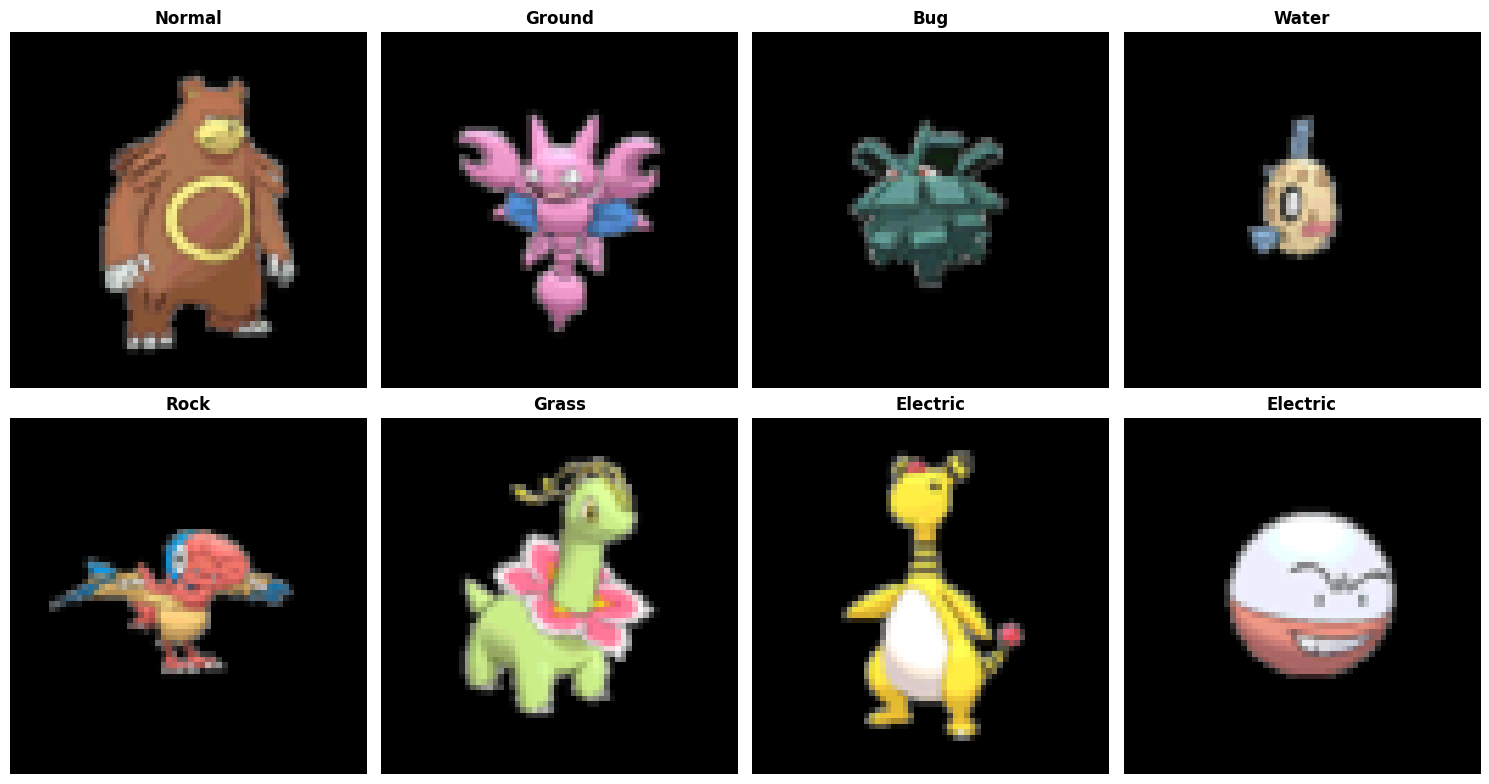

✓ Sample visualization saved as 'pokemon_samples.png'


In [10]:
sample_batch = next(iter(dataloader))
images, labels = sample_batch

print(f"✓ Batch loaded successfully!")
print(f"  - Batch shape: {images.shape}")
print(f"  - Labels shape: {labels.shape}")
print(f"  - Image value range: [{images.min():.2f}, {images.max():.2f}]")
print(f"  - Sample types in this batch: {[dataset.idx_to_type[l.item()] for l in labels[:4]]}")

print("\nVisualizing samples...")
show_batch(images, labels, dataset)

**VAE**

In [9]:
class ResnetBlock(nn.Module):
    """
    Residual block with GroupNorm
    Used in both encoder and decoder
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # First conv block
        self.norm1 = nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        # Second conv block
        self.norm2 = nn.GroupNorm(num_groups=32, num_channels=out_channels, eps=1e-6)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # Skip connection (if channels change)
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        h = x
        
        # First block
        h = self.norm1(h)
        h = F.silu(h)  # Swish activation
        h = self.conv1(h)
        
        # Second block
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        
        # Add skip connection
        return h + self.skip(x)




In [10]:
class AttentionBlock(nn.Module):
    """
    Self-attention block for capturing long-range dependencies
    """
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        
        self.norm = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6)
        
        # Q, K, V projections
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        
        # Output projection
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)
    
    def forward(self, x):
        h = self.norm(x)
        b, c, h_dim, w = h.shape
        
        # Compute Q, K, V
        q = self.q(h)
        k = self.k(h)
        v = self.v(h)
        
        # Reshape for attention: (B, C, H, W) -> (B, C, H*W) -> (B, H*W, C)
        q = q.reshape(b, c, h_dim * w).permute(0, 2, 1)
        k = k.reshape(b, c, h_dim * w).permute(0, 2, 1)
        v = v.reshape(b, c, h_dim * w).permute(0, 2, 1)
        
        # Compute attention scores
        scale = c ** -0.5
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) * scale, dim=-1)
        
        # Apply attention to values
        h = torch.bmm(attn, v)
        
        # Reshape back: (B, H*W, C) -> (B, C, H*W) -> (B, C, H, W)
        h = h.permute(0, 2, 1).reshape(b, c, h_dim, w)
        
        # Output projection
        h = self.proj_out(h)
        
        return x + h  # Residual connection


In [11]:
class Downsample(nn.Module):
    """Downsampling layer (reduces spatial dimensions by 2)"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.conv(x)

In [12]:
class VAEEncoder(nn.Module):
    """
    Encoder: Compresses images to latent space
    Input: (B, 3, 64, 64) RGB images
    Output: (B, 8, 8, 8) latent representation (mean and logvar)
    """
    def __init__(
        self,
        in_channels=3,
        latent_channels=4,
        hidden_dims=[64, 128, 256, 512],
    ):
        super().__init__()
        
        # Initial convolution
        self.conv_in = nn.Conv2d(in_channels, hidden_dims[0], kernel_size=3, padding=1)
        
        # Downsampling blocks
        self.down_blocks = nn.ModuleList()
        
        for i in range(len(hidden_dims)):
            in_ch = hidden_dims[i]
            out_ch = hidden_dims[i]
            
            # Each down block has:
            # - 2 ResNet blocks
            # - (optional) Attention block
            # - Downsampling (except last block)
            
            block = nn.ModuleList([
                ResnetBlock(in_ch if j == 0 and i == 0 else 
                           hidden_dims[i-1] if j == 0 else in_ch, out_ch)
                for j in range(2)
            ])
            
            # Add attention in the middle layers
            if i >= 2:
                block.append(AttentionBlock(out_ch))
            
            # Add downsampling (except for last block)
            if i < len(hidden_dims) - 1:
                block.append(Downsample(out_ch))
            
            self.down_blocks.append(block)
        
        # Middle blocks (at bottleneck)
        self.mid_block1 = ResnetBlock(hidden_dims[-1], hidden_dims[-1])
        self.mid_attn = AttentionBlock(hidden_dims[-1])
        self.mid_block2 = ResnetBlock(hidden_dims[-1], hidden_dims[-1])
        
        # Output layers (project to mean and logvar)
        self.norm_out = nn.GroupNorm(num_groups=32, num_channels=hidden_dims[-1], eps=1e-6)
        self.conv_out = nn.Conv2d(hidden_dims[-1], latent_channels * 2, kernel_size=3, padding=1)
        
        self.latent_channels = latent_channels
    
    def forward(self, x):
        # Initial conv
        h = self.conv_in(x)
        
        # Downsampling blocks
        for block_list in self.down_blocks:
            for block in block_list:
                h = block(h)
        
        # Middle blocks
        h = self.mid_block1(h)
        h = self.mid_attn(h)
        h = self.mid_block2(h)
        
        # Output projection
        h = self.norm_out(h)
        h = F.silu(h)
        h = self.conv_out(h)
        
        # Split into mean and logvar
        mean, logvar = torch.chunk(h, 2, dim=1)
        
        return mean, logvar

In [13]:
# Cell 8: Test the VAE Encoder

print("="*60)
print("TESTING VAE ENCODER")
print("="*60)

# Create encoder
encoder = VAEEncoder(
    in_channels=3,
    latent_channels=4,
    hidden_dims=[64, 128, 256, 512]
).to(device)

# Count parameters
total_params = sum(p.numel() for p in encoder.parameters())
trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)

print(f"\n✓ Encoder created")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

# Test with a sample batch
sample_images, _ = next(iter(dataloader))
sample_images = sample_images.to(device)

print(f"\n✓ Testing with sample batch")
print(f"  - Input shape: {sample_images.shape}")

# Forward pass
with torch.no_grad():
    mean, logvar = encoder(sample_images)

print(f"\n✓ Encoding successful!")
print(f"  - Mean shape: {mean.shape}")
print(f"  - Logvar shape: {logvar.shape}")
print(f"  - Compression ratio: {sample_images.numel() / mean.numel():.1f}x")

# Check output statistics
print(f"\n✓ Output statistics:")
print(f"  - Mean range: [{mean.min():.3f}, {mean.max():.3f}]")
print(f"  - Logvar range: [{logvar.min():.3f}, {logvar.max():.3f}]")

print("\n" + "="*60)
print("✓ VAE Encoder is working correctly!")
print("="*60)

TESTING VAE ENCODER

✓ Encoder created
  - Total parameters: 23,793,608
  - Trainable parameters: 23,793,608

✓ Testing with sample batch
  - Input shape: torch.Size([16, 3, 64, 64])

✓ Encoding successful!
  - Mean shape: torch.Size([16, 4, 8, 8])
  - Logvar shape: torch.Size([16, 4, 8, 8])
  - Compression ratio: 48.0x

✓ Output statistics:
  - Mean range: [-1.687, 1.165]
  - Logvar range: [-1.601, 1.406]

✓ VAE Encoder is working correctly!


In [14]:
class Upsample(nn.Module):
    """Upsampling layer (increases spatial dimensions by 2)"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # Upsample using nearest neighbor, then refine with conv
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        x = self.conv(x)
        return x

In [15]:
class VAEDecoder(nn.Module):
    """
    Decoder: Reconstructs images from latent space
    Input: (B, 4, 8, 8) latent representation
    Output: (B, 3, 64, 64) RGB images
    """
    def __init__(
        self,
        latent_channels=4,
        out_channels=3,
        hidden_dims=[512, 256, 128, 64],
    ):
        super().__init__()
        
        # Initial convolution (project latent to hidden dim)
        self.conv_in = nn.Conv2d(latent_channels, hidden_dims[0], kernel_size=3, padding=1)
        
        # Middle blocks (at bottleneck)
        self.mid_block1 = ResnetBlock(hidden_dims[0], hidden_dims[0])
        self.mid_attn = AttentionBlock(hidden_dims[0])
        self.mid_block2 = ResnetBlock(hidden_dims[0], hidden_dims[0])
        
        # Upsampling blocks
        self.up_blocks = nn.ModuleList()
        
        for i in range(len(hidden_dims)):
            in_ch = hidden_dims[i]
            out_ch = hidden_dims[i]
            
            # Each up block has:
            # - Upsampling (except first block)
            # - 2 ResNet blocks
            # - (optional) Attention block
            
            block = nn.ModuleList()
            
            # Add upsampling (except for first block)
            if i > 0:
                block.append(Upsample(in_ch))
            
            # Add ResNet blocks
            for j in range(2):
                out_channels_block = hidden_dims[i+1] if i < len(hidden_dims)-1 and j == 1 else out_ch
                block.append(ResnetBlock(in_ch, out_channels_block))
                in_ch = out_channels_block
            
            # Add attention in middle layers
            if i < 2:
                block.append(AttentionBlock(in_ch))
            
            self.up_blocks.append(block)
        
        # Output layers
        self.norm_out = nn.GroupNorm(num_groups=32, num_channels=hidden_dims[-1], eps=1e-6)
        self.conv_out = nn.Conv2d(hidden_dims[-1], out_channels, kernel_size=3, padding=1)
    
    def forward(self, z):
        # Initial conv
        h = self.conv_in(z)
        
        # Middle blocks
        h = self.mid_block1(h)
        h = self.mid_attn(h)
        h = self.mid_block2(h)
        
        # Upsampling blocks
        for block_list in self.up_blocks:
            for block in block_list:
                h = block(h)
        
        # Output projection
        h = self.norm_out(h)
        h = F.silu(h)
        h = self.conv_out(h)
        
        return h


In [16]:
class VAE(nn.Module):
    """
    Complete Variational Autoencoder
    Combines encoder and decoder with reparameterization trick
    """
    def __init__(
        self,
        in_channels=3,
        latent_channels=4,
        hidden_dims=[64, 128, 256, 512],
    ):
        super().__init__()
        
        self.encoder = VAEEncoder(
            in_channels=in_channels,
            latent_channels=latent_channels,
            hidden_dims=hidden_dims
        )
        
        self.decoder = VAEDecoder(
            latent_channels=latent_channels,
            out_channels=in_channels,
            hidden_dims=list(reversed(hidden_dims))
        )
        
        self.latent_channels = latent_channels
    
    def reparameterize(self, mean, logvar):
        """
        Reparameterization trick: z = mean + std * epsilon
        where epsilon ~ N(0, 1)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + std * eps
        return z
    
    def encode(self, x):
        """Encode image to latent distribution"""
        mean, logvar = self.encoder(x)
        return mean, logvar
    
    def decode(self, z):
        """Decode latent to image"""
        return self.decoder(z)
    
    def forward(self, x):
        """Full forward pass: encode -> reparameterize -> decode"""
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon = self.decode(z)
        return recon, mean, logvar


In [17]:
print("="*60)
print("TESTING COMPLETE VAE")
print("="*60)

# Create VAE
vae = VAE(
    in_channels=3,
    latent_channels=4,
    hidden_dims=[64, 128, 256, 512]
).to(device)

best_loss = float('inf')
best_ckpt_path = None

# Training loop
global_step = 0
print("Starting training loop...")# Count parameters
total_params = sum(p.numel() for p in vae.parameters())
encoder_params = sum(p.numel() for p in vae.encoder.parameters())
decoder_params = sum(p.numel() for p in vae.decoder.parameters())

print(f"\n✓ VAE created")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Encoder parameters: {encoder_params:,}")
print(f"  - Decoder parameters: {decoder_params:,}")

# Test with a sample batch
sample_images, _ = next(iter(dataloader))
sample_images = sample_images.to(device)

print(f"\n✓ Testing with sample batch")
print(f"  - Input shape: {sample_images.shape}")

# Forward pass
with torch.no_grad():
    reconstructed, mean, logvar = vae(sample_images)

print(f"\n✓ Reconstruction successful!")
print(f"  - Reconstructed shape: {reconstructed.shape}")
print(f"  - Latent mean shape: {mean.shape}")
print(f"  - Latent logvar shape: {logvar.shape}")

# Test encoding and decoding separately
with torch.no_grad():
    # Encode
    z_mean, z_logvar = vae.encode(sample_images)
    z = vae.reparameterize(z_mean, z_logvar)
    
    # Decode
    decoded = vae.decode(z)

print(f"\n✓ Separate encode/decode works!")
print(f"  - Latent z shape: {z.shape}")
print(f"  - Decoded shape: {decoded.shape}")

print("\n" + "="*60)
print("✓ VAE is working correctly!")
print("="*60)


TESTING COMPLETE VAE
Starting training loop...

✓ VAE created
  - Total parameters: 44,259,211
  - Encoder parameters: 23,793,608
  - Decoder parameters: 20,465,603

✓ Testing with sample batch
  - Input shape: torch.Size([16, 3, 64, 64])

✓ Reconstruction successful!
  - Reconstructed shape: torch.Size([16, 3, 64, 64])
  - Latent mean shape: torch.Size([16, 4, 8, 8])
  - Latent logvar shape: torch.Size([16, 4, 8, 8])

✓ Separate encode/decode works!
  - Latent z shape: torch.Size([16, 4, 8, 8])
  - Decoded shape: torch.Size([16, 3, 64, 64])

✓ VAE is working correctly!



Visualizing reconstruction (before training)...
Note: Will look blurry/bad - this is BEFORE training!


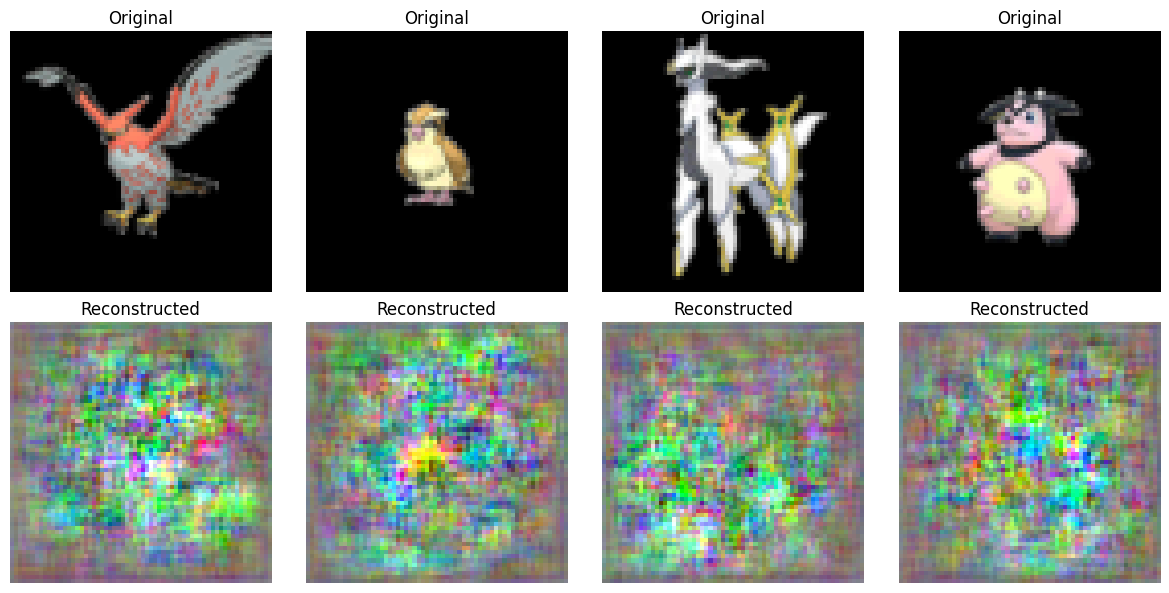

✓ Saved as 'vae_reconstruction_before_training.png'


In [18]:
def visualize_reconstruction(vae, dataloader, device, num_samples=4):
    """Visualize original images vs VAE reconstructions"""
    vae.eval()
    
    # Get a batch
    images, labels = next(iter(dataloader))
    images = images[:num_samples].to(device)
    
    # Reconstruct
    with torch.no_grad():
        reconstructed, _, _ = vae(images)
    
    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    
    for i in range(num_samples):
        # Original image
        img = images[i].cpu()
        img = (img + 1) / 2  # Denormalize
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed image
        rec = reconstructed[i].cpu()
        rec = (rec + 1) / 2  # Denormalize
        rec = rec.permute(1, 2, 0).numpy()
        rec = np.clip(rec, 0, 1)
        axes[1, i].imshow(rec)
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('vae_reconstruction_before_training.png', dpi=100, bbox_inches='tight')
    plt.show()

print("\nVisualizing reconstruction (before training)...")
print("Note: Will look blurry/bad - this is BEFORE training!")
visualize_reconstruction(vae, dataloader, device, num_samples=4)
print("✓ Saved as 'vae_reconstruction_before_training.png'")

In [25]:
def vae_loss(reconstructed, original, mean, logvar, kl_weight=0.00001):
    """
    VAE Loss = Reconstruction Loss + KL Divergence
    
    Args:
        reconstructed: Reconstructed images
        original: Original images
        mean: Latent mean from encoder
        logvar: Latent log variance from encoder
        kl_weight: Weight for KL divergence term (small to avoid posterior collapse)
    """
    # Reconstruction loss (MSE or L1)
    # We use L1 (MAE) as it often works better for images
    recon_loss = F.l1_loss(reconstructed, original, reduction='mean')
    
    # KL Divergence: KL(N(mean, var) || N(0, 1))
    # Formula: -0.5 * sum(1 + log(var) - mean^2 - var)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    kl_loss = kl_loss / original.size(0)  # Average over batch
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, recon_loss, kl_loss

In [26]:
def train_vae(vae, dataloader, num_epochs=500, lr=2e-4, kl_weight=0.00001, checkpoint_dir='./vae_checkpoints'):
    """
    Train the VAE - saves only the best model based on total loss
    """
    import os
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Optimizer
    optimizer = torch.optim.AdamW(vae.parameters(), lr=lr, weight_decay=0.01)
    
    # Learning rate scheduler (cosine annealing)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=lr/10
    )
    
    # Training history
    history = {
        'total_loss': [],
        'recon_loss': [],
        'kl_loss': []
    }
    
    # Track best model
    best_loss = float('inf')
    best_epoch = 0
    
    print("="*60)
    print("STARTING VAE TRAINING")
    print("="*60)
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {lr}")
    print(f"KL weight: {kl_weight}")
    print(f"Batches per epoch: {len(dataloader)}")
    print(f"Checkpoint dir: {checkpoint_dir}")
    print("="*60 + "\n")
    
    vae.train()
    
    for epoch in range(num_epochs):
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        
        # Progress bar
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (images, _) in enumerate(pbar):
            images = images.to(device)
            
            # Forward pass
            reconstructed, mean, logvar = vae(images)
            
            # Compute loss
            total_loss, recon_loss, kl_loss = vae_loss(
                reconstructed, images, mean, logvar, kl_weight=kl_weight
            )
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            
            # Gradient clipping (prevents exploding gradients)
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Track losses
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{total_loss.item():.4f}',
                'recon': f'{recon_loss.item():.4f}',
                'kl': f'{kl_loss.item():.2f}'
            })
        
        # Average losses for epoch
        avg_total = epoch_total_loss / len(dataloader)
        avg_recon = epoch_recon_loss / len(dataloader)
        avg_kl = epoch_kl_loss / len(dataloader)
        
        history['total_loss'].append(avg_total)
        history['recon_loss'].append(avg_recon)
        history['kl_loss'].append(avg_kl)
        
        # Update learning rate
        scheduler.step()
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Total Loss: {avg_total:.4f}")
        print(f"  Recon Loss: {avg_recon:.4f}")
        print(f"  KL Loss: {avg_kl:.2f}")
        print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save best model only
        if avg_total < best_loss:
            best_loss = avg_total
            best_epoch = epoch + 1
            
            checkpoint_path = os.path.join(checkpoint_dir, 'vae_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': vae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'total_loss': avg_total,
                'recon_loss': avg_recon,
                'kl_loss': avg_kl
            }, checkpoint_path)
            
            print(f"  🔥 NEW BEST MODEL! Saved to {checkpoint_path}")
            print(f"     Loss: {avg_total:.4f} (previous best: {best_loss:.4f})")
        else:
            print(f"  ❌ No improvement. Best: {best_loss:.4f} @ epoch {best_epoch}")
        
        print("-" * 60 + "\n")
        
        # Optional: Generate reconstruction samples every 50 epochs to monitor progress
        if (epoch + 1) % 50 == 0:
            save_reconstruction_samples(vae, dataloader, epoch + 1, checkpoint_dir)
    
    print("="*60)
    print("✓ TRAINING COMPLETE!")
    print("="*60)
    print(f"Best model: Epoch {best_epoch} with loss {best_loss:.4f}")
    print(f"Saved at: {os.path.join(checkpoint_dir, 'vae_best.pth')}")
    
    # Save final model (even if not best)
    final_path = os.path.join(checkpoint_dir, 'vae_final.pth')
    torch.save({
        'epoch': num_epochs - 1,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, final_path)
    print(f"Final model saved at: {final_path}")
    
    return history



In [31]:
def plot_vae_training_history(history, save_path='vae_training_curves.png'):
    """
    Plot VAE training curves
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['total_loss']) + 1)
    
    # Total Loss
    axes[0].plot(epochs, history['total_loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Total Loss', fontsize=12)
    axes[0].set_title('Total Loss (Recon + KL)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[1].plot(epochs, history['recon_loss'], 'r-', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Reconstruction Loss', fontsize=12)
    axes[1].set_title('Reconstruction Loss (L1)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # KL Loss
    axes[2].plot(epochs, history['kl_loss'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('KL Divergence', fontsize=12)
    axes[2].set_title('KL Divergence', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved training curves to {save_path}")


def load_best_vae(vae, checkpoint_path='./vae_checkpoints/vae_best.pth'):
    """
    Load the best VAE checkpoint
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    vae.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"✓ Loaded best VAE from epoch {checkpoint['epoch'] + 1}")
    print(f"  Total Loss: {checkpoint['total_loss']:.4f}")
    print(f"  Recon Loss: {checkpoint['recon_loss']:.4f}")
    print(f"  KL Loss: {checkpoint['kl_loss']:.2f}")
    
    return vae


In [30]:
@torch.no_grad()
def save_reconstruction_samples(vae, dataloader, epoch, save_dir):
    """
    Save reconstruction samples to monitor VAE quality during training
    """
    vae.eval()
    
    # Get a batch
    images, _ = next(iter(dataloader))
    images = images[:8].to(device)
    
    # Reconstruct
    reconstructed, mean, logvar = vae(images)
    
    # Create comparison grid
    comparison = torch.cat([images, reconstructed], dim=0)
    grid = make_grid(comparison, nrow=8, normalize=True, value_range=(-1, 1))
    
    save_path = os.path.join(save_dir, f'reconstruction_epoch_{epoch}.png')
    save_image(grid, save_path)
    
    vae.train()
    print(f"  📸 Saved reconstruction sample: {save_path}")

In [33]:
# Import torchvision utilities
try:
    from torchvision.utils import make_grid, save_image
except ImportError:
    print("Installing torchvision...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'torchvision'])
    from torchvision.utils import make_grid, save_image


Initializing training...
STARTING VAE TRAINING
Epochs: 500
Learning rate: 0.0002
KL weight: 1e-05
Batches per epoch: 51
Checkpoint dir: ./vae_checkpoints



Epoch 1/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.1458, recon=0.1441, kl=169.74]



Epoch 1 Summary:
  Total Loss: 0.2222
  Recon Loss: 0.2204
  KL Loss: 176.36
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.2222 (previous best: 0.2222)
------------------------------------------------------------



Epoch 2/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.1168, recon=0.1143, kl=248.18]



Epoch 2 Summary:
  Total Loss: 0.1127
  Recon Loss: 0.1104
  KL Loss: 228.80
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.1127 (previous best: 0.1127)
------------------------------------------------------------



Epoch 3/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.1001, recon=0.0979, kl=220.48]



Epoch 3 Summary:
  Total Loss: 0.0972
  Recon Loss: 0.0948
  KL Loss: 242.02
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0972 (previous best: 0.0972)
------------------------------------------------------------



Epoch 4/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0777, recon=0.0749, kl=281.40]



Epoch 4 Summary:
  Total Loss: 0.0869
  Recon Loss: 0.0843
  KL Loss: 256.57
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0869 (previous best: 0.0869)
------------------------------------------------------------



Epoch 5/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0655, recon=0.0629, kl=267.76]



Epoch 5 Summary:
  Total Loss: 0.0834
  Recon Loss: 0.0806
  KL Loss: 284.82
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0834 (previous best: 0.0834)
------------------------------------------------------------



Epoch 6/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0681, recon=0.0653, kl=283.08]



Epoch 6 Summary:
  Total Loss: 0.0740
  Recon Loss: 0.0713
  KL Loss: 278.15
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0740 (previous best: 0.0740)
------------------------------------------------------------



Epoch 7/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0676, recon=0.0647, kl=281.56]



Epoch 7 Summary:
  Total Loss: 0.0729
  Recon Loss: 0.0700
  KL Loss: 285.71
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0729 (previous best: 0.0729)
------------------------------------------------------------



Epoch 8/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0865, recon=0.0835, kl=298.92]



Epoch 8 Summary:
  Total Loss: 0.0707
  Recon Loss: 0.0677
  KL Loss: 292.65
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0707 (previous best: 0.0707)
------------------------------------------------------------



Epoch 9/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0636, recon=0.0608, kl=278.13]



Epoch 9 Summary:
  Total Loss: 0.0706
  Recon Loss: 0.0676
  KL Loss: 304.03
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0706 (previous best: 0.0706)
------------------------------------------------------------



Epoch 10/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0591, recon=0.0563, kl=280.57]



Epoch 10 Summary:
  Total Loss: 0.0680
  Recon Loss: 0.0651
  KL Loss: 290.69
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0680 (previous best: 0.0680)
------------------------------------------------------------



Epoch 11/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0513, recon=0.0486, kl=271.22]



Epoch 11 Summary:
  Total Loss: 0.0640
  Recon Loss: 0.0611
  KL Loss: 290.02
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0640 (previous best: 0.0640)
------------------------------------------------------------



Epoch 12/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0527, recon=0.0501, kl=262.70]



Epoch 12 Summary:
  Total Loss: 0.0654
  Recon Loss: 0.0624
  KL Loss: 292.42
  LR: 0.000200
  ❌ No improvement. Best: 0.0640 @ epoch 11
------------------------------------------------------------



Epoch 13/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0498, recon=0.0472, kl=262.72]



Epoch 13 Summary:
  Total Loss: 0.0638
  Recon Loss: 0.0608
  KL Loss: 299.46
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0638 (previous best: 0.0638)
------------------------------------------------------------



Epoch 14/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0614, recon=0.0583, kl=302.30]



Epoch 14 Summary:
  Total Loss: 0.0610
  Recon Loss: 0.0580
  KL Loss: 301.78
  LR: 0.000200
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0610 (previous best: 0.0610)
------------------------------------------------------------



Epoch 15/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0697, recon=0.0663, kl=346.60]



Epoch 15 Summary:
  Total Loss: 0.0685
  Recon Loss: 0.0649
  KL Loss: 352.06
  LR: 0.000200
  ❌ No improvement. Best: 0.0610 @ epoch 14
------------------------------------------------------------



Epoch 16/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0575, recon=0.0542, kl=332.24]



Epoch 16 Summary:
  Total Loss: 0.0629
  Recon Loss: 0.0597
  KL Loss: 319.76
  LR: 0.000200
  ❌ No improvement. Best: 0.0610 @ epoch 14
------------------------------------------------------------



Epoch 17/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0384, recon=0.0358, kl=260.86]



Epoch 17 Summary:
  Total Loss: 0.0646
  Recon Loss: 0.0614
  KL Loss: 321.05
  LR: 0.000199
  ❌ No improvement. Best: 0.0610 @ epoch 14
------------------------------------------------------------



Epoch 18/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0516, recon=0.0485, kl=305.41]



Epoch 18 Summary:
  Total Loss: 0.0586
  Recon Loss: 0.0555
  KL Loss: 310.74
  LR: 0.000199
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0586 (previous best: 0.0586)
------------------------------------------------------------



Epoch 19/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0466, recon=0.0442, kl=240.68]



Epoch 19 Summary:
  Total Loss: 0.0587
  Recon Loss: 0.0556
  KL Loss: 310.30
  LR: 0.000199
  ❌ No improvement. Best: 0.0586 @ epoch 18
------------------------------------------------------------



Epoch 20/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0523, recon=0.0494, kl=287.15]



Epoch 20 Summary:
  Total Loss: 0.0588
  Recon Loss: 0.0556
  KL Loss: 317.38
  LR: 0.000199
  ❌ No improvement. Best: 0.0586 @ epoch 18
------------------------------------------------------------



Epoch 21/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0527, recon=0.0496, kl=314.42]



Epoch 21 Summary:
  Total Loss: 0.0571
  Recon Loss: 0.0539
  KL Loss: 314.54
  LR: 0.000199
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0571 (previous best: 0.0571)
------------------------------------------------------------



Epoch 22/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0476, recon=0.0445, kl=306.47]



Epoch 22 Summary:
  Total Loss: 0.0570
  Recon Loss: 0.0538
  KL Loss: 316.07
  LR: 0.000199
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0570 (previous best: 0.0570)
------------------------------------------------------------



Epoch 23/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0522, recon=0.0492, kl=298.11]



Epoch 23 Summary:
  Total Loss: 0.0556
  Recon Loss: 0.0524
  KL Loss: 317.33
  LR: 0.000199
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0556 (previous best: 0.0556)
------------------------------------------------------------



Epoch 24/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0586, recon=0.0554, kl=321.18]



Epoch 24 Summary:
  Total Loss: 0.0561
  Recon Loss: 0.0529
  KL Loss: 317.17
  LR: 0.000199
  ❌ No improvement. Best: 0.0556 @ epoch 23
------------------------------------------------------------



Epoch 25/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0370, recon=0.0343, kl=267.27]



Epoch 25 Summary:
  Total Loss: 0.0545
  Recon Loss: 0.0513
  KL Loss: 317.33
  LR: 0.000199
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0545 (previous best: 0.0545)
------------------------------------------------------------



Epoch 26/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0593, recon=0.0560, kl=328.59]



Epoch 26 Summary:
  Total Loss: 0.0563
  Recon Loss: 0.0531
  KL Loss: 324.07
  LR: 0.000199
  ❌ No improvement. Best: 0.0545 @ epoch 25
------------------------------------------------------------



Epoch 27/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0641, recon=0.0604, kl=366.79]



Epoch 27 Summary:
  Total Loss: 0.0552
  Recon Loss: 0.0520
  KL Loss: 320.02
  LR: 0.000199
  ❌ No improvement. Best: 0.0545 @ epoch 25
------------------------------------------------------------



Epoch 28/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0494, recon=0.0462, kl=318.67]



Epoch 28 Summary:
  Total Loss: 0.0545
  Recon Loss: 0.0513
  KL Loss: 321.18
  LR: 0.000199
  ❌ No improvement. Best: 0.0545 @ epoch 25
------------------------------------------------------------



Epoch 29/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0561, recon=0.0528, kl=333.58]



Epoch 29 Summary:
  Total Loss: 0.0533
  Recon Loss: 0.0501
  KL Loss: 322.20
  LR: 0.000199
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0533 (previous best: 0.0533)
------------------------------------------------------------



Epoch 30/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0534, recon=0.0503, kl=309.68]



Epoch 30 Summary:
  Total Loss: 0.0532
  Recon Loss: 0.0500
  KL Loss: 325.70
  LR: 0.000198
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0532 (previous best: 0.0532)
------------------------------------------------------------



Epoch 31/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0436, recon=0.0406, kl=298.20]



Epoch 31 Summary:
  Total Loss: 0.0531
  Recon Loss: 0.0498
  KL Loss: 328.40
  LR: 0.000198
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0531 (previous best: 0.0531)
------------------------------------------------------------



Epoch 32/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0700, recon=0.0660, kl=396.39]



Epoch 32 Summary:
  Total Loss: 0.0511
  Recon Loss: 0.0478
  KL Loss: 327.60
  LR: 0.000198
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0511 (previous best: 0.0511)
------------------------------------------------------------



Epoch 33/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0466, recon=0.0435, kl=300.88]



Epoch 33 Summary:
  Total Loss: 0.0538
  Recon Loss: 0.0506
  KL Loss: 326.35
  LR: 0.000198
  ❌ No improvement. Best: 0.0511 @ epoch 32
------------------------------------------------------------



Epoch 34/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0482, recon=0.0452, kl=295.78]



Epoch 34 Summary:
  Total Loss: 0.0525
  Recon Loss: 0.0492
  KL Loss: 332.57
  LR: 0.000198
  ❌ No improvement. Best: 0.0511 @ epoch 32
------------------------------------------------------------



Epoch 35/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0407, recon=0.0379, kl=286.90]



Epoch 35 Summary:
  Total Loss: 0.0513
  Recon Loss: 0.0480
  KL Loss: 328.59
  LR: 0.000198
  ❌ No improvement. Best: 0.0511 @ epoch 32
------------------------------------------------------------



Epoch 36/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0438, recon=0.0406, kl=316.48]



Epoch 36 Summary:
  Total Loss: 0.0509
  Recon Loss: 0.0475
  KL Loss: 331.41
  LR: 0.000198
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0509 (previous best: 0.0509)
------------------------------------------------------------



Epoch 37/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0594, recon=0.0558, kl=358.15]



Epoch 37 Summary:
  Total Loss: 0.0519
  Recon Loss: 0.0486
  KL Loss: 331.93
  LR: 0.000198
  ❌ No improvement. Best: 0.0509 @ epoch 36
------------------------------------------------------------



Epoch 38/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0545, recon=0.0509, kl=363.53]



Epoch 38 Summary:
  Total Loss: 0.0516
  Recon Loss: 0.0483
  KL Loss: 331.65
  LR: 0.000197
  ❌ No improvement. Best: 0.0509 @ epoch 36
------------------------------------------------------------



Epoch 39/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0574, recon=0.0540, kl=342.83]



Epoch 39 Summary:
  Total Loss: 0.0525
  Recon Loss: 0.0492
  KL Loss: 335.92
  LR: 0.000197
  ❌ No improvement. Best: 0.0509 @ epoch 36
------------------------------------------------------------



Epoch 40/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0487, recon=0.0452, kl=347.94]



Epoch 40 Summary:
  Total Loss: 0.0510
  Recon Loss: 0.0477
  KL Loss: 336.24
  LR: 0.000197
  ❌ No improvement. Best: 0.0509 @ epoch 36
------------------------------------------------------------



Epoch 41/500: 100%|██████████| 51/51 [00:04<00:00, 10.92it/s, loss=0.0521, recon=0.0489, kl=313.63]



Epoch 41 Summary:
  Total Loss: 0.0499
  Recon Loss: 0.0465
  KL Loss: 339.29
  LR: 0.000197
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0499 (previous best: 0.0499)
------------------------------------------------------------



Epoch 42/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0497, recon=0.0461, kl=361.06]



Epoch 42 Summary:
  Total Loss: 0.0542
  Recon Loss: 0.0508
  KL Loss: 342.56
  LR: 0.000197
  ❌ No improvement. Best: 0.0499 @ epoch 41
------------------------------------------------------------



Epoch 43/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0451, recon=0.0420, kl=309.74]



Epoch 43 Summary:
  Total Loss: 0.0522
  Recon Loss: 0.0486
  KL Loss: 356.33
  LR: 0.000197
  ❌ No improvement. Best: 0.0499 @ epoch 41
------------------------------------------------------------



Epoch 44/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0587, recon=0.0551, kl=361.67]



Epoch 44 Summary:
  Total Loss: 0.0543
  Recon Loss: 0.0508
  KL Loss: 351.82
  LR: 0.000197
  ❌ No improvement. Best: 0.0499 @ epoch 41
------------------------------------------------------------



Epoch 45/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0535, recon=0.0498, kl=370.37]



Epoch 45 Summary:
  Total Loss: 0.0498
  Recon Loss: 0.0464
  KL Loss: 342.31
  LR: 0.000196
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0498 (previous best: 0.0498)
------------------------------------------------------------



Epoch 46/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0463, recon=0.0433, kl=299.30]



Epoch 46 Summary:
  Total Loss: 0.0513
  Recon Loss: 0.0478
  KL Loss: 351.00
  LR: 0.000196
  ❌ No improvement. Best: 0.0498 @ epoch 45
------------------------------------------------------------



Epoch 47/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0557, recon=0.0520, kl=364.98]



Epoch 47 Summary:
  Total Loss: 0.0484
  Recon Loss: 0.0449
  KL Loss: 350.64
  LR: 0.000196
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0484 (previous best: 0.0484)
------------------------------------------------------------



Epoch 48/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0442, recon=0.0407, kl=352.38]



Epoch 48 Summary:
  Total Loss: 0.0481
  Recon Loss: 0.0446
  KL Loss: 351.77
  LR: 0.000196
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0481 (previous best: 0.0481)
------------------------------------------------------------



Epoch 49/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0446, recon=0.0414, kl=322.56]



Epoch 49 Summary:
  Total Loss: 0.0493
  Recon Loss: 0.0458
  KL Loss: 348.57
  LR: 0.000196
  ❌ No improvement. Best: 0.0481 @ epoch 48
------------------------------------------------------------



Epoch 50/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0502, recon=0.0464, kl=373.02]



Epoch 50 Summary:
  Total Loss: 0.0454
  Recon Loss: 0.0419
  KL Loss: 356.03
  LR: 0.000196
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0454 (previous best: 0.0454)
------------------------------------------------------------

  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_50.png


Epoch 51/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0483, recon=0.0447, kl=360.03]



Epoch 51 Summary:
  Total Loss: 0.0504
  Recon Loss: 0.0469
  KL Loss: 352.34
  LR: 0.000195
  ❌ No improvement. Best: 0.0454 @ epoch 50
------------------------------------------------------------



Epoch 52/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0456, recon=0.0420, kl=357.87]



Epoch 52 Summary:
  Total Loss: 0.0481
  Recon Loss: 0.0445
  KL Loss: 361.05
  LR: 0.000195
  ❌ No improvement. Best: 0.0454 @ epoch 50
------------------------------------------------------------



Epoch 53/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0484, recon=0.0448, kl=358.37]



Epoch 53 Summary:
  Total Loss: 0.0474
  Recon Loss: 0.0439
  KL Loss: 354.79
  LR: 0.000195
  ❌ No improvement. Best: 0.0454 @ epoch 50
------------------------------------------------------------



Epoch 54/500: 100%|██████████| 51/51 [00:04<00:00, 10.91it/s, loss=0.0532, recon=0.0493, kl=388.47]



Epoch 54 Summary:
  Total Loss: 0.0452
  Recon Loss: 0.0416
  KL Loss: 358.17
  LR: 0.000195
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0452 (previous best: 0.0452)
------------------------------------------------------------



Epoch 55/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0439, recon=0.0402, kl=375.73]



Epoch 55 Summary:
  Total Loss: 0.0487
  Recon Loss: 0.0452
  KL Loss: 356.54
  LR: 0.000195
  ❌ No improvement. Best: 0.0452 @ epoch 54
------------------------------------------------------------



Epoch 56/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0442, recon=0.0407, kl=346.32]



Epoch 56 Summary:
  Total Loss: 0.0446
  Recon Loss: 0.0410
  KL Loss: 359.44
  LR: 0.000194
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0446 (previous best: 0.0446)
------------------------------------------------------------



Epoch 57/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0445, recon=0.0408, kl=367.47]



Epoch 57 Summary:
  Total Loss: 0.0451
  Recon Loss: 0.0415
  KL Loss: 361.57
  LR: 0.000194
  ❌ No improvement. Best: 0.0446 @ epoch 56
------------------------------------------------------------



Epoch 58/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0370, recon=0.0337, kl=327.17]



Epoch 58 Summary:
  Total Loss: 0.0470
  Recon Loss: 0.0435
  KL Loss: 358.72
  LR: 0.000194
  ❌ No improvement. Best: 0.0446 @ epoch 56
------------------------------------------------------------



Epoch 59/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0439, recon=0.0401, kl=381.94]



Epoch 59 Summary:
  Total Loss: 0.0489
  Recon Loss: 0.0452
  KL Loss: 370.14
  LR: 0.000194
  ❌ No improvement. Best: 0.0446 @ epoch 56
------------------------------------------------------------



Epoch 60/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0428, recon=0.0389, kl=391.53]



Epoch 60 Summary:
  Total Loss: 0.0442
  Recon Loss: 0.0405
  KL Loss: 364.33
  LR: 0.000194
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0442 (previous best: 0.0442)
------------------------------------------------------------



Epoch 61/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0456, recon=0.0420, kl=364.95]



Epoch 61 Summary:
  Total Loss: 0.0446
  Recon Loss: 0.0409
  KL Loss: 363.80
  LR: 0.000193
  ❌ No improvement. Best: 0.0442 @ epoch 60
------------------------------------------------------------



Epoch 62/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0515, recon=0.0472, kl=425.85]



Epoch 62 Summary:
  Total Loss: 0.0438
  Recon Loss: 0.0401
  KL Loss: 370.56
  LR: 0.000193
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0438 (previous best: 0.0438)
------------------------------------------------------------



Epoch 63/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0503, recon=0.0463, kl=400.88]



Epoch 63 Summary:
  Total Loss: 0.0439
  Recon Loss: 0.0402
  KL Loss: 369.25
  LR: 0.000193
  ❌ No improvement. Best: 0.0438 @ epoch 62
------------------------------------------------------------



Epoch 64/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0604, recon=0.0564, kl=400.43]



Epoch 64 Summary:
  Total Loss: 0.0457
  Recon Loss: 0.0420
  KL Loss: 364.85
  LR: 0.000193
  ❌ No improvement. Best: 0.0438 @ epoch 62
------------------------------------------------------------



Epoch 65/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0363, recon=0.0328, kl=344.10]



Epoch 65 Summary:
  Total Loss: 0.0449
  Recon Loss: 0.0412
  KL Loss: 366.72
  LR: 0.000193
  ❌ No improvement. Best: 0.0438 @ epoch 62
------------------------------------------------------------



Epoch 66/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0377, recon=0.0343, kl=340.11]



Epoch 66 Summary:
  Total Loss: 0.0429
  Recon Loss: 0.0392
  KL Loss: 366.84
  LR: 0.000192
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0429 (previous best: 0.0429)
------------------------------------------------------------



Epoch 67/500: 100%|██████████| 51/51 [00:04<00:00, 10.91it/s, loss=0.0350, recon=0.0312, kl=373.45]



Epoch 67 Summary:
  Total Loss: 0.0424
  Recon Loss: 0.0386
  KL Loss: 372.83
  LR: 0.000192
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0424 (previous best: 0.0424)
------------------------------------------------------------



Epoch 68/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0327, recon=0.0296, kl=311.44]



Epoch 68 Summary:
  Total Loss: 0.0421
  Recon Loss: 0.0385
  KL Loss: 366.24
  LR: 0.000192
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0421 (previous best: 0.0421)
------------------------------------------------------------



Epoch 69/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0458, recon=0.0418, kl=400.11]



Epoch 69 Summary:
  Total Loss: 0.0420
  Recon Loss: 0.0383
  KL Loss: 376.62
  LR: 0.000192
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0420 (previous best: 0.0420)
------------------------------------------------------------



Epoch 70/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0403, recon=0.0364, kl=390.58]



Epoch 70 Summary:
  Total Loss: 0.0423
  Recon Loss: 0.0386
  KL Loss: 369.66
  LR: 0.000191
  ❌ No improvement. Best: 0.0420 @ epoch 69
------------------------------------------------------------



Epoch 71/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0526, recon=0.0486, kl=395.47]



Epoch 71 Summary:
  Total Loss: 0.0430
  Recon Loss: 0.0393
  KL Loss: 368.42
  LR: 0.000191
  ❌ No improvement. Best: 0.0420 @ epoch 69
------------------------------------------------------------



Epoch 72/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0469, recon=0.0434, kl=358.54]



Epoch 72 Summary:
  Total Loss: 0.0429
  Recon Loss: 0.0393
  KL Loss: 369.61
  LR: 0.000191
  ❌ No improvement. Best: 0.0420 @ epoch 69
------------------------------------------------------------



Epoch 73/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0477, recon=0.0437, kl=400.35]



Epoch 73 Summary:
  Total Loss: 0.0445
  Recon Loss: 0.0408
  KL Loss: 370.88
  LR: 0.000191
  ❌ No improvement. Best: 0.0420 @ epoch 69
------------------------------------------------------------



Epoch 74/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0560, recon=0.0518, kl=424.27]



Epoch 74 Summary:
  Total Loss: 0.0427
  Recon Loss: 0.0389
  KL Loss: 378.58
  LR: 0.000190
  ❌ No improvement. Best: 0.0420 @ epoch 69
------------------------------------------------------------



Epoch 75/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0390, recon=0.0350, kl=396.83]



Epoch 75 Summary:
  Total Loss: 0.0421
  Recon Loss: 0.0384
  KL Loss: 374.50
  LR: 0.000190
  ❌ No improvement. Best: 0.0420 @ epoch 69
------------------------------------------------------------



Epoch 76/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0407, recon=0.0372, kl=357.04]



Epoch 76 Summary:
  Total Loss: 0.0417
  Recon Loss: 0.0380
  KL Loss: 374.05
  LR: 0.000190
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0417 (previous best: 0.0417)
------------------------------------------------------------



Epoch 77/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0434, recon=0.0394, kl=402.76]



Epoch 77 Summary:
  Total Loss: 0.0417
  Recon Loss: 0.0379
  KL Loss: 376.32
  LR: 0.000190
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0417 (previous best: 0.0417)
------------------------------------------------------------



Epoch 78/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0364, recon=0.0327, kl=368.77]



Epoch 78 Summary:
  Total Loss: 0.0414
  Recon Loss: 0.0375
  KL Loss: 382.31
  LR: 0.000189
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0414 (previous best: 0.0414)
------------------------------------------------------------



Epoch 79/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0312, recon=0.0276, kl=353.54]



Epoch 79 Summary:
  Total Loss: 0.0405
  Recon Loss: 0.0364
  KL Loss: 405.54
  LR: 0.000189
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0405 (previous best: 0.0405)
------------------------------------------------------------



Epoch 80/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0563, recon=0.0523, kl=394.62]



Epoch 80 Summary:
  Total Loss: 0.0427
  Recon Loss: 0.0388
  KL Loss: 385.99
  LR: 0.000189
  ❌ No improvement. Best: 0.0405 @ epoch 79
------------------------------------------------------------



Epoch 81/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0402, recon=0.0369, kl=336.13]



Epoch 81 Summary:
  Total Loss: 0.0458
  Recon Loss: 0.0420
  KL Loss: 375.00
  LR: 0.000189
  ❌ No improvement. Best: 0.0405 @ epoch 79
------------------------------------------------------------



Epoch 82/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0473, recon=0.0428, kl=451.54]



Epoch 82 Summary:
  Total Loss: 0.0415
  Recon Loss: 0.0377
  KL Loss: 378.47
  LR: 0.000188
  ❌ No improvement. Best: 0.0405 @ epoch 79
------------------------------------------------------------



Epoch 83/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0414, recon=0.0378, kl=361.41]



Epoch 83 Summary:
  Total Loss: 0.0398
  Recon Loss: 0.0360
  KL Loss: 381.50
  LR: 0.000188
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0398 (previous best: 0.0398)
------------------------------------------------------------



Epoch 84/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0389, recon=0.0347, kl=417.96]



Epoch 84 Summary:
  Total Loss: 0.0381
  Recon Loss: 0.0342
  KL Loss: 384.52
  LR: 0.000188
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0381 (previous best: 0.0381)
------------------------------------------------------------



Epoch 85/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0345, recon=0.0311, kl=335.30]



Epoch 85 Summary:
  Total Loss: 0.0395
  Recon Loss: 0.0357
  KL Loss: 382.25
  LR: 0.000187
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 86/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0361, recon=0.0324, kl=371.06]



Epoch 86 Summary:
  Total Loss: 0.0401
  Recon Loss: 0.0363
  KL Loss: 377.92
  LR: 0.000187
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 87/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0363, recon=0.0327, kl=362.51]



Epoch 87 Summary:
  Total Loss: 0.0397
  Recon Loss: 0.0358
  KL Loss: 383.49
  LR: 0.000187
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 88/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0494, recon=0.0461, kl=330.99]



Epoch 88 Summary:
  Total Loss: 0.0456
  Recon Loss: 0.0417
  KL Loss: 381.21
  LR: 0.000187
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 89/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0446, recon=0.0408, kl=381.14]



Epoch 89 Summary:
  Total Loss: 0.0471
  Recon Loss: 0.0434
  KL Loss: 368.35
  LR: 0.000186
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 90/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0362, recon=0.0327, kl=350.50]



Epoch 90 Summary:
  Total Loss: 0.0412
  Recon Loss: 0.0374
  KL Loss: 386.25
  LR: 0.000186
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 91/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0424, recon=0.0384, kl=396.91]



Epoch 91 Summary:
  Total Loss: 0.0392
  Recon Loss: 0.0353
  KL Loss: 384.70
  LR: 0.000186
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 92/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0446, recon=0.0402, kl=439.57]



Epoch 92 Summary:
  Total Loss: 0.0386
  Recon Loss: 0.0346
  KL Loss: 394.33
  LR: 0.000185
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 93/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0351, recon=0.0315, kl=357.61]



Epoch 93 Summary:
  Total Loss: 0.0398
  Recon Loss: 0.0360
  KL Loss: 382.17
  LR: 0.000185
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 94/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0453, recon=0.0411, kl=416.83]



Epoch 94 Summary:
  Total Loss: 0.0387
  Recon Loss: 0.0349
  KL Loss: 385.02
  LR: 0.000185
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 95/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0327, recon=0.0291, kl=361.65]



Epoch 95 Summary:
  Total Loss: 0.0395
  Recon Loss: 0.0357
  KL Loss: 383.15
  LR: 0.000184
  ❌ No improvement. Best: 0.0381 @ epoch 84
------------------------------------------------------------



Epoch 96/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0382, recon=0.0342, kl=401.09]



Epoch 96 Summary:
  Total Loss: 0.0372
  Recon Loss: 0.0333
  KL Loss: 384.61
  LR: 0.000184
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0372 (previous best: 0.0372)
------------------------------------------------------------



Epoch 97/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0451, recon=0.0411, kl=402.49]



Epoch 97 Summary:
  Total Loss: 0.0368
  Recon Loss: 0.0329
  KL Loss: 390.73
  LR: 0.000184
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0368 (previous best: 0.0368)
------------------------------------------------------------



Epoch 98/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0410, recon=0.0368, kl=426.86]



Epoch 98 Summary:
  Total Loss: 0.0376
  Recon Loss: 0.0337
  KL Loss: 390.69
  LR: 0.000183
  ❌ No improvement. Best: 0.0368 @ epoch 97
------------------------------------------------------------



Epoch 99/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0374, recon=0.0336, kl=380.98]



Epoch 99 Summary:
  Total Loss: 0.0366
  Recon Loss: 0.0328
  KL Loss: 386.18
  LR: 0.000183
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0366 (previous best: 0.0366)
------------------------------------------------------------



Epoch 100/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0321, recon=0.0284, kl=367.62]


Epoch 100 Summary:
  Total Loss: 0.0377
  Recon Loss: 0.0338
  KL Loss: 387.97
  LR: 0.000183
  ❌ No improvement. Best: 0.0366 @ epoch 99
------------------------------------------------------------



  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_100.png


Epoch 101/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0417, recon=0.0371, kl=462.59]



Epoch 101 Summary:
  Total Loss: 0.0352
  Recon Loss: 0.0313
  KL Loss: 390.80
  LR: 0.000182
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0352 (previous best: 0.0352)
------------------------------------------------------------



Epoch 102/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0414, recon=0.0371, kl=427.01]



Epoch 102 Summary:
  Total Loss: 0.0367
  Recon Loss: 0.0327
  KL Loss: 392.48
  LR: 0.000182
  ❌ No improvement. Best: 0.0352 @ epoch 101
------------------------------------------------------------



Epoch 103/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0319, recon=0.0284, kl=346.17]



Epoch 103 Summary:
  Total Loss: 0.0356
  Recon Loss: 0.0317
  KL Loss: 389.29
  LR: 0.000182
  ❌ No improvement. Best: 0.0352 @ epoch 101
------------------------------------------------------------



Epoch 104/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0408, recon=0.0365, kl=430.70]



Epoch 104 Summary:
  Total Loss: 0.0369
  Recon Loss: 0.0330
  KL Loss: 387.47
  LR: 0.000181
  ❌ No improvement. Best: 0.0352 @ epoch 101
------------------------------------------------------------



Epoch 105/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0292, recon=0.0259, kl=321.07]



Epoch 105 Summary:
  Total Loss: 0.0371
  Recon Loss: 0.0332
  KL Loss: 387.12
  LR: 0.000181
  ❌ No improvement. Best: 0.0352 @ epoch 101
------------------------------------------------------------



Epoch 106/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0335, recon=0.0299, kl=362.48]



Epoch 106 Summary:
  Total Loss: 0.0347
  Recon Loss: 0.0308
  KL Loss: 394.39
  LR: 0.000181
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0347 (previous best: 0.0347)
------------------------------------------------------------



Epoch 107/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0461, recon=0.0413, kl=484.43]



Epoch 107 Summary:
  Total Loss: 0.0358
  Recon Loss: 0.0319
  KL Loss: 388.07
  LR: 0.000180
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 108/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0357, recon=0.0322, kl=353.69]



Epoch 108 Summary:
  Total Loss: 0.0364
  Recon Loss: 0.0325
  KL Loss: 389.79
  LR: 0.000180
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 109/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0368, recon=0.0334, kl=337.00]



Epoch 109 Summary:
  Total Loss: 0.0381
  Recon Loss: 0.0342
  KL Loss: 388.81
  LR: 0.000180
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 110/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0382, recon=0.0344, kl=384.71]



Epoch 110 Summary:
  Total Loss: 0.0354
  Recon Loss: 0.0315
  KL Loss: 388.82
  LR: 0.000179
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 111/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0281, recon=0.0244, kl=369.07]



Epoch 111 Summary:
  Total Loss: 0.0363
  Recon Loss: 0.0323
  KL Loss: 400.18
  LR: 0.000179
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 112/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0406, recon=0.0367, kl=392.65]



Epoch 112 Summary:
  Total Loss: 0.0365
  Recon Loss: 0.0326
  KL Loss: 391.48
  LR: 0.000179
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 113/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0287, recon=0.0251, kl=360.21]



Epoch 113 Summary:
  Total Loss: 0.0371
  Recon Loss: 0.0332
  KL Loss: 392.89
  LR: 0.000178
  ❌ No improvement. Best: 0.0347 @ epoch 106
------------------------------------------------------------



Epoch 114/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0335, recon=0.0295, kl=395.30]



Epoch 114 Summary:
  Total Loss: 0.0338
  Recon Loss: 0.0298
  KL Loss: 399.07
  LR: 0.000178
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0338 (previous best: 0.0338)
------------------------------------------------------------



Epoch 115/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0418, recon=0.0373, kl=451.53]



Epoch 115 Summary:
  Total Loss: 0.0352
  Recon Loss: 0.0312
  KL Loss: 396.16
  LR: 0.000178
  ❌ No improvement. Best: 0.0338 @ epoch 114
------------------------------------------------------------



Epoch 116/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0358, recon=0.0317, kl=410.48]



Epoch 116 Summary:
  Total Loss: 0.0339
  Recon Loss: 0.0299
  KL Loss: 392.78
  LR: 0.000177
  ❌ No improvement. Best: 0.0338 @ epoch 114
------------------------------------------------------------



Epoch 117/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0365, recon=0.0323, kl=413.79]



Epoch 117 Summary:
  Total Loss: 0.0348
  Recon Loss: 0.0309
  KL Loss: 391.00
  LR: 0.000177
  ❌ No improvement. Best: 0.0338 @ epoch 114
------------------------------------------------------------



Epoch 118/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0270, recon=0.0235, kl=351.71]



Epoch 118 Summary:
  Total Loss: 0.0348
  Recon Loss: 0.0310
  KL Loss: 388.54
  LR: 0.000176
  ❌ No improvement. Best: 0.0338 @ epoch 114
------------------------------------------------------------



Epoch 119/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0334, recon=0.0294, kl=400.29]



Epoch 119 Summary:
  Total Loss: 0.0328
  Recon Loss: 0.0289
  KL Loss: 397.53
  LR: 0.000176
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0328 (previous best: 0.0328)
------------------------------------------------------------



Epoch 120/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0359, recon=0.0318, kl=403.18]



Epoch 120 Summary:
  Total Loss: 0.0336
  Recon Loss: 0.0297
  KL Loss: 395.67
  LR: 0.000176
  ❌ No improvement. Best: 0.0328 @ epoch 119
------------------------------------------------------------



Epoch 121/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0294, recon=0.0259, kl=351.69]



Epoch 121 Summary:
  Total Loss: 0.0325
  Recon Loss: 0.0286
  KL Loss: 395.46
  LR: 0.000175
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0325 (previous best: 0.0325)
------------------------------------------------------------



Epoch 122/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0421, recon=0.0378, kl=422.33]



Epoch 122 Summary:
  Total Loss: 0.0330
  Recon Loss: 0.0289
  KL Loss: 400.47
  LR: 0.000175
  ❌ No improvement. Best: 0.0325 @ epoch 121
------------------------------------------------------------



Epoch 123/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0372, recon=0.0327, kl=441.75]



Epoch 123 Summary:
  Total Loss: 0.0353
  Recon Loss: 0.0314
  KL Loss: 393.50
  LR: 0.000174
  ❌ No improvement. Best: 0.0325 @ epoch 121
------------------------------------------------------------



Epoch 124/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0358, recon=0.0316, kl=421.06]



Epoch 124 Summary:
  Total Loss: 0.0360
  Recon Loss: 0.0320
  KL Loss: 396.13
  LR: 0.000174
  ❌ No improvement. Best: 0.0325 @ epoch 121
------------------------------------------------------------



Epoch 125/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0275, recon=0.0241, kl=335.83]



Epoch 125 Summary:
  Total Loss: 0.0336
  Recon Loss: 0.0297
  KL Loss: 394.05
  LR: 0.000174
  ❌ No improvement. Best: 0.0325 @ epoch 121
------------------------------------------------------------



Epoch 126/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0341, recon=0.0299, kl=421.75]



Epoch 126 Summary:
  Total Loss: 0.0320
  Recon Loss: 0.0280
  KL Loss: 396.14
  LR: 0.000173
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0320 (previous best: 0.0320)
------------------------------------------------------------



Epoch 127/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0299, recon=0.0262, kl=375.30]



Epoch 127 Summary:
  Total Loss: 0.0316
  Recon Loss: 0.0277
  KL Loss: 396.46
  LR: 0.000173
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0316 (previous best: 0.0316)
------------------------------------------------------------



Epoch 128/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0330, recon=0.0286, kl=440.98]



Epoch 128 Summary:
  Total Loss: 0.0323
  Recon Loss: 0.0283
  KL Loss: 397.03
  LR: 0.000172
  ❌ No improvement. Best: 0.0316 @ epoch 127
------------------------------------------------------------



Epoch 129/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0303, recon=0.0267, kl=357.01]



Epoch 129 Summary:
  Total Loss: 0.0351
  Recon Loss: 0.0312
  KL Loss: 387.85
  LR: 0.000172
  ❌ No improvement. Best: 0.0316 @ epoch 127
------------------------------------------------------------



Epoch 130/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0287, recon=0.0251, kl=353.02]



Epoch 130 Summary:
  Total Loss: 0.0333
  Recon Loss: 0.0293
  KL Loss: 397.64
  LR: 0.000172
  ❌ No improvement. Best: 0.0316 @ epoch 127
------------------------------------------------------------



Epoch 131/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0306, recon=0.0267, kl=394.60]



Epoch 131 Summary:
  Total Loss: 0.0323
  Recon Loss: 0.0283
  KL Loss: 397.73
  LR: 0.000171
  ❌ No improvement. Best: 0.0316 @ epoch 127
------------------------------------------------------------



Epoch 132/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0260, recon=0.0225, kl=352.01]



Epoch 132 Summary:
  Total Loss: 0.0320
  Recon Loss: 0.0280
  KL Loss: 397.85
  LR: 0.000171
  ❌ No improvement. Best: 0.0316 @ epoch 127
------------------------------------------------------------



Epoch 133/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0269, recon=0.0232, kl=373.51]



Epoch 133 Summary:
  Total Loss: 0.0321
  Recon Loss: 0.0281
  KL Loss: 396.95
  LR: 0.000170
  ❌ No improvement. Best: 0.0316 @ epoch 127
------------------------------------------------------------



Epoch 134/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0296, recon=0.0250, kl=453.84]



Epoch 134 Summary:
  Total Loss: 0.0314
  Recon Loss: 0.0274
  KL Loss: 401.90
  LR: 0.000170
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0314 (previous best: 0.0314)
------------------------------------------------------------



Epoch 135/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0305, recon=0.0267, kl=383.39]



Epoch 135 Summary:
  Total Loss: 0.0318
  Recon Loss: 0.0277
  KL Loss: 414.92
  LR: 0.000170
  ❌ No improvement. Best: 0.0314 @ epoch 134
------------------------------------------------------------



Epoch 136/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0297, recon=0.0254, kl=421.38]



Epoch 136 Summary:
  Total Loss: 0.0322
  Recon Loss: 0.0282
  KL Loss: 399.11
  LR: 0.000169
  ❌ No improvement. Best: 0.0314 @ epoch 134
------------------------------------------------------------



Epoch 137/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0273, recon=0.0234, kl=389.36]



Epoch 137 Summary:
  Total Loss: 0.0320
  Recon Loss: 0.0280
  KL Loss: 397.85
  LR: 0.000169
  ❌ No improvement. Best: 0.0314 @ epoch 134
------------------------------------------------------------



Epoch 138/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0310, recon=0.0273, kl=369.70]



Epoch 138 Summary:
  Total Loss: 0.0315
  Recon Loss: 0.0275
  KL Loss: 400.82
  LR: 0.000168
  ❌ No improvement. Best: 0.0314 @ epoch 134
------------------------------------------------------------



Epoch 139/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0294, recon=0.0257, kl=374.04]



Epoch 139 Summary:
  Total Loss: 0.0319
  Recon Loss: 0.0279
  KL Loss: 399.69
  LR: 0.000168
  ❌ No improvement. Best: 0.0314 @ epoch 134
------------------------------------------------------------



Epoch 140/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0351, recon=0.0309, kl=422.25]



Epoch 140 Summary:
  Total Loss: 0.0302
  Recon Loss: 0.0262
  KL Loss: 400.97
  LR: 0.000167
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0302 (previous best: 0.0302)
------------------------------------------------------------



Epoch 141/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0311, recon=0.0275, kl=359.04]



Epoch 141 Summary:
  Total Loss: 0.0334
  Recon Loss: 0.0295
  KL Loss: 392.10
  LR: 0.000167
  ❌ No improvement. Best: 0.0302 @ epoch 140
------------------------------------------------------------



Epoch 142/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0266, recon=0.0228, kl=372.22]



Epoch 142 Summary:
  Total Loss: 0.0309
  Recon Loss: 0.0270
  KL Loss: 396.07
  LR: 0.000166
  ❌ No improvement. Best: 0.0302 @ epoch 140
------------------------------------------------------------



Epoch 143/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0268, recon=0.0229, kl=383.84]



Epoch 143 Summary:
  Total Loss: 0.0310
  Recon Loss: 0.0270
  KL Loss: 397.24
  LR: 0.000166
  ❌ No improvement. Best: 0.0302 @ epoch 140
------------------------------------------------------------



Epoch 144/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0278, recon=0.0237, kl=408.77]



Epoch 144 Summary:
  Total Loss: 0.0304
  Recon Loss: 0.0264
  KL Loss: 400.35
  LR: 0.000166
  ❌ No improvement. Best: 0.0302 @ epoch 140
------------------------------------------------------------



Epoch 145/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0282, recon=0.0242, kl=403.89]



Epoch 145 Summary:
  Total Loss: 0.0309
  Recon Loss: 0.0269
  KL Loss: 400.98
  LR: 0.000165
  ❌ No improvement. Best: 0.0302 @ epoch 140
------------------------------------------------------------



Epoch 146/500: 100%|██████████| 51/51 [00:04<00:00, 10.79it/s, loss=0.0314, recon=0.0272, kl=425.73]



Epoch 146 Summary:
  Total Loss: 0.0302
  Recon Loss: 0.0262
  KL Loss: 399.40
  LR: 0.000165
  ❌ No improvement. Best: 0.0302 @ epoch 140
------------------------------------------------------------



Epoch 147/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0293, recon=0.0255, kl=379.32]



Epoch 147 Summary:
  Total Loss: 0.0294
  Recon Loss: 0.0254
  KL Loss: 401.25
  LR: 0.000164
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0294 (previous best: 0.0294)
------------------------------------------------------------



Epoch 148/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0284, recon=0.0245, kl=391.41]



Epoch 148 Summary:
  Total Loss: 0.0297
  Recon Loss: 0.0257
  KL Loss: 401.10
  LR: 0.000164
  ❌ No improvement. Best: 0.0294 @ epoch 147
------------------------------------------------------------



Epoch 149/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0285, recon=0.0250, kl=349.80]



Epoch 149 Summary:
  Total Loss: 0.0294
  Recon Loss: 0.0254
  KL Loss: 402.39
  LR: 0.000163
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0294 (previous best: 0.0294)
------------------------------------------------------------



Epoch 150/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0244, recon=0.0210, kl=344.79]



Epoch 150 Summary:
  Total Loss: 0.0293
  Recon Loss: 0.0253
  KL Loss: 402.05
  LR: 0.000163
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0293 (previous best: 0.0293)
------------------------------------------------------------

  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_150.png


Epoch 151/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0335, recon=0.0296, kl=384.04]



Epoch 151 Summary:
  Total Loss: 0.0295
  Recon Loss: 0.0255
  KL Loss: 399.49
  LR: 0.000162
  ❌ No improvement. Best: 0.0293 @ epoch 150
------------------------------------------------------------



Epoch 152/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0321, recon=0.0283, kl=383.65]



Epoch 152 Summary:
  Total Loss: 0.0322
  Recon Loss: 0.0283
  KL Loss: 393.70
  LR: 0.000162
  ❌ No improvement. Best: 0.0293 @ epoch 150
------------------------------------------------------------



Epoch 153/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0301, recon=0.0262, kl=388.03]



Epoch 153 Summary:
  Total Loss: 0.0302
  Recon Loss: 0.0262
  KL Loss: 401.93
  LR: 0.000162
  ❌ No improvement. Best: 0.0293 @ epoch 150
------------------------------------------------------------



Epoch 154/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0345, recon=0.0303, kl=414.88]



Epoch 154 Summary:
  Total Loss: 0.0309
  Recon Loss: 0.0269
  KL Loss: 399.21
  LR: 0.000161
  ❌ No improvement. Best: 0.0293 @ epoch 150
------------------------------------------------------------



Epoch 155/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0228, recon=0.0194, kl=334.36]



Epoch 155 Summary:
  Total Loss: 0.0298
  Recon Loss: 0.0258
  KL Loss: 403.06
  LR: 0.000161
  ❌ No improvement. Best: 0.0293 @ epoch 150
------------------------------------------------------------



Epoch 156/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0266, recon=0.0228, kl=379.04]



Epoch 156 Summary:
  Total Loss: 0.0292
  Recon Loss: 0.0250
  KL Loss: 424.18
  LR: 0.000160
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0292 (previous best: 0.0292)
------------------------------------------------------------



Epoch 157/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0300, recon=0.0260, kl=402.91]



Epoch 157 Summary:
  Total Loss: 0.0287
  Recon Loss: 0.0246
  KL Loss: 405.32
  LR: 0.000160
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0287 (previous best: 0.0287)
------------------------------------------------------------



Epoch 158/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0271, recon=0.0231, kl=393.17]



Epoch 158 Summary:
  Total Loss: 0.0292
  Recon Loss: 0.0252
  KL Loss: 400.32
  LR: 0.000159
  ❌ No improvement. Best: 0.0287 @ epoch 157
------------------------------------------------------------



Epoch 159/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0344, recon=0.0305, kl=388.93]



Epoch 159 Summary:
  Total Loss: 0.0294
  Recon Loss: 0.0254
  KL Loss: 400.19
  LR: 0.000159
  ❌ No improvement. Best: 0.0287 @ epoch 157
------------------------------------------------------------



Epoch 160/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0282, recon=0.0245, kl=370.21]



Epoch 160 Summary:
  Total Loss: 0.0301
  Recon Loss: 0.0260
  KL Loss: 401.89
  LR: 0.000158
  ❌ No improvement. Best: 0.0287 @ epoch 157
------------------------------------------------------------



Epoch 161/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0299, recon=0.0258, kl=412.08]



Epoch 161 Summary:
  Total Loss: 0.0294
  Recon Loss: 0.0253
  KL Loss: 403.03
  LR: 0.000158
  ❌ No improvement. Best: 0.0287 @ epoch 157
------------------------------------------------------------



Epoch 162/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0267, recon=0.0228, kl=390.03]



Epoch 162 Summary:
  Total Loss: 0.0286
  Recon Loss: 0.0246
  KL Loss: 402.39
  LR: 0.000157
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0286 (previous best: 0.0286)
------------------------------------------------------------



Epoch 163/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0291, recon=0.0252, kl=388.97]



Epoch 163 Summary:
  Total Loss: 0.0286
  Recon Loss: 0.0246
  KL Loss: 402.02
  LR: 0.000157
  ❌ No improvement. Best: 0.0286 @ epoch 162
------------------------------------------------------------



Epoch 164/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0318, recon=0.0274, kl=433.88]



Epoch 164 Summary:
  Total Loss: 0.0296
  Recon Loss: 0.0257
  KL Loss: 399.65
  LR: 0.000156
  ❌ No improvement. Best: 0.0286 @ epoch 162
------------------------------------------------------------



Epoch 165/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0264, recon=0.0224, kl=401.10]



Epoch 165 Summary:
  Total Loss: 0.0289
  Recon Loss: 0.0249
  KL Loss: 402.53
  LR: 0.000156
  ❌ No improvement. Best: 0.0286 @ epoch 162
------------------------------------------------------------



Epoch 166/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0247, recon=0.0212, kl=354.33]



Epoch 166 Summary:
  Total Loss: 0.0284
  Recon Loss: 0.0244
  KL Loss: 399.40
  LR: 0.000155
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0284 (previous best: 0.0284)
------------------------------------------------------------



Epoch 167/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0245, recon=0.0207, kl=373.86]



Epoch 167 Summary:
  Total Loss: 0.0295
  Recon Loss: 0.0255
  KL Loss: 402.63
  LR: 0.000155
  ❌ No improvement. Best: 0.0284 @ epoch 166
------------------------------------------------------------



Epoch 168/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0280, recon=0.0238, kl=417.14]



Epoch 168 Summary:
  Total Loss: 0.0275
  Recon Loss: 0.0235
  KL Loss: 403.68
  LR: 0.000154
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0275 (previous best: 0.0275)
------------------------------------------------------------



Epoch 169/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0280, recon=0.0241, kl=388.68]



Epoch 169 Summary:
  Total Loss: 0.0281
  Recon Loss: 0.0241
  KL Loss: 402.16
  LR: 0.000154
  ❌ No improvement. Best: 0.0275 @ epoch 168
------------------------------------------------------------



Epoch 170/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0280, recon=0.0237, kl=429.46]



Epoch 170 Summary:
  Total Loss: 0.0279
  Recon Loss: 0.0239
  KL Loss: 404.69
  LR: 0.000153
  ❌ No improvement. Best: 0.0275 @ epoch 168
------------------------------------------------------------



Epoch 171/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0267, recon=0.0231, kl=364.93]



Epoch 171 Summary:
  Total Loss: 0.0283
  Recon Loss: 0.0243
  KL Loss: 400.98
  LR: 0.000153
  ❌ No improvement. Best: 0.0275 @ epoch 168
------------------------------------------------------------



Epoch 172/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0216, recon=0.0182, kl=333.19]



Epoch 172 Summary:
  Total Loss: 0.0289
  Recon Loss: 0.0249
  KL Loss: 398.90
  LR: 0.000152
  ❌ No improvement. Best: 0.0275 @ epoch 168
------------------------------------------------------------



Epoch 173/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0241, recon=0.0202, kl=388.23]



Epoch 173 Summary:
  Total Loss: 0.0269
  Recon Loss: 0.0228
  KL Loss: 405.54
  LR: 0.000152
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0269 (previous best: 0.0269)
------------------------------------------------------------



Epoch 174/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0242, recon=0.0206, kl=361.21]



Epoch 174 Summary:
  Total Loss: 0.0267
  Recon Loss: 0.0227
  KL Loss: 404.44
  LR: 0.000151
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0267 (previous best: 0.0267)
------------------------------------------------------------



Epoch 175/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0269, recon=0.0230, kl=391.09]



Epoch 175 Summary:
  Total Loss: 0.0284
  Recon Loss: 0.0244
  KL Loss: 404.81
  LR: 0.000151
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 176/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0339, recon=0.0295, kl=435.70]



Epoch 176 Summary:
  Total Loss: 0.0280
  Recon Loss: 0.0240
  KL Loss: 402.62
  LR: 0.000150
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 177/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0279, recon=0.0239, kl=399.29]



Epoch 177 Summary:
  Total Loss: 0.0278
  Recon Loss: 0.0237
  KL Loss: 402.82
  LR: 0.000150
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 178/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0268, recon=0.0230, kl=380.01]



Epoch 178 Summary:
  Total Loss: 0.0269
  Recon Loss: 0.0229
  KL Loss: 404.33
  LR: 0.000149
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 179/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0336, recon=0.0296, kl=396.55]



Epoch 179 Summary:
  Total Loss: 0.0292
  Recon Loss: 0.0252
  KL Loss: 401.62
  LR: 0.000149
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 180/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0363, recon=0.0318, kl=446.76]



Epoch 180 Summary:
  Total Loss: 0.0311
  Recon Loss: 0.0267
  KL Loss: 440.65
  LR: 0.000148
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 181/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0311, recon=0.0269, kl=419.27]



Epoch 181 Summary:
  Total Loss: 0.0286
  Recon Loss: 0.0245
  KL Loss: 407.88
  LR: 0.000148
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 182/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0303, recon=0.0259, kl=432.45]



Epoch 182 Summary:
  Total Loss: 0.0271
  Recon Loss: 0.0230
  KL Loss: 409.35
  LR: 0.000147
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 183/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0247, recon=0.0209, kl=379.35]



Epoch 183 Summary:
  Total Loss: 0.0275
  Recon Loss: 0.0235
  KL Loss: 404.01
  LR: 0.000147
  ❌ No improvement. Best: 0.0267 @ epoch 174
------------------------------------------------------------



Epoch 184/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0235, recon=0.0196, kl=381.07]



Epoch 184 Summary:
  Total Loss: 0.0266
  Recon Loss: 0.0226
  KL Loss: 407.96
  LR: 0.000146
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0266 (previous best: 0.0266)
------------------------------------------------------------



Epoch 185/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0201, recon=0.0167, kl=347.59]



Epoch 185 Summary:
  Total Loss: 0.0258
  Recon Loss: 0.0218
  KL Loss: 406.06
  LR: 0.000146
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0258 (previous best: 0.0258)
------------------------------------------------------------



Epoch 186/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0236, recon=0.0202, kl=342.54]



Epoch 186 Summary:
  Total Loss: 0.0279
  Recon Loss: 0.0240
  KL Loss: 395.88
  LR: 0.000145
  ❌ No improvement. Best: 0.0258 @ epoch 185
------------------------------------------------------------



Epoch 187/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0221, recon=0.0187, kl=342.15]



Epoch 187 Summary:
  Total Loss: 0.0265
  Recon Loss: 0.0225
  KL Loss: 401.39
  LR: 0.000145
  ❌ No improvement. Best: 0.0258 @ epoch 185
------------------------------------------------------------



Epoch 188/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0249, recon=0.0208, kl=412.99]



Epoch 188 Summary:
  Total Loss: 0.0260
  Recon Loss: 0.0219
  KL Loss: 406.56
  LR: 0.000144
  ❌ No improvement. Best: 0.0258 @ epoch 185
------------------------------------------------------------



Epoch 189/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0285, recon=0.0245, kl=395.12]



Epoch 189 Summary:
  Total Loss: 0.0266
  Recon Loss: 0.0225
  KL Loss: 405.27
  LR: 0.000144
  ❌ No improvement. Best: 0.0258 @ epoch 185
------------------------------------------------------------



Epoch 190/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0254, recon=0.0217, kl=363.64]



Epoch 190 Summary:
  Total Loss: 0.0272
  Recon Loss: 0.0232
  KL Loss: 400.33
  LR: 0.000143
  ❌ No improvement. Best: 0.0258 @ epoch 185
------------------------------------------------------------



Epoch 191/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0262, recon=0.0223, kl=395.89]



Epoch 191 Summary:
  Total Loss: 0.0264
  Recon Loss: 0.0223
  KL Loss: 404.90
  LR: 0.000143
  ❌ No improvement. Best: 0.0258 @ epoch 185
------------------------------------------------------------



Epoch 192/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0319, recon=0.0274, kl=450.25]



Epoch 192 Summary:
  Total Loss: 0.0257
  Recon Loss: 0.0216
  KL Loss: 407.77
  LR: 0.000142
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0257 (previous best: 0.0257)
------------------------------------------------------------



Epoch 193/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0287, recon=0.0244, kl=435.05]



Epoch 193 Summary:
  Total Loss: 0.0265
  Recon Loss: 0.0225
  KL Loss: 403.03
  LR: 0.000142
  ❌ No improvement. Best: 0.0257 @ epoch 192
------------------------------------------------------------



Epoch 194/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0228, recon=0.0191, kl=371.31]



Epoch 194 Summary:
  Total Loss: 0.0257
  Recon Loss: 0.0216
  KL Loss: 407.55
  LR: 0.000141
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0257 (previous best: 0.0257)
------------------------------------------------------------



Epoch 195/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0313, recon=0.0262, kl=504.40]



Epoch 195 Summary:
  Total Loss: 0.0255
  Recon Loss: 0.0215
  KL Loss: 405.85
  LR: 0.000140
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0255 (previous best: 0.0255)
------------------------------------------------------------



Epoch 196/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0303, recon=0.0264, kl=386.14]



Epoch 196 Summary:
  Total Loss: 0.0271
  Recon Loss: 0.0230
  KL Loss: 400.74
  LR: 0.000140
  ❌ No improvement. Best: 0.0255 @ epoch 195
------------------------------------------------------------



Epoch 197/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0283, recon=0.0239, kl=432.63]



Epoch 197 Summary:
  Total Loss: 0.0271
  Recon Loss: 0.0231
  KL Loss: 406.86
  LR: 0.000139
  ❌ No improvement. Best: 0.0255 @ epoch 195
------------------------------------------------------------



Epoch 198/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0268, recon=0.0230, kl=383.56]



Epoch 198 Summary:
  Total Loss: 0.0257
  Recon Loss: 0.0216
  KL Loss: 408.37
  LR: 0.000139
  ❌ No improvement. Best: 0.0255 @ epoch 195
------------------------------------------------------------



Epoch 199/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0203, recon=0.0166, kl=368.63]



Epoch 199 Summary:
  Total Loss: 0.0254
  Recon Loss: 0.0213
  KL Loss: 406.80
  LR: 0.000138
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0254 (previous best: 0.0254)
------------------------------------------------------------



Epoch 200/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0300, recon=0.0255, kl=447.53]



Epoch 200 Summary:
  Total Loss: 0.0248
  Recon Loss: 0.0208
  KL Loss: 407.24
  LR: 0.000138
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0248 (previous best: 0.0248)
------------------------------------------------------------

  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_200.png


Epoch 201/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0251, recon=0.0208, kl=425.38]



Epoch 201 Summary:
  Total Loss: 0.0249
  Recon Loss: 0.0209
  KL Loss: 407.58
  LR: 0.000137
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 202/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0247, recon=0.0207, kl=404.21]



Epoch 202 Summary:
  Total Loss: 0.0264
  Recon Loss: 0.0224
  KL Loss: 401.37
  LR: 0.000137
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 203/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0318, recon=0.0271, kl=465.49]



Epoch 203 Summary:
  Total Loss: 0.0256
  Recon Loss: 0.0216
  KL Loss: 405.63
  LR: 0.000136
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 204/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0200, recon=0.0167, kl=324.11]



Epoch 204 Summary:
  Total Loss: 0.0253
  Recon Loss: 0.0213
  KL Loss: 405.78
  LR: 0.000136
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 205/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0207, recon=0.0172, kl=349.76]



Epoch 205 Summary:
  Total Loss: 0.0256
  Recon Loss: 0.0215
  KL Loss: 405.16
  LR: 0.000135
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 206/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0265, recon=0.0219, kl=455.40]



Epoch 206 Summary:
  Total Loss: 0.0266
  Recon Loss: 0.0226
  KL Loss: 405.38
  LR: 0.000135
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 207/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0265, recon=0.0223, kl=414.83]



Epoch 207 Summary:
  Total Loss: 0.0253
  Recon Loss: 0.0212
  KL Loss: 408.41
  LR: 0.000134
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 208/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0330, recon=0.0285, kl=454.19]



Epoch 208 Summary:
  Total Loss: 0.0251
  Recon Loss: 0.0211
  KL Loss: 405.85
  LR: 0.000133
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 209/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0265, recon=0.0222, kl=435.92]



Epoch 209 Summary:
  Total Loss: 0.0254
  Recon Loss: 0.0213
  KL Loss: 407.37
  LR: 0.000133
  ❌ No improvement. Best: 0.0248 @ epoch 200
------------------------------------------------------------



Epoch 210/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0183, recon=0.0149, kl=338.09]



Epoch 210 Summary:
  Total Loss: 0.0246
  Recon Loss: 0.0206
  KL Loss: 405.70
  LR: 0.000132
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0246 (previous best: 0.0246)
------------------------------------------------------------



Epoch 211/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0277, recon=0.0234, kl=428.58]



Epoch 211 Summary:
  Total Loss: 0.0250
  Recon Loss: 0.0209
  KL Loss: 406.27
  LR: 0.000132
  ❌ No improvement. Best: 0.0246 @ epoch 210
------------------------------------------------------------



Epoch 212/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0319, recon=0.0271, kl=478.65]



Epoch 212 Summary:
  Total Loss: 0.0249
  Recon Loss: 0.0208
  KL Loss: 402.62
  LR: 0.000131
  ❌ No improvement. Best: 0.0246 @ epoch 210
------------------------------------------------------------



Epoch 213/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0222, recon=0.0185, kl=361.60]



Epoch 213 Summary:
  Total Loss: 0.0242
  Recon Loss: 0.0202
  KL Loss: 407.37
  LR: 0.000131
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0242 (previous best: 0.0242)
------------------------------------------------------------



Epoch 214/500: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, loss=0.0297, recon=0.0254, kl=429.00]



Epoch 214 Summary:
  Total Loss: 0.0252
  Recon Loss: 0.0211
  KL Loss: 405.70
  LR: 0.000130
  ❌ No improvement. Best: 0.0242 @ epoch 213
------------------------------------------------------------



Epoch 215/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0209, recon=0.0173, kl=357.10]



Epoch 215 Summary:
  Total Loss: 0.0246
  Recon Loss: 0.0206
  KL Loss: 404.93
  LR: 0.000130
  ❌ No improvement. Best: 0.0242 @ epoch 213
------------------------------------------------------------



Epoch 216/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0193, recon=0.0155, kl=377.90]



Epoch 216 Summary:
  Total Loss: 0.0241
  Recon Loss: 0.0201
  KL Loss: 406.74
  LR: 0.000129
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0241 (previous best: 0.0241)
------------------------------------------------------------



Epoch 217/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0209, recon=0.0175, kl=346.19]



Epoch 217 Summary:
  Total Loss: 0.0236
  Recon Loss: 0.0195
  KL Loss: 408.57
  LR: 0.000129
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0236 (previous best: 0.0236)
------------------------------------------------------------



Epoch 218/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0268, recon=0.0225, kl=430.97]



Epoch 218 Summary:
  Total Loss: 0.0240
  Recon Loss: 0.0199
  KL Loss: 406.70
  LR: 0.000128
  ❌ No improvement. Best: 0.0236 @ epoch 217
------------------------------------------------------------



Epoch 219/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0241, recon=0.0200, kl=401.25]



Epoch 219 Summary:
  Total Loss: 0.0240
  Recon Loss: 0.0199
  KL Loss: 406.07
  LR: 0.000127
  ❌ No improvement. Best: 0.0236 @ epoch 217
------------------------------------------------------------



Epoch 220/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0195, recon=0.0159, kl=352.60]



Epoch 220 Summary:
  Total Loss: 0.0238
  Recon Loss: 0.0198
  KL Loss: 405.38
  LR: 0.000127
  ❌ No improvement. Best: 0.0236 @ epoch 217
------------------------------------------------------------



Epoch 221/500: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s, loss=0.0260, recon=0.0217, kl=427.66]



Epoch 221 Summary:
  Total Loss: 0.0234
  Recon Loss: 0.0193
  KL Loss: 407.26
  LR: 0.000126
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0234 (previous best: 0.0234)
------------------------------------------------------------



Epoch 222/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0332, recon=0.0285, kl=472.54]



Epoch 222 Summary:
  Total Loss: 0.0246
  Recon Loss: 0.0206
  KL Loss: 405.17
  LR: 0.000126
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 223/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0254, recon=0.0214, kl=404.82]



Epoch 223 Summary:
  Total Loss: 0.0251
  Recon Loss: 0.0210
  KL Loss: 404.43
  LR: 0.000125
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 224/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0285, recon=0.0242, kl=437.14]



Epoch 224 Summary:
  Total Loss: 0.0243
  Recon Loss: 0.0202
  KL Loss: 406.13
  LR: 0.000125
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 225/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0249, recon=0.0208, kl=406.11]



Epoch 225 Summary:
  Total Loss: 0.0258
  Recon Loss: 0.0218
  KL Loss: 399.83
  LR: 0.000124
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 226/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0254, recon=0.0213, kl=417.36]



Epoch 226 Summary:
  Total Loss: 0.0240
  Recon Loss: 0.0199
  KL Loss: 411.32
  LR: 0.000124
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 227/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0228, recon=0.0191, kl=378.26]



Epoch 227 Summary:
  Total Loss: 0.0236
  Recon Loss: 0.0195
  KL Loss: 410.24
  LR: 0.000123
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 228/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0274, recon=0.0227, kl=475.07]



Epoch 228 Summary:
  Total Loss: 0.0234
  Recon Loss: 0.0193
  KL Loss: 409.26
  LR: 0.000122
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 229/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0235, recon=0.0195, kl=400.08]



Epoch 229 Summary:
  Total Loss: 0.0236
  Recon Loss: 0.0196
  KL Loss: 406.01
  LR: 0.000122
  ❌ No improvement. Best: 0.0234 @ epoch 221
------------------------------------------------------------



Epoch 230/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0209, recon=0.0171, kl=379.71]



Epoch 230 Summary:
  Total Loss: 0.0231
  Recon Loss: 0.0191
  KL Loss: 406.98
  LR: 0.000121
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0231 (previous best: 0.0231)
------------------------------------------------------------



Epoch 231/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0256, recon=0.0211, kl=456.84]



Epoch 231 Summary:
  Total Loss: 0.0234
  Recon Loss: 0.0193
  KL Loss: 411.20
  LR: 0.000121
  ❌ No improvement. Best: 0.0231 @ epoch 230
------------------------------------------------------------



Epoch 232/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0195, recon=0.0160, kl=354.21]



Epoch 232 Summary:
  Total Loss: 0.0236
  Recon Loss: 0.0195
  KL Loss: 406.33
  LR: 0.000120
  ❌ No improvement. Best: 0.0231 @ epoch 230
------------------------------------------------------------



Epoch 233/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0274, recon=0.0228, kl=459.58]



Epoch 233 Summary:
  Total Loss: 0.0238
  Recon Loss: 0.0197
  KL Loss: 407.68
  LR: 0.000120
  ❌ No improvement. Best: 0.0231 @ epoch 230
------------------------------------------------------------



Epoch 234/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0296, recon=0.0247, kl=482.03]



Epoch 234 Summary:
  Total Loss: 0.0233
  Recon Loss: 0.0193
  KL Loss: 405.34
  LR: 0.000119
  ❌ No improvement. Best: 0.0231 @ epoch 230
------------------------------------------------------------



Epoch 235/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0257, recon=0.0212, kl=452.56]



Epoch 235 Summary:
  Total Loss: 0.0250
  Recon Loss: 0.0210
  KL Loss: 406.67
  LR: 0.000118
  ❌ No improvement. Best: 0.0231 @ epoch 230
------------------------------------------------------------



Epoch 236/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0217, recon=0.0175, kl=421.54]



Epoch 236 Summary:
  Total Loss: 0.0229
  Recon Loss: 0.0188
  KL Loss: 410.51
  LR: 0.000118
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0229 (previous best: 0.0229)
------------------------------------------------------------



Epoch 237/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0259, recon=0.0217, kl=421.14]



Epoch 237 Summary:
  Total Loss: 0.0227
  Recon Loss: 0.0186
  KL Loss: 407.59
  LR: 0.000117
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0227 (previous best: 0.0227)
------------------------------------------------------------



Epoch 238/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0212, recon=0.0175, kl=369.64]



Epoch 238 Summary:
  Total Loss: 0.0232
  Recon Loss: 0.0191
  KL Loss: 412.28
  LR: 0.000117
  ❌ No improvement. Best: 0.0227 @ epoch 237
------------------------------------------------------------



Epoch 239/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0268, recon=0.0223, kl=449.78]



Epoch 239 Summary:
  Total Loss: 0.0226
  Recon Loss: 0.0185
  KL Loss: 409.55
  LR: 0.000116
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0226 (previous best: 0.0226)
------------------------------------------------------------



Epoch 240/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0202, recon=0.0164, kl=379.66]



Epoch 240 Summary:
  Total Loss: 0.0229
  Recon Loss: 0.0188
  KL Loss: 410.54
  LR: 0.000116
  ❌ No improvement. Best: 0.0226 @ epoch 239
------------------------------------------------------------



Epoch 241/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0205, recon=0.0166, kl=390.24]



Epoch 241 Summary:
  Total Loss: 0.0218
  Recon Loss: 0.0177
  KL Loss: 411.51
  LR: 0.000115
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0218 (previous best: 0.0218)
------------------------------------------------------------



Epoch 242/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0216, recon=0.0175, kl=414.15]



Epoch 242 Summary:
  Total Loss: 0.0225
  Recon Loss: 0.0184
  KL Loss: 408.50
  LR: 0.000115
  ❌ No improvement. Best: 0.0218 @ epoch 241
------------------------------------------------------------



Epoch 243/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0217, recon=0.0176, kl=404.97]



Epoch 243 Summary:
  Total Loss: 0.0228
  Recon Loss: 0.0187
  KL Loss: 406.08
  LR: 0.000114
  ❌ No improvement. Best: 0.0218 @ epoch 241
------------------------------------------------------------



Epoch 244/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0197, recon=0.0158, kl=393.08]



Epoch 244 Summary:
  Total Loss: 0.0221
  Recon Loss: 0.0180
  KL Loss: 410.02
  LR: 0.000113
  ❌ No improvement. Best: 0.0218 @ epoch 241
------------------------------------------------------------



Epoch 245/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0242, recon=0.0199, kl=432.31]



Epoch 245 Summary:
  Total Loss: 0.0223
  Recon Loss: 0.0182
  KL Loss: 408.81
  LR: 0.000113
  ❌ No improvement. Best: 0.0218 @ epoch 241
------------------------------------------------------------



Epoch 246/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0206, recon=0.0166, kl=399.60]



Epoch 246 Summary:
  Total Loss: 0.0218
  Recon Loss: 0.0177
  KL Loss: 409.81
  LR: 0.000112
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0218 (previous best: 0.0218)
------------------------------------------------------------



Epoch 247/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0229, recon=0.0183, kl=462.61]



Epoch 247 Summary:
  Total Loss: 0.0222
  Recon Loss: 0.0181
  KL Loss: 410.53
  LR: 0.000112
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 248/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0220, recon=0.0184, kl=358.62]



Epoch 248 Summary:
  Total Loss: 0.0225
  Recon Loss: 0.0185
  KL Loss: 407.64
  LR: 0.000111
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 249/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0199, recon=0.0164, kl=354.20]



Epoch 249 Summary:
  Total Loss: 0.0220
  Recon Loss: 0.0179
  KL Loss: 408.91
  LR: 0.000111
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 250/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0246, recon=0.0197, kl=486.81]


Epoch 250 Summary:
  Total Loss: 0.0224
  Recon Loss: 0.0183
  KL Loss: 410.59
  LR: 0.000110
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_250.png


Epoch 251/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0230, recon=0.0188, kl=418.20]



Epoch 251 Summary:
  Total Loss: 0.0223
  Recon Loss: 0.0182
  KL Loss: 408.10
  LR: 0.000109
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 252/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0249, recon=0.0203, kl=463.18]



Epoch 252 Summary:
  Total Loss: 0.0224
  Recon Loss: 0.0183
  KL Loss: 409.92
  LR: 0.000109
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 253/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0214, recon=0.0173, kl=405.69]



Epoch 253 Summary:
  Total Loss: 0.0220
  Recon Loss: 0.0179
  KL Loss: 411.90
  LR: 0.000108
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 254/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0209, recon=0.0170, kl=387.16]



Epoch 254 Summary:
  Total Loss: 0.0219
  Recon Loss: 0.0178
  KL Loss: 410.79
  LR: 0.000108
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 255/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0247, recon=0.0204, kl=431.70]



Epoch 255 Summary:
  Total Loss: 0.0221
  Recon Loss: 0.0180
  KL Loss: 411.79
  LR: 0.000107
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 256/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0206, recon=0.0167, kl=390.30]



Epoch 256 Summary:
  Total Loss: 0.0242
  Recon Loss: 0.0202
  KL Loss: 399.90
  LR: 0.000107
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 257/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0182, recon=0.0145, kl=369.64]



Epoch 257 Summary:
  Total Loss: 0.0222
  Recon Loss: 0.0181
  KL Loss: 407.83
  LR: 0.000106
  ❌ No improvement. Best: 0.0218 @ epoch 246
------------------------------------------------------------



Epoch 258/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0216, recon=0.0172, kl=437.61]



Epoch 258 Summary:
  Total Loss: 0.0215
  Recon Loss: 0.0173
  KL Loss: 411.24
  LR: 0.000105
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0215 (previous best: 0.0215)
------------------------------------------------------------



Epoch 259/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0182, recon=0.0143, kl=389.60]



Epoch 259 Summary:
  Total Loss: 0.0208
  Recon Loss: 0.0166
  KL Loss: 415.59
  LR: 0.000105
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0208 (previous best: 0.0208)
------------------------------------------------------------



Epoch 260/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0225, recon=0.0182, kl=433.25]



Epoch 260 Summary:
  Total Loss: 0.0208
  Recon Loss: 0.0167
  KL Loss: 413.10
  LR: 0.000104
  ❌ No improvement. Best: 0.0208 @ epoch 259
------------------------------------------------------------



Epoch 261/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0237, recon=0.0191, kl=453.38]



Epoch 261 Summary:
  Total Loss: 0.0211
  Recon Loss: 0.0170
  KL Loss: 411.28
  LR: 0.000104
  ❌ No improvement. Best: 0.0208 @ epoch 259
------------------------------------------------------------



Epoch 262/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0301, recon=0.0253, kl=471.44]



Epoch 262 Summary:
  Total Loss: 0.0218
  Recon Loss: 0.0177
  KL Loss: 408.46
  LR: 0.000103
  ❌ No improvement. Best: 0.0208 @ epoch 259
------------------------------------------------------------



Epoch 263/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0252, recon=0.0208, kl=438.34]



Epoch 263 Summary:
  Total Loss: 0.0224
  Recon Loss: 0.0183
  KL Loss: 407.90
  LR: 0.000103
  ❌ No improvement. Best: 0.0208 @ epoch 259
------------------------------------------------------------



Epoch 264/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0218, recon=0.0177, kl=415.71]



Epoch 264 Summary:
  Total Loss: 0.0212
  Recon Loss: 0.0171
  KL Loss: 411.27
  LR: 0.000102
  ❌ No improvement. Best: 0.0208 @ epoch 259
------------------------------------------------------------



Epoch 265/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0214, recon=0.0171, kl=432.64]



Epoch 265 Summary:
  Total Loss: 0.0205
  Recon Loss: 0.0164
  KL Loss: 413.58
  LR: 0.000102
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0205 (previous best: 0.0205)
------------------------------------------------------------



Epoch 266/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0191, recon=0.0151, kl=391.32]



Epoch 266 Summary:
  Total Loss: 0.0212
  Recon Loss: 0.0170
  KL Loss: 412.02
  LR: 0.000101
  ❌ No improvement. Best: 0.0205 @ epoch 265
------------------------------------------------------------



Epoch 267/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0209, recon=0.0168, kl=406.76]



Epoch 267 Summary:
  Total Loss: 0.0205
  Recon Loss: 0.0163
  KL Loss: 412.81
  LR: 0.000100
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0205 (previous best: 0.0205)
------------------------------------------------------------



Epoch 268/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0225, recon=0.0186, kl=391.40]



Epoch 268 Summary:
  Total Loss: 0.0210
  Recon Loss: 0.0169
  KL Loss: 410.99
  LR: 0.000100
  ❌ No improvement. Best: 0.0205 @ epoch 267
------------------------------------------------------------



Epoch 269/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0189, recon=0.0154, kl=350.78]



Epoch 269 Summary:
  Total Loss: 0.0208
  Recon Loss: 0.0167
  KL Loss: 412.70
  LR: 0.000099
  ❌ No improvement. Best: 0.0205 @ epoch 267
------------------------------------------------------------



Epoch 270/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0239, recon=0.0191, kl=484.16]



Epoch 270 Summary:
  Total Loss: 0.0207
  Recon Loss: 0.0166
  KL Loss: 414.01
  LR: 0.000099
  ❌ No improvement. Best: 0.0205 @ epoch 267
------------------------------------------------------------



Epoch 271/500: 100%|██████████| 51/51 [00:04<00:00, 10.74it/s, loss=0.0250, recon=0.0203, kl=469.54]



Epoch 271 Summary:
  Total Loss: 0.0205
  Recon Loss: 0.0163
  KL Loss: 415.28
  LR: 0.000098
  ❌ No improvement. Best: 0.0205 @ epoch 267
------------------------------------------------------------



Epoch 272/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0242, recon=0.0196, kl=453.14]



Epoch 272 Summary:
  Total Loss: 0.0207
  Recon Loss: 0.0166
  KL Loss: 415.04
  LR: 0.000098
  ❌ No improvement. Best: 0.0205 @ epoch 267
------------------------------------------------------------



Epoch 273/500: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, loss=0.0185, recon=0.0149, kl=361.97]



Epoch 273 Summary:
  Total Loss: 0.0204
  Recon Loss: 0.0163
  KL Loss: 414.87
  LR: 0.000097
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0204 (previous best: 0.0204)
------------------------------------------------------------



Epoch 274/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0231, recon=0.0187, kl=441.56]



Epoch 274 Summary:
  Total Loss: 0.0209
  Recon Loss: 0.0167
  KL Loss: 415.71
  LR: 0.000096
  ❌ No improvement. Best: 0.0204 @ epoch 273
------------------------------------------------------------



Epoch 275/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0217, recon=0.0175, kl=414.43]



Epoch 275 Summary:
  Total Loss: 0.0207
  Recon Loss: 0.0166
  KL Loss: 412.64
  LR: 0.000096
  ❌ No improvement. Best: 0.0204 @ epoch 273
------------------------------------------------------------



Epoch 276/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0186, recon=0.0151, kl=352.12]



Epoch 276 Summary:
  Total Loss: 0.0221
  Recon Loss: 0.0180
  KL Loss: 405.73
  LR: 0.000095
  ❌ No improvement. Best: 0.0204 @ epoch 273
------------------------------------------------------------



Epoch 277/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0172, recon=0.0136, kl=353.54]



Epoch 277 Summary:
  Total Loss: 0.0215
  Recon Loss: 0.0173
  KL Loss: 411.40
  LR: 0.000095
  ❌ No improvement. Best: 0.0204 @ epoch 273
------------------------------------------------------------



Epoch 278/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0190, recon=0.0152, kl=383.51]



Epoch 278 Summary:
  Total Loss: 0.0209
  Recon Loss: 0.0168
  KL Loss: 410.23
  LR: 0.000094
  ❌ No improvement. Best: 0.0204 @ epoch 273
------------------------------------------------------------



Epoch 279/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0227, recon=0.0181, kl=461.46]



Epoch 279 Summary:
  Total Loss: 0.0199
  Recon Loss: 0.0158
  KL Loss: 414.32
  LR: 0.000094
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0199 (previous best: 0.0199)
------------------------------------------------------------



Epoch 280/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0182, recon=0.0145, kl=366.51]



Epoch 280 Summary:
  Total Loss: 0.0207
  Recon Loss: 0.0165
  KL Loss: 411.21
  LR: 0.000093
  ❌ No improvement. Best: 0.0199 @ epoch 279
------------------------------------------------------------



Epoch 281/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0194, recon=0.0157, kl=368.35]



Epoch 281 Summary:
  Total Loss: 0.0208
  Recon Loss: 0.0167
  KL Loss: 409.18
  LR: 0.000093
  ❌ No improvement. Best: 0.0199 @ epoch 279
------------------------------------------------------------



Epoch 282/500: 100%|██████████| 51/51 [00:04<00:00, 10.76it/s, loss=0.0230, recon=0.0186, kl=441.94]



Epoch 282 Summary:
  Total Loss: 0.0204
  Recon Loss: 0.0162
  KL Loss: 414.56
  LR: 0.000092
  ❌ No improvement. Best: 0.0199 @ epoch 279
------------------------------------------------------------



Epoch 283/500: 100%|██████████| 51/51 [00:04<00:00, 10.78it/s, loss=0.0166, recon=0.0130, kl=358.84]



Epoch 283 Summary:
  Total Loss: 0.0206
  Recon Loss: 0.0165
  KL Loss: 409.76
  LR: 0.000091
  ❌ No improvement. Best: 0.0199 @ epoch 279
------------------------------------------------------------



Epoch 284/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0180, recon=0.0142, kl=377.77]



Epoch 284 Summary:
  Total Loss: 0.0202
  Recon Loss: 0.0161
  KL Loss: 413.02
  LR: 0.000091
  ❌ No improvement. Best: 0.0199 @ epoch 279
------------------------------------------------------------



Epoch 285/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0198, recon=0.0155, kl=432.33]



Epoch 285 Summary:
  Total Loss: 0.0196
  Recon Loss: 0.0154
  KL Loss: 416.77
  LR: 0.000090
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0196 (previous best: 0.0196)
------------------------------------------------------------



Epoch 286/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0217, recon=0.0175, kl=426.65]



Epoch 286 Summary:
  Total Loss: 0.0199
  Recon Loss: 0.0158
  KL Loss: 415.29
  LR: 0.000090
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 287/500: 100%|██████████| 51/51 [00:04<00:00, 10.79it/s, loss=0.0200, recon=0.0160, kl=399.12]



Epoch 287 Summary:
  Total Loss: 0.0198
  Recon Loss: 0.0157
  KL Loss: 413.30
  LR: 0.000089
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 288/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0223, recon=0.0180, kl=424.50]



Epoch 288 Summary:
  Total Loss: 0.0206
  Recon Loss: 0.0166
  KL Loss: 408.19
  LR: 0.000089
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 289/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0242, recon=0.0192, kl=495.40]



Epoch 289 Summary:
  Total Loss: 0.0209
  Recon Loss: 0.0168
  KL Loss: 413.00
  LR: 0.000088
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 290/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0181, recon=0.0145, kl=352.03]



Epoch 290 Summary:
  Total Loss: 0.0199
  Recon Loss: 0.0158
  KL Loss: 412.49
  LR: 0.000088
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 291/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0158, recon=0.0122, kl=357.08]



Epoch 291 Summary:
  Total Loss: 0.0207
  Recon Loss: 0.0166
  KL Loss: 405.50
  LR: 0.000087
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 292/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0189, recon=0.0150, kl=390.71]



Epoch 292 Summary:
  Total Loss: 0.0199
  Recon Loss: 0.0158
  KL Loss: 410.84
  LR: 0.000087
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 293/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0210, recon=0.0168, kl=412.95]



Epoch 293 Summary:
  Total Loss: 0.0198
  Recon Loss: 0.0156
  KL Loss: 412.97
  LR: 0.000086
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 294/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0168, recon=0.0133, kl=356.81]



Epoch 294 Summary:
  Total Loss: 0.0201
  Recon Loss: 0.0160
  KL Loss: 410.74
  LR: 0.000085
  ❌ No improvement. Best: 0.0196 @ epoch 285
------------------------------------------------------------



Epoch 295/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0175, recon=0.0137, kl=381.69]



Epoch 295 Summary:
  Total Loss: 0.0195
  Recon Loss: 0.0154
  KL Loss: 412.71
  LR: 0.000085
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0195 (previous best: 0.0195)
------------------------------------------------------------



Epoch 296/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0219, recon=0.0172, kl=463.67]



Epoch 296 Summary:
  Total Loss: 0.0190
  Recon Loss: 0.0148
  KL Loss: 418.67
  LR: 0.000084
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0190 (previous best: 0.0190)
------------------------------------------------------------



Epoch 297/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0216, recon=0.0169, kl=470.78]



Epoch 297 Summary:
  Total Loss: 0.0189
  Recon Loss: 0.0147
  KL Loss: 417.95
  LR: 0.000084
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0189 (previous best: 0.0189)
------------------------------------------------------------



Epoch 298/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0179, recon=0.0139, kl=401.23]



Epoch 298 Summary:
  Total Loss: 0.0187
  Recon Loss: 0.0145
  KL Loss: 418.68
  LR: 0.000083
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0187 (previous best: 0.0187)
------------------------------------------------------------



Epoch 299/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0166, recon=0.0129, kl=368.89]



Epoch 299 Summary:
  Total Loss: 0.0192
  Recon Loss: 0.0151
  KL Loss: 415.06
  LR: 0.000083
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 300/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0184, recon=0.0141, kl=433.11]


Epoch 300 Summary:
  Total Loss: 0.0199
  Recon Loss: 0.0158
  KL Loss: 415.67
  LR: 0.000082
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_300.png


Epoch 301/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0190, recon=0.0147, kl=426.20]



Epoch 301 Summary:
  Total Loss: 0.0193
  Recon Loss: 0.0152
  KL Loss: 413.00
  LR: 0.000082
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 302/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0188, recon=0.0144, kl=438.79]



Epoch 302 Summary:
  Total Loss: 0.0195
  Recon Loss: 0.0153
  KL Loss: 415.48
  LR: 0.000081
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 303/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0171, recon=0.0131, kl=390.66]



Epoch 303 Summary:
  Total Loss: 0.0190
  Recon Loss: 0.0149
  KL Loss: 417.71
  LR: 0.000081
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 304/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0188, recon=0.0146, kl=413.89]



Epoch 304 Summary:
  Total Loss: 0.0193
  Recon Loss: 0.0152
  KL Loss: 413.76
  LR: 0.000080
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 305/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0173, recon=0.0137, kl=359.14]



Epoch 305 Summary:
  Total Loss: 0.0201
  Recon Loss: 0.0160
  KL Loss: 407.86
  LR: 0.000080
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 306/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0168, recon=0.0131, kl=377.98]



Epoch 306 Summary:
  Total Loss: 0.0191
  Recon Loss: 0.0149
  KL Loss: 411.88
  LR: 0.000079
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 307/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0172, recon=0.0133, kl=385.97]



Epoch 307 Summary:
  Total Loss: 0.0188
  Recon Loss: 0.0147
  KL Loss: 416.20
  LR: 0.000078
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 308/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0190, recon=0.0147, kl=427.32]



Epoch 308 Summary:
  Total Loss: 0.0190
  Recon Loss: 0.0149
  KL Loss: 413.17
  LR: 0.000078
  ❌ No improvement. Best: 0.0187 @ epoch 298
------------------------------------------------------------



Epoch 309/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0261, recon=0.0207, kl=543.91]



Epoch 309 Summary:
  Total Loss: 0.0186
  Recon Loss: 0.0144
  KL Loss: 418.85
  LR: 0.000077
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0186 (previous best: 0.0186)
------------------------------------------------------------



Epoch 310/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0168, recon=0.0129, kl=384.02]



Epoch 310 Summary:
  Total Loss: 0.0187
  Recon Loss: 0.0146
  KL Loss: 414.64
  LR: 0.000077
  ❌ No improvement. Best: 0.0186 @ epoch 309
------------------------------------------------------------



Epoch 311/500: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s, loss=0.0193, recon=0.0152, kl=406.01]



Epoch 311 Summary:
  Total Loss: 0.0186
  Recon Loss: 0.0145
  KL Loss: 416.99
  LR: 0.000076
  ❌ No improvement. Best: 0.0186 @ epoch 309
------------------------------------------------------------



Epoch 312/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0203, recon=0.0157, kl=461.52]



Epoch 312 Summary:
  Total Loss: 0.0182
  Recon Loss: 0.0141
  KL Loss: 417.26
  LR: 0.000076
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0182 (previous best: 0.0182)
------------------------------------------------------------



Epoch 313/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0146, recon=0.0111, kl=354.65]



Epoch 313 Summary:
  Total Loss: 0.0182
  Recon Loss: 0.0140
  KL Loss: 415.45
  LR: 0.000075
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0182 (previous best: 0.0182)
------------------------------------------------------------



Epoch 314/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0185, recon=0.0145, kl=401.96]



Epoch 314 Summary:
  Total Loss: 0.0184
  Recon Loss: 0.0143
  KL Loss: 417.88
  LR: 0.000075
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 315/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0145, recon=0.0112, kl=330.92]



Epoch 315 Summary:
  Total Loss: 0.0186
  Recon Loss: 0.0145
  KL Loss: 412.83
  LR: 0.000074
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 316/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0138, recon=0.0105, kl=336.60]



Epoch 316 Summary:
  Total Loss: 0.0182
  Recon Loss: 0.0141
  KL Loss: 415.70
  LR: 0.000074
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 317/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0216, recon=0.0167, kl=481.65]



Epoch 317 Summary:
  Total Loss: 0.0185
  Recon Loss: 0.0143
  KL Loss: 416.64
  LR: 0.000073
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 318/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0169, recon=0.0129, kl=394.64]



Epoch 318 Summary:
  Total Loss: 0.0183
  Recon Loss: 0.0142
  KL Loss: 415.97
  LR: 0.000073
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 319/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0144, recon=0.0109, kl=346.70]



Epoch 319 Summary:
  Total Loss: 0.0182
  Recon Loss: 0.0140
  KL Loss: 417.80
  LR: 0.000072
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 320/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0190, recon=0.0145, kl=443.75]



Epoch 320 Summary:
  Total Loss: 0.0182
  Recon Loss: 0.0140
  KL Loss: 418.62
  LR: 0.000072
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 321/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0155, recon=0.0114, kl=402.67]



Epoch 321 Summary:
  Total Loss: 0.0183
  Recon Loss: 0.0141
  KL Loss: 418.71
  LR: 0.000071
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 322/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0215, recon=0.0167, kl=479.79]



Epoch 322 Summary:
  Total Loss: 0.0187
  Recon Loss: 0.0145
  KL Loss: 418.08
  LR: 0.000071
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 323/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0156, recon=0.0120, kl=359.43]



Epoch 323 Summary:
  Total Loss: 0.0183
  Recon Loss: 0.0141
  KL Loss: 416.74
  LR: 0.000070
  ❌ No improvement. Best: 0.0182 @ epoch 313
------------------------------------------------------------



Epoch 324/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0202, recon=0.0159, kl=438.17]



Epoch 324 Summary:
  Total Loss: 0.0180
  Recon Loss: 0.0138
  KL Loss: 418.96
  LR: 0.000070
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0180 (previous best: 0.0180)
------------------------------------------------------------



Epoch 325/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0158, recon=0.0121, kl=370.26]



Epoch 325 Summary:
  Total Loss: 0.0183
  Recon Loss: 0.0141
  KL Loss: 420.08
  LR: 0.000069
  ❌ No improvement. Best: 0.0180 @ epoch 324
------------------------------------------------------------



Epoch 326/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0146, recon=0.0111, kl=352.03]



Epoch 326 Summary:
  Total Loss: 0.0179
  Recon Loss: 0.0138
  KL Loss: 418.82
  LR: 0.000069
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0179 (previous best: 0.0179)
------------------------------------------------------------



Epoch 327/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0181, recon=0.0142, kl=389.43]



Epoch 327 Summary:
  Total Loss: 0.0182
  Recon Loss: 0.0140
  KL Loss: 416.46
  LR: 0.000068
  ❌ No improvement. Best: 0.0179 @ epoch 326
------------------------------------------------------------



Epoch 328/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0177, recon=0.0139, kl=379.33]



Epoch 328 Summary:
  Total Loss: 0.0185
  Recon Loss: 0.0144
  KL Loss: 413.27
  LR: 0.000068
  ❌ No improvement. Best: 0.0179 @ epoch 326
------------------------------------------------------------



Epoch 329/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0193, recon=0.0149, kl=441.36]



Epoch 329 Summary:
  Total Loss: 0.0183
  Recon Loss: 0.0141
  KL Loss: 414.17
  LR: 0.000067
  ❌ No improvement. Best: 0.0179 @ epoch 326
------------------------------------------------------------



Epoch 330/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0168, recon=0.0127, kl=401.17]



Epoch 330 Summary:
  Total Loss: 0.0180
  Recon Loss: 0.0139
  KL Loss: 416.46
  LR: 0.000067
  ❌ No improvement. Best: 0.0179 @ epoch 326
------------------------------------------------------------



Epoch 331/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0199, recon=0.0154, kl=446.94]



Epoch 331 Summary:
  Total Loss: 0.0184
  Recon Loss: 0.0142
  KL Loss: 417.17
  LR: 0.000066
  ❌ No improvement. Best: 0.0179 @ epoch 326
------------------------------------------------------------



Epoch 332/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0236, recon=0.0187, kl=488.36]



Epoch 332 Summary:
  Total Loss: 0.0180
  Recon Loss: 0.0138
  KL Loss: 422.31
  LR: 0.000066
  ❌ No improvement. Best: 0.0179 @ epoch 326
------------------------------------------------------------



Epoch 333/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0152, recon=0.0114, kl=380.55]



Epoch 333 Summary:
  Total Loss: 0.0173
  Recon Loss: 0.0132
  KL Loss: 419.37
  LR: 0.000065
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0173 (previous best: 0.0173)
------------------------------------------------------------



Epoch 334/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0169, recon=0.0130, kl=393.64]



Epoch 334 Summary:
  Total Loss: 0.0174
  Recon Loss: 0.0133
  KL Loss: 417.80
  LR: 0.000065
  ❌ No improvement. Best: 0.0173 @ epoch 333
------------------------------------------------------------



Epoch 335/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0203, recon=0.0154, kl=490.28]



Epoch 335 Summary:
  Total Loss: 0.0178
  Recon Loss: 0.0137
  KL Loss: 417.78
  LR: 0.000064
  ❌ No improvement. Best: 0.0173 @ epoch 333
------------------------------------------------------------



Epoch 336/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0154, recon=0.0115, kl=391.16]



Epoch 336 Summary:
  Total Loss: 0.0176
  Recon Loss: 0.0135
  KL Loss: 415.54
  LR: 0.000064
  ❌ No improvement. Best: 0.0173 @ epoch 333
------------------------------------------------------------



Epoch 337/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0179, recon=0.0135, kl=439.35]



Epoch 337 Summary:
  Total Loss: 0.0176
  Recon Loss: 0.0134
  KL Loss: 419.04
  LR: 0.000063
  ❌ No improvement. Best: 0.0173 @ epoch 333
------------------------------------------------------------



Epoch 338/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0156, recon=0.0116, kl=403.97]



Epoch 338 Summary:
  Total Loss: 0.0174
  Recon Loss: 0.0132
  KL Loss: 420.32
  LR: 0.000063
  ❌ No improvement. Best: 0.0173 @ epoch 333
------------------------------------------------------------



Epoch 339/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0172, recon=0.0128, kl=449.88]



Epoch 339 Summary:
  Total Loss: 0.0172
  Recon Loss: 0.0130
  KL Loss: 420.10
  LR: 0.000062
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0172 (previous best: 0.0172)
------------------------------------------------------------



Epoch 340/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0201, recon=0.0154, kl=462.31]



Epoch 340 Summary:
  Total Loss: 0.0178
  Recon Loss: 0.0136
  KL Loss: 416.10
  LR: 0.000062
  ❌ No improvement. Best: 0.0172 @ epoch 339
------------------------------------------------------------



Epoch 341/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0179, recon=0.0137, kl=417.13]



Epoch 341 Summary:
  Total Loss: 0.0179
  Recon Loss: 0.0137
  KL Loss: 418.08
  LR: 0.000061
  ❌ No improvement. Best: 0.0172 @ epoch 339
------------------------------------------------------------



Epoch 342/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0185, recon=0.0139, kl=456.38]



Epoch 342 Summary:
  Total Loss: 0.0174
  Recon Loss: 0.0131
  KL Loss: 420.57
  LR: 0.000061
  ❌ No improvement. Best: 0.0172 @ epoch 339
------------------------------------------------------------



Epoch 343/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0182, recon=0.0139, kl=434.72]



Epoch 343 Summary:
  Total Loss: 0.0186
  Recon Loss: 0.0145
  KL Loss: 409.28
  LR: 0.000060
  ❌ No improvement. Best: 0.0172 @ epoch 339
------------------------------------------------------------



Epoch 344/500: 100%|██████████| 51/51 [00:04<00:00, 10.79it/s, loss=0.0217, recon=0.0167, kl=495.58]



Epoch 344 Summary:
  Total Loss: 0.0177
  Recon Loss: 0.0135
  KL Loss: 418.15
  LR: 0.000060
  ❌ No improvement. Best: 0.0172 @ epoch 339
------------------------------------------------------------



Epoch 345/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0181, recon=0.0138, kl=432.09]



Epoch 345 Summary:
  Total Loss: 0.0177
  Recon Loss: 0.0135
  KL Loss: 416.82
  LR: 0.000059
  ❌ No improvement. Best: 0.0172 @ epoch 339
------------------------------------------------------------



Epoch 346/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0181, recon=0.0138, kl=431.44]



Epoch 346 Summary:
  Total Loss: 0.0169
  Recon Loss: 0.0127
  KL Loss: 420.73
  LR: 0.000059
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0169 (previous best: 0.0169)
------------------------------------------------------------



Epoch 347/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0140, recon=0.0104, kl=362.51]



Epoch 347 Summary:
  Total Loss: 0.0168
  Recon Loss: 0.0126
  KL Loss: 421.19
  LR: 0.000058
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0168 (previous best: 0.0168)
------------------------------------------------------------



Epoch 348/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0143, recon=0.0105, kl=374.18]



Epoch 348 Summary:
  Total Loss: 0.0173
  Recon Loss: 0.0131
  KL Loss: 419.31
  LR: 0.000058
  ❌ No improvement. Best: 0.0168 @ epoch 347
------------------------------------------------------------



Epoch 349/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0144, recon=0.0105, kl=380.29]



Epoch 349 Summary:
  Total Loss: 0.0171
  Recon Loss: 0.0128
  KL Loss: 421.07
  LR: 0.000058
  ❌ No improvement. Best: 0.0168 @ epoch 347
------------------------------------------------------------



Epoch 350/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0148, recon=0.0109, kl=389.49]


Epoch 350 Summary:
  Total Loss: 0.0169
  Recon Loss: 0.0127
  KL Loss: 418.70
  LR: 0.000057
  ❌ No improvement. Best: 0.0168 @ epoch 347
------------------------------------------------------------



  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_350.png


Epoch 351/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0162, recon=0.0124, kl=379.56]



Epoch 351 Summary:
  Total Loss: 0.0172
  Recon Loss: 0.0131
  KL Loss: 417.92
  LR: 0.000057
  ❌ No improvement. Best: 0.0168 @ epoch 347
------------------------------------------------------------



Epoch 352/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0169, recon=0.0127, kl=423.89]



Epoch 352 Summary:
  Total Loss: 0.0186
  Recon Loss: 0.0145
  KL Loss: 409.79
  LR: 0.000056
  ❌ No improvement. Best: 0.0168 @ epoch 347
------------------------------------------------------------



Epoch 353/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0181, recon=0.0137, kl=440.48]



Epoch 353 Summary:
  Total Loss: 0.0170
  Recon Loss: 0.0128
  KL Loss: 418.75
  LR: 0.000056
  ❌ No improvement. Best: 0.0168 @ epoch 347
------------------------------------------------------------



Epoch 354/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0140, recon=0.0102, kl=377.00]



Epoch 354 Summary:
  Total Loss: 0.0167
  Recon Loss: 0.0125
  KL Loss: 420.15
  LR: 0.000055
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0167 (previous best: 0.0167)
------------------------------------------------------------



Epoch 355/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0161, recon=0.0120, kl=409.37]



Epoch 355 Summary:
  Total Loss: 0.0167
  Recon Loss: 0.0124
  KL Loss: 422.24
  LR: 0.000055
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0167 (previous best: 0.0167)
------------------------------------------------------------



Epoch 356/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0165, recon=0.0123, kl=417.07]



Epoch 356 Summary:
  Total Loss: 0.0172
  Recon Loss: 0.0129
  KL Loss: 421.46
  LR: 0.000054
  ❌ No improvement. Best: 0.0167 @ epoch 355
------------------------------------------------------------



Epoch 357/500: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, loss=0.0160, recon=0.0119, kl=408.87]



Epoch 357 Summary:
  Total Loss: 0.0171
  Recon Loss: 0.0129
  KL Loss: 419.40
  LR: 0.000054
  ❌ No improvement. Best: 0.0167 @ epoch 355
------------------------------------------------------------



Epoch 358/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0187, recon=0.0143, kl=440.74]



Epoch 358 Summary:
  Total Loss: 0.0169
  Recon Loss: 0.0127
  KL Loss: 420.47
  LR: 0.000054
  ❌ No improvement. Best: 0.0167 @ epoch 355
------------------------------------------------------------



Epoch 359/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0159, recon=0.0116, kl=425.54]



Epoch 359 Summary:
  Total Loss: 0.0168
  Recon Loss: 0.0126
  KL Loss: 422.24
  LR: 0.000053
  ❌ No improvement. Best: 0.0167 @ epoch 355
------------------------------------------------------------



Epoch 360/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0140, recon=0.0102, kl=379.27]



Epoch 360 Summary:
  Total Loss: 0.0166
  Recon Loss: 0.0124
  KL Loss: 421.65
  LR: 0.000053
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0166 (previous best: 0.0166)
------------------------------------------------------------



Epoch 361/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0179, recon=0.0132, kl=472.34]



Epoch 361 Summary:
  Total Loss: 0.0165
  Recon Loss: 0.0123
  KL Loss: 424.19
  LR: 0.000052
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0165 (previous best: 0.0165)
------------------------------------------------------------



Epoch 362/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0189, recon=0.0145, kl=443.28]



Epoch 362 Summary:
  Total Loss: 0.0168
  Recon Loss: 0.0125
  KL Loss: 422.25
  LR: 0.000052
  ❌ No improvement. Best: 0.0165 @ epoch 361
------------------------------------------------------------



Epoch 363/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0170, recon=0.0132, kl=375.71]



Epoch 363 Summary:
  Total Loss: 0.0174
  Recon Loss: 0.0132
  KL Loss: 416.45
  LR: 0.000051
  ❌ No improvement. Best: 0.0165 @ epoch 361
------------------------------------------------------------



Epoch 364/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0175, recon=0.0129, kl=459.08]



Epoch 364 Summary:
  Total Loss: 0.0168
  Recon Loss: 0.0126
  KL Loss: 420.38
  LR: 0.000051
  ❌ No improvement. Best: 0.0165 @ epoch 361
------------------------------------------------------------



Epoch 365/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0163, recon=0.0122, kl=417.61]



Epoch 365 Summary:
  Total Loss: 0.0165
  Recon Loss: 0.0122
  KL Loss: 423.61
  LR: 0.000050
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0165 (previous best: 0.0165)
------------------------------------------------------------



Epoch 366/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0208, recon=0.0156, kl=521.70]



Epoch 366 Summary:
  Total Loss: 0.0163
  Recon Loss: 0.0120
  KL Loss: 426.38
  LR: 0.000050
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0163 (previous best: 0.0163)
------------------------------------------------------------



Epoch 367/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0142, recon=0.0102, kl=404.23]



Epoch 367 Summary:
  Total Loss: 0.0162
  Recon Loss: 0.0119
  KL Loss: 423.85
  LR: 0.000050
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0162 (previous best: 0.0162)
------------------------------------------------------------



Epoch 368/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0180, recon=0.0134, kl=453.52]



Epoch 368 Summary:
  Total Loss: 0.0162
  Recon Loss: 0.0120
  KL Loss: 424.59
  LR: 0.000049
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 369/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0131, recon=0.0098, kl=335.19]



Epoch 369 Summary:
  Total Loss: 0.0163
  Recon Loss: 0.0121
  KL Loss: 422.85
  LR: 0.000049
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 370/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0180, recon=0.0135, kl=449.74]



Epoch 370 Summary:
  Total Loss: 0.0165
  Recon Loss: 0.0123
  KL Loss: 424.58
  LR: 0.000048
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 371/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0167, recon=0.0123, kl=438.86]



Epoch 371 Summary:
  Total Loss: 0.0165
  Recon Loss: 0.0123
  KL Loss: 423.31
  LR: 0.000048
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 372/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0154, recon=0.0113, kl=407.16]



Epoch 372 Summary:
  Total Loss: 0.0164
  Recon Loss: 0.0122
  KL Loss: 422.31
  LR: 0.000048
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 373/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0159, recon=0.0116, kl=424.07]



Epoch 373 Summary:
  Total Loss: 0.0165
  Recon Loss: 0.0123
  KL Loss: 423.44
  LR: 0.000047
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 374/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0146, recon=0.0108, kl=387.72]



Epoch 374 Summary:
  Total Loss: 0.0166
  Recon Loss: 0.0124
  KL Loss: 421.91
  LR: 0.000047
  ❌ No improvement. Best: 0.0162 @ epoch 367
------------------------------------------------------------



Epoch 375/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0174, recon=0.0128, kl=453.92]



Epoch 375 Summary:
  Total Loss: 0.0160
  Recon Loss: 0.0118
  KL Loss: 424.26
  LR: 0.000046
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0160 (previous best: 0.0160)
------------------------------------------------------------



Epoch 376/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0189, recon=0.0141, kl=484.15]



Epoch 376 Summary:
  Total Loss: 0.0165
  Recon Loss: 0.0123
  KL Loss: 419.75
  LR: 0.000046
  ❌ No improvement. Best: 0.0160 @ epoch 375
------------------------------------------------------------



Epoch 377/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0214, recon=0.0164, kl=501.58]



Epoch 377 Summary:
  Total Loss: 0.0166
  Recon Loss: 0.0124
  KL Loss: 421.46
  LR: 0.000046
  ❌ No improvement. Best: 0.0160 @ epoch 375
------------------------------------------------------------



Epoch 378/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0186, recon=0.0139, kl=464.62]



Epoch 378 Summary:
  Total Loss: 0.0167
  Recon Loss: 0.0125
  KL Loss: 420.19
  LR: 0.000045
  ❌ No improvement. Best: 0.0160 @ epoch 375
------------------------------------------------------------



Epoch 379/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0142, recon=0.0106, kl=364.36]



Epoch 379 Summary:
  Total Loss: 0.0163
  Recon Loss: 0.0121
  KL Loss: 421.65
  LR: 0.000045
  ❌ No improvement. Best: 0.0160 @ epoch 375
------------------------------------------------------------



Epoch 380/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0171, recon=0.0127, kl=444.73]



Epoch 380 Summary:
  Total Loss: 0.0162
  Recon Loss: 0.0119
  KL Loss: 423.69
  LR: 0.000044
  ❌ No improvement. Best: 0.0160 @ epoch 375
------------------------------------------------------------



Epoch 381/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0168, recon=0.0123, kl=445.87]



Epoch 381 Summary:
  Total Loss: 0.0159
  Recon Loss: 0.0117
  KL Loss: 424.41
  LR: 0.000044
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0159 (previous best: 0.0159)
------------------------------------------------------------



Epoch 382/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0135, recon=0.0098, kl=371.38]



Epoch 382 Summary:
  Total Loss: 0.0161
  Recon Loss: 0.0118
  KL Loss: 423.72
  LR: 0.000044
  ❌ No improvement. Best: 0.0159 @ epoch 381
------------------------------------------------------------



Epoch 383/500: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, loss=0.0172, recon=0.0129, kl=432.64]



Epoch 383 Summary:
  Total Loss: 0.0160
  Recon Loss: 0.0118
  KL Loss: 424.49
  LR: 0.000043
  ❌ No improvement. Best: 0.0159 @ epoch 381
------------------------------------------------------------



Epoch 384/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0197, recon=0.0148, kl=494.96]



Epoch 384 Summary:
  Total Loss: 0.0162
  Recon Loss: 0.0120
  KL Loss: 424.06
  LR: 0.000043
  ❌ No improvement. Best: 0.0159 @ epoch 381
------------------------------------------------------------



Epoch 385/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0127, recon=0.0091, kl=368.02]



Epoch 385 Summary:
  Total Loss: 0.0158
  Recon Loss: 0.0116
  KL Loss: 423.56
  LR: 0.000042
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0158 (previous best: 0.0158)
------------------------------------------------------------



Epoch 386/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0162, recon=0.0119, kl=425.97]



Epoch 386 Summary:
  Total Loss: 0.0160
  Recon Loss: 0.0118
  KL Loss: 424.41
  LR: 0.000042
  ❌ No improvement. Best: 0.0158 @ epoch 385
------------------------------------------------------------



Epoch 387/500: 100%|██████████| 51/51 [00:04<00:00, 10.79it/s, loss=0.0170, recon=0.0124, kl=466.55]



Epoch 387 Summary:
  Total Loss: 0.0156
  Recon Loss: 0.0113
  KL Loss: 426.23
  LR: 0.000042
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0156 (previous best: 0.0156)
------------------------------------------------------------



Epoch 388/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0183, recon=0.0136, kl=474.91]



Epoch 388 Summary:
  Total Loss: 0.0157
  Recon Loss: 0.0114
  KL Loss: 427.60
  LR: 0.000041
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 389/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0198, recon=0.0153, kl=456.04]



Epoch 389 Summary:
  Total Loss: 0.0157
  Recon Loss: 0.0115
  KL Loss: 425.93
  LR: 0.000041
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 390/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0169, recon=0.0125, kl=445.68]



Epoch 390 Summary:
  Total Loss: 0.0157
  Recon Loss: 0.0115
  KL Loss: 425.34
  LR: 0.000041
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 391/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0174, recon=0.0128, kl=458.62]



Epoch 391 Summary:
  Total Loss: 0.0156
  Recon Loss: 0.0114
  KL Loss: 426.97
  LR: 0.000040
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 392/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0144, recon=0.0104, kl=393.89]



Epoch 392 Summary:
  Total Loss: 0.0159
  Recon Loss: 0.0116
  KL Loss: 423.73
  LR: 0.000040
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 393/500: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s, loss=0.0142, recon=0.0104, kl=380.91]



Epoch 393 Summary:
  Total Loss: 0.0158
  Recon Loss: 0.0115
  KL Loss: 423.54
  LR: 0.000040
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 394/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0136, recon=0.0097, kl=391.79]



Epoch 394 Summary:
  Total Loss: 0.0158
  Recon Loss: 0.0116
  KL Loss: 424.61
  LR: 0.000039
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 395/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0174, recon=0.0127, kl=462.61]



Epoch 395 Summary:
  Total Loss: 0.0162
  Recon Loss: 0.0119
  KL Loss: 422.08
  LR: 0.000039
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 396/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0158, recon=0.0116, kl=415.58]



Epoch 396 Summary:
  Total Loss: 0.0157
  Recon Loss: 0.0115
  KL Loss: 424.52
  LR: 0.000039
  ❌ No improvement. Best: 0.0156 @ epoch 387
------------------------------------------------------------



Epoch 397/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0173, recon=0.0128, kl=454.41]



Epoch 397 Summary:
  Total Loss: 0.0155
  Recon Loss: 0.0113
  KL Loss: 426.79
  LR: 0.000038
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0155 (previous best: 0.0155)
------------------------------------------------------------



Epoch 398/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0143, recon=0.0104, kl=386.92]



Epoch 398 Summary:
  Total Loss: 0.0156
  Recon Loss: 0.0114
  KL Loss: 425.25
  LR: 0.000038
  ❌ No improvement. Best: 0.0155 @ epoch 397
------------------------------------------------------------



Epoch 399/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0123, recon=0.0090, kl=335.47]



Epoch 399 Summary:
  Total Loss: 0.0156
  Recon Loss: 0.0114
  KL Loss: 424.94
  LR: 0.000038
  ❌ No improvement. Best: 0.0155 @ epoch 397
------------------------------------------------------------



Epoch 400/500: 100%|██████████| 51/51 [00:04<00:00, 10.77it/s, loss=0.0147, recon=0.0107, kl=399.16]


Epoch 400 Summary:
  Total Loss: 0.0159
  Recon Loss: 0.0117
  KL Loss: 423.82
  LR: 0.000037
  ❌ No improvement. Best: 0.0155 @ epoch 397
------------------------------------------------------------



  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_400.png


Epoch 401/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0129, recon=0.0090, kl=389.24]



Epoch 401 Summary:
  Total Loss: 0.0157
  Recon Loss: 0.0114
  KL Loss: 429.16
  LR: 0.000037
  ❌ No improvement. Best: 0.0155 @ epoch 397
------------------------------------------------------------



Epoch 402/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0161, recon=0.0116, kl=445.34]



Epoch 402 Summary:
  Total Loss: 0.0155
  Recon Loss: 0.0112
  KL Loss: 425.32
  LR: 0.000037
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0155 (previous best: 0.0155)
------------------------------------------------------------



Epoch 403/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0157, recon=0.0116, kl=413.22]



Epoch 403 Summary:
  Total Loss: 0.0161
  Recon Loss: 0.0119
  KL Loss: 420.22
  LR: 0.000036
  ❌ No improvement. Best: 0.0155 @ epoch 402
------------------------------------------------------------



Epoch 404/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0156, recon=0.0110, kl=451.11]



Epoch 404 Summary:
  Total Loss: 0.0155
  Recon Loss: 0.0113
  KL Loss: 425.53
  LR: 0.000036
  ❌ No improvement. Best: 0.0155 @ epoch 402
------------------------------------------------------------



Epoch 405/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0109, recon=0.0077, kl=321.48]



Epoch 405 Summary:
  Total Loss: 0.0155
  Recon Loss: 0.0112
  KL Loss: 425.05
  LR: 0.000036
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0155 (previous best: 0.0155)
------------------------------------------------------------



Epoch 406/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0162, recon=0.0117, kl=448.51]



Epoch 406 Summary:
  Total Loss: 0.0154
  Recon Loss: 0.0111
  KL Loss: 426.15
  LR: 0.000035
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0154 (previous best: 0.0154)
------------------------------------------------------------



Epoch 407/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0162, recon=0.0120, kl=421.90]



Epoch 407 Summary:
  Total Loss: 0.0153
  Recon Loss: 0.0110
  KL Loss: 428.66
  LR: 0.000035
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0153 (previous best: 0.0153)
------------------------------------------------------------



Epoch 408/500: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, loss=0.0137, recon=0.0098, kl=385.06]



Epoch 408 Summary:
  Total Loss: 0.0153
  Recon Loss: 0.0110
  KL Loss: 428.78
  LR: 0.000035
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0153 (previous best: 0.0153)
------------------------------------------------------------



Epoch 409/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0180, recon=0.0129, kl=511.89]



Epoch 409 Summary:
  Total Loss: 0.0152
  Recon Loss: 0.0109
  KL Loss: 430.71
  LR: 0.000034
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0152 (previous best: 0.0152)
------------------------------------------------------------



Epoch 410/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0180, recon=0.0128, kl=521.81]



Epoch 410 Summary:
  Total Loss: 0.0153
  Recon Loss: 0.0110
  KL Loss: 430.23
  LR: 0.000034
  ❌ No improvement. Best: 0.0152 @ epoch 409
------------------------------------------------------------



Epoch 411/500: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, loss=0.0151, recon=0.0106, kl=445.04]



Epoch 411 Summary:
  Total Loss: 0.0151
  Recon Loss: 0.0108
  KL Loss: 430.08
  LR: 0.000034
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0151 (previous best: 0.0151)
------------------------------------------------------------



Epoch 412/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0177, recon=0.0127, kl=499.03]



Epoch 412 Summary:
  Total Loss: 0.0150
  Recon Loss: 0.0107
  KL Loss: 430.42
  LR: 0.000033
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0150 (previous best: 0.0150)
------------------------------------------------------------



Epoch 413/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0153, recon=0.0107, kl=453.04]



Epoch 413 Summary:
  Total Loss: 0.0153
  Recon Loss: 0.0110
  KL Loss: 427.69
  LR: 0.000033
  ❌ No improvement. Best: 0.0150 @ epoch 412
------------------------------------------------------------



Epoch 414/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0156, recon=0.0113, kl=431.83]



Epoch 414 Summary:
  Total Loss: 0.0153
  Recon Loss: 0.0110
  KL Loss: 426.77
  LR: 0.000033
  ❌ No improvement. Best: 0.0150 @ epoch 412
------------------------------------------------------------



Epoch 415/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0153, recon=0.0110, kl=421.86]



Epoch 415 Summary:
  Total Loss: 0.0152
  Recon Loss: 0.0109
  KL Loss: 429.44
  LR: 0.000033
  ❌ No improvement. Best: 0.0150 @ epoch 412
------------------------------------------------------------



Epoch 416/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0181, recon=0.0133, kl=479.57]



Epoch 416 Summary:
  Total Loss: 0.0151
  Recon Loss: 0.0108
  KL Loss: 429.74
  LR: 0.000032
  ❌ No improvement. Best: 0.0150 @ epoch 412
------------------------------------------------------------



Epoch 417/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0171, recon=0.0124, kl=471.02]



Epoch 417 Summary:
  Total Loss: 0.0149
  Recon Loss: 0.0107
  KL Loss: 428.71
  LR: 0.000032
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0149 (previous best: 0.0149)
------------------------------------------------------------



Epoch 418/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0141, recon=0.0100, kl=414.71]



Epoch 418 Summary:
  Total Loss: 0.0152
  Recon Loss: 0.0109
  KL Loss: 426.55
  LR: 0.000032
  ❌ No improvement. Best: 0.0149 @ epoch 417
------------------------------------------------------------



Epoch 419/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0164, recon=0.0120, kl=447.95]



Epoch 419 Summary:
  Total Loss: 0.0153
  Recon Loss: 0.0110
  KL Loss: 427.11
  LR: 0.000031
  ❌ No improvement. Best: 0.0149 @ epoch 417
------------------------------------------------------------



Epoch 420/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0164, recon=0.0117, kl=473.81]



Epoch 420 Summary:
  Total Loss: 0.0154
  Recon Loss: 0.0112
  KL Loss: 424.27
  LR: 0.000031
  ❌ No improvement. Best: 0.0149 @ epoch 417
------------------------------------------------------------



Epoch 421/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0139, recon=0.0098, kl=407.58]



Epoch 421 Summary:
  Total Loss: 0.0152
  Recon Loss: 0.0110
  KL Loss: 426.30
  LR: 0.000031
  ❌ No improvement. Best: 0.0149 @ epoch 417
------------------------------------------------------------



Epoch 422/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0149, recon=0.0104, kl=446.85]



Epoch 422 Summary:
  Total Loss: 0.0150
  Recon Loss: 0.0107
  KL Loss: 429.35
  LR: 0.000031
  ❌ No improvement. Best: 0.0149 @ epoch 417
------------------------------------------------------------



Epoch 423/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0142, recon=0.0100, kl=413.20]



Epoch 423 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 429.75
  LR: 0.000030
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0148 (previous best: 0.0148)
------------------------------------------------------------



Epoch 424/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0144, recon=0.0101, kl=432.82]



Epoch 424 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 429.56
  LR: 0.000030
  ❌ No improvement. Best: 0.0148 @ epoch 423
------------------------------------------------------------



Epoch 425/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0159, recon=0.0112, kl=467.08]



Epoch 425 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 429.56
  LR: 0.000030
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0148 (previous best: 0.0148)
------------------------------------------------------------



Epoch 426/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0168, recon=0.0119, kl=484.67]



Epoch 426 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 431.06
  LR: 0.000030
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0148 (previous best: 0.0148)
------------------------------------------------------------



Epoch 427/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0139, recon=0.0100, kl=387.11]



Epoch 427 Summary:
  Total Loss: 0.0150
  Recon Loss: 0.0107
  KL Loss: 428.64
  LR: 0.000029
  ❌ No improvement. Best: 0.0148 @ epoch 426
------------------------------------------------------------



Epoch 428/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0166, recon=0.0123, kl=427.42]



Epoch 428 Summary:
  Total Loss: 0.0149
  Recon Loss: 0.0106
  KL Loss: 431.00
  LR: 0.000029
  ❌ No improvement. Best: 0.0148 @ epoch 426
------------------------------------------------------------



Epoch 429/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0184, recon=0.0134, kl=494.70]



Epoch 429 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 430.46
  LR: 0.000029
  ❌ No improvement. Best: 0.0148 @ epoch 426
------------------------------------------------------------



Epoch 430/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0150, recon=0.0106, kl=437.81]



Epoch 430 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 429.91
  LR: 0.000029
  ❌ No improvement. Best: 0.0148 @ epoch 426
------------------------------------------------------------



Epoch 431/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0128, recon=0.0089, kl=389.13]



Epoch 431 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0104
  KL Loss: 430.68
  LR: 0.000028
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0147 (previous best: 0.0147)
------------------------------------------------------------



Epoch 432/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0172, recon=0.0121, kl=504.13]



Epoch 432 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0104
  KL Loss: 431.51
  LR: 0.000028
  ❌ No improvement. Best: 0.0147 @ epoch 431
------------------------------------------------------------



Epoch 433/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0143, recon=0.0099, kl=440.10]



Epoch 433 Summary:
  Total Loss: 0.0149
  Recon Loss: 0.0106
  KL Loss: 429.83
  LR: 0.000028
  ❌ No improvement. Best: 0.0147 @ epoch 431
------------------------------------------------------------



Epoch 434/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0163, recon=0.0115, kl=481.70]



Epoch 434 Summary:
  Total Loss: 0.0149
  Recon Loss: 0.0106
  KL Loss: 427.54
  LR: 0.000028
  ❌ No improvement. Best: 0.0147 @ epoch 431
------------------------------------------------------------



Epoch 435/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0117, recon=0.0079, kl=374.88]



Epoch 435 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0104
  KL Loss: 431.99
  LR: 0.000027
  ❌ No improvement. Best: 0.0147 @ epoch 431
------------------------------------------------------------



Epoch 436/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0146, recon=0.0100, kl=454.58]



Epoch 436 Summary:
  Total Loss: 0.0146
  Recon Loss: 0.0103
  KL Loss: 431.14
  LR: 0.000027
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0146 (previous best: 0.0146)
------------------------------------------------------------



Epoch 437/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0163, recon=0.0117, kl=462.46]



Epoch 437 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0104
  KL Loss: 429.72
  LR: 0.000027
  ❌ No improvement. Best: 0.0146 @ epoch 436
------------------------------------------------------------



Epoch 438/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0162, recon=0.0114, kl=474.27]



Epoch 438 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 432.62
  LR: 0.000027
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0145 (previous best: 0.0145)
------------------------------------------------------------



Epoch 439/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0162, recon=0.0117, kl=451.43]



Epoch 439 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0103
  KL Loss: 432.31
  LR: 0.000027
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 440/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0122, recon=0.0085, kl=372.61]



Epoch 440 Summary:
  Total Loss: 0.0146
  Recon Loss: 0.0103
  KL Loss: 432.28
  LR: 0.000026
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 441/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0176, recon=0.0123, kl=524.11]



Epoch 441 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0105
  KL Loss: 430.59
  LR: 0.000026
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 442/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0155, recon=0.0109, kl=454.36]



Epoch 442 Summary:
  Total Loss: 0.0146
  Recon Loss: 0.0103
  KL Loss: 431.50
  LR: 0.000026
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 443/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0165, recon=0.0116, kl=489.91]



Epoch 443 Summary:
  Total Loss: 0.0146
  Recon Loss: 0.0103
  KL Loss: 431.40
  LR: 0.000026
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 444/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0159, recon=0.0114, kl=449.10]



Epoch 444 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0104
  KL Loss: 430.28
  LR: 0.000026
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 445/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0165, recon=0.0118, kl=471.03]



Epoch 445 Summary:
  Total Loss: 0.0148
  Recon Loss: 0.0104
  KL Loss: 430.49
  LR: 0.000025
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 446/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0168, recon=0.0121, kl=476.59]



Epoch 446 Summary:
  Total Loss: 0.0146
  Recon Loss: 0.0103
  KL Loss: 430.34
  LR: 0.000025
  ❌ No improvement. Best: 0.0145 @ epoch 438
------------------------------------------------------------



Epoch 447/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0127, recon=0.0089, kl=375.35]



Epoch 447 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 431.77
  LR: 0.000025
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0145 (previous best: 0.0145)
------------------------------------------------------------



Epoch 448/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0117, recon=0.0082, kl=348.77]



Epoch 448 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 431.47
  LR: 0.000025
  ❌ No improvement. Best: 0.0145 @ epoch 447
------------------------------------------------------------



Epoch 449/500: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, loss=0.0142, recon=0.0099, kl=424.61]



Epoch 449 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 433.87
  LR: 0.000025
  ❌ No improvement. Best: 0.0145 @ epoch 447
------------------------------------------------------------



Epoch 450/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0103, recon=0.0072, kl=314.49]


Epoch 450 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 432.05
  LR: 0.000024
  ❌ No improvement. Best: 0.0145 @ epoch 447
------------------------------------------------------------



  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_450.png


Epoch 451/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0153, recon=0.0106, kl=462.09]



Epoch 451 Summary:
  Total Loss: 0.0144
  Recon Loss: 0.0101
  KL Loss: 431.30
  LR: 0.000024
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0144 (previous best: 0.0144)
------------------------------------------------------------



Epoch 452/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0118, recon=0.0082, kl=364.81]



Epoch 452 Summary:
  Total Loss: 0.0147
  Recon Loss: 0.0104
  KL Loss: 429.35
  LR: 0.000024
  ❌ No improvement. Best: 0.0144 @ epoch 451
------------------------------------------------------------



Epoch 453/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0163, recon=0.0113, kl=495.43]



Epoch 453 Summary:
  Total Loss: 0.0146
  Recon Loss: 0.0102
  KL Loss: 433.02
  LR: 0.000024
  ❌ No improvement. Best: 0.0144 @ epoch 451
------------------------------------------------------------



Epoch 454/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0132, recon=0.0092, kl=394.84]



Epoch 454 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0101
  KL Loss: 432.44
  LR: 0.000024
  ❌ No improvement. Best: 0.0144 @ epoch 451
------------------------------------------------------------



Epoch 455/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0131, recon=0.0090, kl=411.09]



Epoch 455 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0101
  KL Loss: 432.20
  LR: 0.000024
  ❌ No improvement. Best: 0.0144 @ epoch 451
------------------------------------------------------------



Epoch 456/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0152, recon=0.0105, kl=463.02]



Epoch 456 Summary:
  Total Loss: 0.0144
  Recon Loss: 0.0101
  KL Loss: 431.54
  LR: 0.000023
  ❌ No improvement. Best: 0.0144 @ epoch 451
------------------------------------------------------------



Epoch 457/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0124, recon=0.0086, kl=381.82]



Epoch 457 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 431.91
  LR: 0.000023
  ❌ No improvement. Best: 0.0144 @ epoch 451
------------------------------------------------------------



Epoch 458/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0147, recon=0.0103, kl=438.89]



Epoch 458 Summary:
  Total Loss: 0.0144
  Recon Loss: 0.0100
  KL Loss: 432.99
  LR: 0.000023
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0144 (previous best: 0.0144)
------------------------------------------------------------



Epoch 459/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0118, recon=0.0082, kl=361.27]



Epoch 459 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 432.59
  LR: 0.000023
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0143 (previous best: 0.0143)
------------------------------------------------------------



Epoch 460/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0101, recon=0.0069, kl=319.16]



Epoch 460 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0099
  KL Loss: 431.85
  LR: 0.000023
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0142 (previous best: 0.0142)
------------------------------------------------------------



Epoch 461/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0199, recon=0.0146, kl=536.74]



Epoch 461 Summary:
  Total Loss: 0.0144
  Recon Loss: 0.0100
  KL Loss: 434.05
  LR: 0.000023
  ❌ No improvement. Best: 0.0142 @ epoch 460
------------------------------------------------------------



Epoch 462/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0124, recon=0.0086, kl=386.05]



Epoch 462 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 432.53
  LR: 0.000023
  ❌ No improvement. Best: 0.0142 @ epoch 460
------------------------------------------------------------



Epoch 463/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0176, recon=0.0127, kl=489.21]



Epoch 463 Summary:
  Total Loss: 0.0145
  Recon Loss: 0.0102
  KL Loss: 429.97
  LR: 0.000022
  ❌ No improvement. Best: 0.0142 @ epoch 460
------------------------------------------------------------



Epoch 464/500: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s, loss=0.0151, recon=0.0103, kl=481.82]



Epoch 464 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 433.79
  LR: 0.000022
  ❌ No improvement. Best: 0.0142 @ epoch 460
------------------------------------------------------------



Epoch 465/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0144, recon=0.0098, kl=459.97]



Epoch 465 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 433.24
  LR: 0.000022
  ❌ No improvement. Best: 0.0142 @ epoch 460
------------------------------------------------------------



Epoch 466/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0129, recon=0.0089, kl=401.40]



Epoch 466 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0099
  KL Loss: 433.01
  LR: 0.000022
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0142 (previous best: 0.0142)
------------------------------------------------------------



Epoch 467/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0153, recon=0.0106, kl=474.74]



Epoch 467 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0098
  KL Loss: 434.73
  LR: 0.000022
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0141 (previous best: 0.0141)
------------------------------------------------------------



Epoch 468/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0128, recon=0.0090, kl=381.46]



Epoch 468 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0098
  KL Loss: 433.16
  LR: 0.000022
  ❌ No improvement. Best: 0.0141 @ epoch 467
------------------------------------------------------------



Epoch 469/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0143, recon=0.0101, kl=418.68]



Epoch 469 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0099
  KL Loss: 433.73
  LR: 0.000022
  ❌ No improvement. Best: 0.0141 @ epoch 467
------------------------------------------------------------



Epoch 470/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0150, recon=0.0102, kl=477.78]



Epoch 470 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 433.40
  LR: 0.000022
  ❌ No improvement. Best: 0.0141 @ epoch 467
------------------------------------------------------------



Epoch 471/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0135, recon=0.0094, kl=415.94]



Epoch 471 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 431.90
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 467
------------------------------------------------------------



Epoch 472/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0176, recon=0.0126, kl=495.03]



Epoch 472 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0099
  KL Loss: 434.33
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 467
------------------------------------------------------------



Epoch 473/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0136, recon=0.0090, kl=454.82]



Epoch 473 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0098
  KL Loss: 434.22
  LR: 0.000021
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0141 (previous best: 0.0141)
------------------------------------------------------------



Epoch 474/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0139, recon=0.0098, kl=402.91]



Epoch 474 Summary:
  Total Loss: 0.0144
  Recon Loss: 0.0101
  KL Loss: 430.98
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 473
------------------------------------------------------------



Epoch 475/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0121, recon=0.0083, kl=385.82]



Epoch 475 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0098
  KL Loss: 431.82
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 473
------------------------------------------------------------



Epoch 476/500: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, loss=0.0141, recon=0.0100, kl=405.86]



Epoch 476 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0099
  KL Loss: 430.74
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 473
------------------------------------------------------------



Epoch 477/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0146, recon=0.0101, kl=451.03]



Epoch 477 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0098
  KL Loss: 432.43
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 473
------------------------------------------------------------



Epoch 478/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0147, recon=0.0104, kl=425.03]



Epoch 478 Summary:
  Total Loss: 0.0143
  Recon Loss: 0.0100
  KL Loss: 430.69
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 473
------------------------------------------------------------



Epoch 479/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0095, recon=0.0065, kl=300.74]



Epoch 479 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0098
  KL Loss: 433.12
  LR: 0.000021
  ❌ No improvement. Best: 0.0141 @ epoch 473
------------------------------------------------------------



Epoch 480/500: 100%|██████████| 51/51 [00:04<00:00, 10.79it/s, loss=0.0130, recon=0.0090, kl=401.35]



Epoch 480 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0097
  KL Loss: 432.96
  LR: 0.000021
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0141 (previous best: 0.0141)
------------------------------------------------------------



Epoch 481/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0136, recon=0.0093, kl=428.95]



Epoch 481 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0096
  KL Loss: 435.53
  LR: 0.000021
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0140 (previous best: 0.0140)
------------------------------------------------------------



Epoch 482/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0139, recon=0.0097, kl=422.41]



Epoch 482 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0097
  KL Loss: 435.13
  LR: 0.000021
  ❌ No improvement. Best: 0.0140 @ epoch 481
------------------------------------------------------------



Epoch 483/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0127, recon=0.0086, kl=413.58]



Epoch 483 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0098
  KL Loss: 434.27
  LR: 0.000021
  ❌ No improvement. Best: 0.0140 @ epoch 481
------------------------------------------------------------



Epoch 484/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0119, recon=0.0080, kl=383.26]



Epoch 484 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0096
  KL Loss: 434.14
  LR: 0.000020
  ❌ No improvement. Best: 0.0140 @ epoch 481
------------------------------------------------------------



Epoch 485/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0112, recon=0.0076, kl=369.08]



Epoch 485 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0097
  KL Loss: 433.06
  LR: 0.000020
  ❌ No improvement. Best: 0.0140 @ epoch 481
------------------------------------------------------------



Epoch 486/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0139, recon=0.0095, kl=442.24]



Epoch 486 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0097
  KL Loss: 434.53
  LR: 0.000020
  ❌ No improvement. Best: 0.0140 @ epoch 481
------------------------------------------------------------



Epoch 487/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0141, recon=0.0098, kl=438.53]



Epoch 487 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0097
  KL Loss: 434.57
  LR: 0.000020
  ❌ No improvement. Best: 0.0140 @ epoch 481
------------------------------------------------------------



Epoch 488/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0169, recon=0.0117, kl=515.48]



Epoch 488 Summary:
  Total Loss: 0.0139
  Recon Loss: 0.0096
  KL Loss: 435.81
  LR: 0.000020
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0139 (previous best: 0.0139)
------------------------------------------------------------



Epoch 489/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0148, recon=0.0102, kl=461.97]



Epoch 489 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0098
  KL Loss: 434.12
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 488
------------------------------------------------------------



Epoch 490/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0148, recon=0.0101, kl=471.85]



Epoch 490 Summary:
  Total Loss: 0.0141
  Recon Loss: 0.0097
  KL Loss: 434.92
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 488
------------------------------------------------------------



Epoch 491/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0154, recon=0.0106, kl=480.55]



Epoch 491 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0096
  KL Loss: 436.06
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 488
------------------------------------------------------------



Epoch 492/500: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s, loss=0.0139, recon=0.0094, kl=451.22]



Epoch 492 Summary:
  Total Loss: 0.0142
  Recon Loss: 0.0099
  KL Loss: 433.02
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 488
------------------------------------------------------------



Epoch 493/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0138, recon=0.0092, kl=459.48]



Epoch 493 Summary:
  Total Loss: 0.0139
  Recon Loss: 0.0095
  KL Loss: 435.40
  LR: 0.000020
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0139 (previous best: 0.0139)
------------------------------------------------------------



Epoch 494/500: 100%|██████████| 51/51 [00:04<00:00, 10.78it/s, loss=0.0130, recon=0.0090, kl=404.12]



Epoch 494 Summary:
  Total Loss: 0.0139
  Recon Loss: 0.0095
  KL Loss: 434.49
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 493
------------------------------------------------------------



Epoch 495/500: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s, loss=0.0188, recon=0.0135, kl=528.28]



Epoch 495 Summary:
  Total Loss: 0.0139
  Recon Loss: 0.0096
  KL Loss: 435.26
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 493
------------------------------------------------------------



Epoch 496/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0140, recon=0.0098, kl=419.81]



Epoch 496 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0096
  KL Loss: 434.45
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 493
------------------------------------------------------------



Epoch 497/500: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s, loss=0.0107, recon=0.0071, kl=353.03]



Epoch 497 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0096
  KL Loss: 433.01
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 493
------------------------------------------------------------



Epoch 498/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0177, recon=0.0125, kl=520.98]



Epoch 498 Summary:
  Total Loss: 0.0140
  Recon Loss: 0.0097
  KL Loss: 434.31
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 493
------------------------------------------------------------



Epoch 499/500: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s, loss=0.0166, recon=0.0118, kl=472.25]



Epoch 499 Summary:
  Total Loss: 0.0139
  Recon Loss: 0.0096
  KL Loss: 436.14
  LR: 0.000020
  ❌ No improvement. Best: 0.0139 @ epoch 493
------------------------------------------------------------



Epoch 500/500: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s, loss=0.0145, recon=0.0099, kl=467.61]



Epoch 500 Summary:
  Total Loss: 0.0139
  Recon Loss: 0.0095
  KL Loss: 437.50
  LR: 0.000020
  🔥 NEW BEST MODEL! Saved to ./vae_checkpoints/vae_best.pth
     Loss: 0.0139 (previous best: 0.0139)
------------------------------------------------------------

  📸 Saved reconstruction sample: ./vae_checkpoints/reconstruction_epoch_500.png
✓ TRAINING COMPLETE!
Best model: Epoch 500 with loss 0.0139
Saved at: ./vae_checkpoints/vae_best.pth
Final model saved at: ./vae_checkpoints/vae_final.pth

Plotting training history...


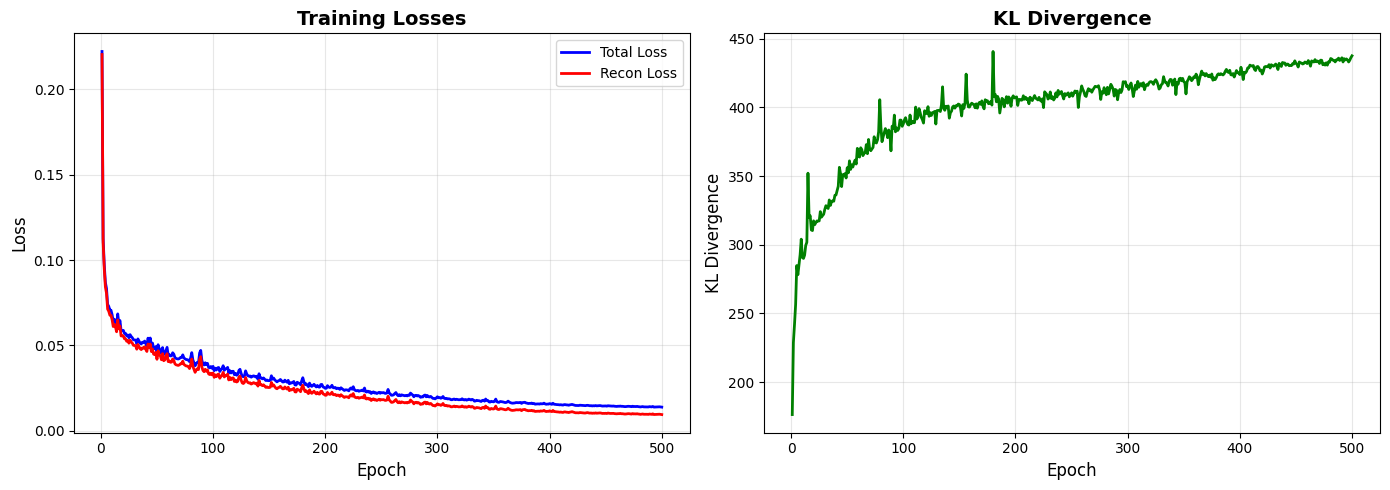

✓ Training history saved as 'vae_training_history.png'

✓ Final model saved as 'vae_final.pth'


In [34]:
print("\nInitializing training...")

# Create fresh VAE (or load from checkpoint if continuing)
vae = VAE(
    in_channels=3,
    latent_channels=4,
    hidden_dims=[64, 128, 256, 512]
).to(device)

# Train the VAE
# Start with 20 epochs - you can increase later
history = train_vae(
    vae=vae,
    dataloader=dataloader,
    num_epochs=500,  # Start with 20, can do more later
    lr=2e-4,
    kl_weight=0.00001  # Small KL weight to avoid posterior collapse
)

# Plot results
print("\nPlotting training history...")
plot_training_history(history)

# Save final model
torch.save(vae.state_dict(), 'vae_final.pth')
print("\n✓ Final model saved as 'vae_final.pth'")

In [35]:
class NoiseScheduler(nn.Module):
    def __init__(
        self,
        num_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        schedule_type="linear"
    ):
        super().__init__()
        self.num_timesteps = num_timesteps
        
        # Beta schedule
        if schedule_type == "linear":
            betas = torch.linspace(beta_start, beta_end, num_timesteps)
        else:
            betas = self._cosine_beta_schedule()
        
        # Register as buffers
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", 1.0 - betas)
        self.register_buffer("alphas_cumprod", torch.cumprod(self.alphas, dim=0))
        
        alphas_cumprod_prev = torch.cat([
            torch.tensor([1.0], dtype=torch.float32), 
            self.alphas_cumprod[:-1]
        ])
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)
        
        # Precompute sqrt values
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(self.alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - self.alphas_cumprod))
    
    def _cosine_beta_schedule(self, s=0.008):
        steps = self.num_timesteps + 1
        x = torch.linspace(0, self.num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0].clone()
        betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
        return torch.clip(betas, 0.0001, 0.9999)
    
    def add_noise(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        noisy = sqrt_alpha * x_0 + sqrt_one_minus * noise
        return noisy, noise
    
    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.num_timesteps, (batch_size,), device=self.betas.device)


In [36]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        freq = torch.exp(-np.log(10000) * torch.arange(half_dim, device=device) / (half_dim - 1))
        emb = t[:, None].float() * freq[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)


class TimeEmbeddingMLP(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )
    
    def forward(self, x):
        return self.mlp(x)

In [37]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = (query_dim // heads) ** -0.5
        
        self.to_q = nn.Linear(query_dim, query_dim)
        self.to_k = nn.Linear(context_dim, query_dim)
        self.to_v = nn.Linear(context_dim, query_dim)
        self.to_out = nn.Linear(query_dim, query_dim)
    
    def forward(self, x, context):
        B, L, C = x.shape
        h = self.heads
        
        q = self.to_q(x).reshape(B, L, h, C // h).transpose(1, 2)
        k = self.to_k(context).reshape(B, -1, h, C // h).transpose(1, 2)
        v = self.to_v(context).reshape(B, -1, h, C // h).transpose(1, 2)
        
        attn = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) * self.scale, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(B, L, C)
        
        return self.to_out(out)



In [38]:
class ResnetBlockWithCrossAttn(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, context_dim=None):
        super().__init__()
        
        self.norm1 = nn.GroupNorm(32, in_channels, eps=1e-6)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        
        # Time embedding
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)
        
        # Cross-attention
        self.use_cross_attn = context_dim is not None
        if self.use_cross_attn:
            self.norm_context = nn.GroupNorm(32, out_channels, eps=1e-6)
            self.cross_attn = CrossAttention(out_channels, context_dim)
        
        self.norm2 = nn.GroupNorm(32, out_channels, eps=1e-6)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, t_emb, context=None):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        
        # Add time
        h = h + self.time_emb_proj(F.silu(t_emb))[:, :, None, None]
        
        # Cross-attention
        if self.use_cross_attn and context is not None:
            B, C, H, W = h.shape
            h_norm = self.norm_context(h)
            h_flat = h_norm.reshape(B, C, H*W).transpose(1, 2)
            h_attn = self.cross_attn(h_flat, context)
            h = h + h_attn.transpose(1, 2).reshape(B, C, H, W)
        
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        
        return h + self.skip(x)

In [39]:
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        
        self.norm = nn.GroupNorm(32, channels, eps=1e-6)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)
    
    def forward(self, x):
        h = self.norm(x)
        b, c, h_dim, w = h.shape
        
        q = self.q(h).reshape(b, c, h_dim * w).permute(0, 2, 1)
        k = self.k(h).reshape(b, c, h_dim * w).permute(0, 2, 1)
        v = self.v(h).reshape(b, c, h_dim * w).permute(0, 2, 1)
        
        scale = c ** -0.5
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) * scale, dim=-1)
        h = torch.bmm(attn, v)
        h = h.permute(0, 2, 1).reshape(b, c, h_dim, w)
        h = self.proj_out(h)
        
        return x + h


In [40]:
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)
    
    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        x = self.conv(x)
        return x

In [41]:
class ImprovedUNet(nn.Module):
    def __init__(
        self,
        in_channels=4,
        out_channels=4,
        num_classes=18,
        base_channels=128,
        channel_multipliers=[1, 2, 3, 4],
        num_res_blocks=2,
        time_emb_dim=256,
        class_emb_dim=256,
        use_cross_attn=True,
    ):
        super().__init__()
        
        self.num_classes = num_classes
        
        # Time embedding
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        self.time_mlp = TimeEmbeddingMLP(time_emb_dim, time_emb_dim * 4)
        time_emb_dim_out = time_emb_dim * 4
        
        # Class embedding
        self.class_embedding = nn.Embedding(num_classes + 1, class_emb_dim)
        self.class_proj = nn.Sequential(
            nn.Linear(class_emb_dim, time_emb_dim_out),
            nn.SiLU(),
            nn.Linear(time_emb_dim_out, time_emb_dim_out)
        )
        
        context_dim = time_emb_dim_out if use_cross_attn else None
        
        # Initial conv
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        
        channels = [base_channels * mult for mult in channel_multipliers]
        
        # Encoder
        self.encoder_blocks = nn.ModuleList()
        self.encoder_downsamples = nn.ModuleList()
        
        ch_in = base_channels
        for i, ch_out in enumerate(channels):
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                use_attn = use_cross_attn and i >= 2
                blocks.append(ResnetBlockWithCrossAttn(
                    ch_in, ch_out, time_emb_dim_out, 
                    context_dim if use_attn else None
                ))
                ch_in = ch_out
            
            if i >= 2:
                blocks.append(AttentionBlock(ch_out))
            
            self.encoder_blocks.append(blocks)
            
            if i < len(channels) - 1:
                self.encoder_downsamples.append(Downsample(ch_out))
            else:
                self.encoder_downsamples.append(nn.Identity())
        
        # Bottleneck
        self.mid_block1 = ResnetBlockWithCrossAttn(channels[-1], channels[-1], time_emb_dim_out, context_dim)
        self.mid_attn = AttentionBlock(channels[-1])
        self.mid_block2 = ResnetBlockWithCrossAttn(channels[-1], channels[-1], time_emb_dim_out, context_dim)
        
        # Decoder
        self.decoder_blocks = nn.ModuleList()
        self.decoder_upsamples = nn.ModuleList()
        
        reversed_channels = list(reversed(channels))
        
        for i, ch_out in enumerate(reversed_channels):
            blocks = nn.ModuleList()
            
            for j in range(num_res_blocks + 1):
                if i == 0 and j == 0:
                    ch_in = reversed_channels[0] * 2
                elif j == 0:
                    ch_in = reversed_channels[i-1] + ch_out
                else:
                    ch_in = ch_out
                
                use_attn = use_cross_attn and i <= 1
                blocks.append(ResnetBlockWithCrossAttn(
                    ch_in, ch_out, time_emb_dim_out,
                    context_dim if use_attn else None
                ))
            
            if i <= 1:
                blocks.append(AttentionBlock(ch_out))
            
            self.decoder_blocks.append(blocks)
            
            if i < len(channels) - 1:
                self.decoder_upsamples.append(Upsample(ch_out))
            else:
                self.decoder_upsamples.append(nn.Identity())
        
        # Output
        self.norm_out = nn.GroupNorm(32, base_channels, eps=1e-6)
        self.conv_out = nn.Conv2d(base_channels, out_channels, 3, padding=1)
    
    def forward(self, x, timesteps, class_labels):
        # Time embedding
        t_emb = self.time_embedding(timesteps)
        t_emb = self.time_mlp(t_emb)
        
        # Class embedding
        c_emb = self.class_embedding(class_labels)
        c_emb_proj = self.class_proj(c_emb)
        
        # Combine time and class
        t_emb = t_emb + c_emb_proj
        context = c_emb_proj.unsqueeze(1)
        
        # Initial conv
        h = self.conv_in(x)
        
        # Encoder
        skip_connections = []
        for blocks, downsample in zip(self.encoder_blocks, self.encoder_downsamples):
            for block in blocks:
                if isinstance(block, ResnetBlockWithCrossAttn):
                    h = block(h, t_emb, context)
                else:
                    h = block(h)
            skip_connections.append(h)
            h = downsample(h)
        
        # Bottleneck
        h = self.mid_block1(h, t_emb, context)
        h = self.mid_attn(h)
        h = self.mid_block2(h, t_emb, context)
        
        # Decoder
        for blocks, upsample in zip(self.decoder_blocks, self.decoder_upsamples):
            for j, block in enumerate(blocks):
                if isinstance(block, ResnetBlockWithCrossAttn):
                    if j == 0 and skip_connections:
                        skip = skip_connections.pop()
                        h = torch.cat([h, skip], dim=1)
                    h = block(h, t_emb, context)
                else:
                    h = block(h)
            h = upsample(h)
        
        # Output
        h = self.norm_out(h)
        h = F.silu(h)
        h = self.conv_out(h)
        
        return h


In [42]:
class EMA:
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.detach().clone()
    
    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)
    
    def to_state_dict(self):
        return self.shadow
    
    @torch.no_grad()
    def copy_to(self, model):
        for name, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[name].to(p.device))



In [43]:
def train_with_cfg(
    unet,
    vae,
    scheduler,
    dataloader,
    num_epochs=200,
    lr=1e-4,
    cfg_dropout=0.1,
    device='cuda',
    checkpoint_dir='./checkpoints'
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Freeze VAE
    vae.eval()
    for p in vae.parameters():
        p.requires_grad = False
    
    # Optimizer
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr, weight_decay=1e-4)
    scheduler_lr = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    
    # Mixed precision
    scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
    
    # EMA
    ema = EMA(unet, 0.9999)
    
    best_loss = float('inf')
    global_step = 0
    
    print("=" * 80)
    print("TRAINING WITH CLASSIFIER-FREE GUIDANCE")
    print("=" * 80)
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {lr}")
    print(f"CFG dropout: {cfg_dropout}")
    print(f"Device: {device}")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        unet.train()
        epoch_loss = 0.0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in pbar:
            if isinstance(batch, (list, tuple)):
                images, labels = batch[0].to(device), batch[1].to(device)
            else:
                images = batch.to(device)
                labels = torch.zeros(images.shape[0], dtype=torch.long, device=device)
            
            # Encode to latents
            with torch.no_grad():
                mean, logvar = vae.encode(images)
                std = torch.exp(0.5 * logvar)
                latents = mean + std * torch.randn_like(std)
                latents = latents * 0.18215
            
            batch_size = latents.shape[0]
            
            # Classifier-free guidance: randomly drop labels
            uncond_mask = torch.rand(batch_size, device=device) < cfg_dropout
            labels = torch.where(
                uncond_mask,
                torch.full_like(labels, unet.num_classes),
                labels
            )
            
            # Sample timesteps and add noise
            t = scheduler.sample_timesteps(batch_size)
            noise = torch.randn_like(latents)
            noisy_latents, _ = scheduler.add_noise(latents, t, noise)
            
            # Forward pass
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                noise_pred = unet(noisy_latents, t, labels)
                loss = F.mse_loss(noise_pred, noise)
            
            # Backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            # Update EMA
            ema.update(unet)
            
            epoch_loss += loss.item()
            global_step += 1
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # End of epoch
        avg_loss = epoch_loss / len(dataloader)
        scheduler_lr.step()
        
        print(f"\nEpoch {epoch+1} - Avg Loss: {avg_loss:.4f}, LR: {scheduler_lr.get_last_lr()[0]:.6f}")
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            ckpt = {
                'epoch': epoch,
                'unet_state_dict': unet.state_dict(),
                'ema_state_dict': ema.to_state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(ckpt, os.path.join(checkpoint_dir, 'unet_best.pth'))
            print(f"✓ Saved best model (loss: {best_loss:.4f})")
        
        # Generate samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("Generating sample...")
            samples = sample_with_cfg(unet, vae, scheduler, class_label=0, guidance_scale=7.5, device=device)
            grid = make_grid((samples + 1) / 2, nrow=2)
            save_image(grid, os.path.join(checkpoint_dir, f'sample_epoch_{epoch+1}.png'))
            print(f"✓ Saved sample for epoch {epoch+1}")
    
    # Save final
    ema.copy_to(unet)
    torch.save(unet.state_dict(), os.path.join(checkpoint_dir, 'unet_final.pth'))
    print("\n✓ Training complete!")
    
    return unet



In [44]:
@torch.no_grad()
def sample_with_cfg(
    unet,
    vae,
    scheduler,
    class_label=0,
    num_samples=4,
    guidance_scale=7.5,
    num_steps=50,
    device='cuda'
):
    unet.eval()
    vae.eval()
    
    # FIXED: Correct latent dimensions
    latent_h = latent_w = 8  # 64x64 -> 8x8
    latent_channels = 4
    
    # Start from noise
    z = torch.randn(num_samples, latent_channels, latent_h, latent_w, device=device)
    
    # Prepare labels
    labels_cond = torch.tensor([class_label] * num_samples, device=device)
    labels_uncond = torch.tensor([unet.num_classes] * num_samples, device=device)
    
    # DDIM timestep schedule
    timesteps = torch.linspace(scheduler.num_timesteps - 1, 0, num_steps, device=device).long()
    
    for i, t in enumerate(tqdm(timesteps, desc="Sampling", leave=False)):
        t_batch = t.repeat(num_samples)
        
        # CFG
        noise_cond = unet(z, t_batch, labels_cond)
        noise_uncond = unet(z, t_batch, labels_uncond)
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
        
        # DDIM step
        alpha_t = scheduler.alphas_cumprod[t]
        if i < len(timesteps) - 1:
            alpha_t_prev = scheduler.alphas_cumprod[timesteps[i + 1]]
        else:
            alpha_t_prev = torch.tensor(1.0, device=device)
        
        pred_x0 = (z - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
        dir_zt = torch.sqrt(1 - alpha_t_prev) * noise_pred
        z = torch.sqrt(alpha_t_prev) * pred_x0 + dir_zt
    
    # Decode
    z = z / 0.18215
    images = vae.decode(z)
    
    return images.clamp(-1, 1)

In [46]:
# Initialize scheduler
scheduler = NoiseScheduler(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    schedule_type="cosine"  # Try cosine for better results
).to(device)

print("✓ Scheduler initialized")

# Initialize UNet
unet = ImprovedUNet(
    in_channels=4,
    out_channels=4,
    num_classes=dataset.num_classes,
    base_channels=128,
    channel_multipliers=[1, 2, 3, 4],
    num_res_blocks=2,
    use_cross_attn=True
).to(device)

print(f"✓ UNet initialized with {sum(p.numel() for p in unet.parameters())/1e6:.2f}M parameters")

# Train
print("\nStarting training...")
unet = train_with_cfg(
    unet=unet,
    vae=vae,
    scheduler=scheduler,
    dataloader=dataloader,
    num_epochs=500,
    lr=1e-4,
    cfg_dropout=0.1,
    device=device,
    checkpoint_dir='./checkpoints'
)

print("\n" + "="*80)
print("TRAINING FINISHED!")
print("="*80)

# Generate samples with different guidance scales
print("\nGenerating samples with different guidance scales...")
for guidance in [3.0, 7.5, 12.0]:
    samples = sample_with_cfg(
        unet, vae, scheduler,
        class_label=0,
        guidance_scale=guidance,
        num_steps=50,
        device=device
    )
    grid = make_grid((samples + 1) / 2, nrow=2)
    save_image(grid, f'samples_guidance_{guidance}.png')
    print(f"✓ Saved samples with guidance scale {guidance}")

print("\n✓ All done! Check the ./checkpoints/ folder for results.")

✓ Scheduler initialized


/tmp/ipykernel_47/2928953228.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))


✓ UNet initialized with 96.49M parameters

Starting training...
TRAINING WITH CLASSIFIER-FREE GUIDANCE
Epochs: 500
Learning rate: 0.0001
CFG dropout: 0.1
Device: cuda


Epoch 1/500:   0%|          | 0/51 [00:00<?, ?it/s]/tmp/ipykernel_47/2928953228.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
Epoch 1/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.2034]



Epoch 1 - Avg Loss: 0.4650, LR: 0.000100
✓ Saved best model (loss: 0.4650)


Epoch 2/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1476]



Epoch 2 - Avg Loss: 0.2187, LR: 0.000100
✓ Saved best model (loss: 0.2187)


Epoch 3/500: 100%|██████████| 51/51 [00:05<00:00,  9.29it/s, loss=0.3696]



Epoch 3 - Avg Loss: 0.1962, LR: 0.000100
✓ Saved best model (loss: 0.1962)


Epoch 4/500: 100%|██████████| 51/51 [00:05<00:00,  9.27it/s, loss=0.2414]



Epoch 4 - Avg Loss: 0.1611, LR: 0.000100
✓ Saved best model (loss: 0.1611)


Epoch 5/500: 100%|██████████| 51/51 [00:05<00:00,  9.12it/s, loss=0.0750]



Epoch 5 - Avg Loss: 0.1802, LR: 0.000100


Epoch 6/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1005]



Epoch 6 - Avg Loss: 0.1585, LR: 0.000100
✓ Saved best model (loss: 0.1585)


Epoch 7/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1276]



Epoch 7 - Avg Loss: 0.1463, LR: 0.000100
✓ Saved best model (loss: 0.1463)


Epoch 8/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1068]



Epoch 8 - Avg Loss: 0.1501, LR: 0.000100


Epoch 9/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1381]



Epoch 9 - Avg Loss: 0.1650, LR: 0.000100


Epoch 10/500: 100%|██████████| 51/51 [00:05<00:00,  9.68it/s, loss=0.0962]



Epoch 10 - Avg Loss: 0.1588, LR: 0.000100
Generating sample...


✓ Saved sample for epoch 10


Epoch 11/500: 100%|██████████| 51/51 [00:05<00:00,  9.66it/s, loss=0.1133]



Epoch 11 - Avg Loss: 0.1440, LR: 0.000100
✓ Saved best model (loss: 0.1440)


Epoch 12/500: 100%|██████████| 51/51 [00:05<00:00,  8.89it/s, loss=0.0862]



Epoch 12 - Avg Loss: 0.1392, LR: 0.000100
✓ Saved best model (loss: 0.1392)


Epoch 13/500: 100%|██████████| 51/51 [00:05<00:00,  9.36it/s, loss=0.2530]



Epoch 13 - Avg Loss: 0.1341, LR: 0.000100
✓ Saved best model (loss: 0.1341)


Epoch 14/500: 100%|██████████| 51/51 [00:05<00:00,  9.31it/s, loss=0.2565]



Epoch 14 - Avg Loss: 0.1571, LR: 0.000100


Epoch 15/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1851]



Epoch 15 - Avg Loss: 0.1464, LR: 0.000100


Epoch 16/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1483]



Epoch 16 - Avg Loss: 0.1510, LR: 0.000100


Epoch 17/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.0440]



Epoch 17 - Avg Loss: 0.1408, LR: 0.000100


Epoch 18/500: 100%|██████████| 51/51 [00:05<00:00,  9.26it/s, loss=0.1581]



Epoch 18 - Avg Loss: 0.1465, LR: 0.000100


Epoch 19/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0764]



Epoch 19 - Avg Loss: 0.1349, LR: 0.000100


Epoch 20/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0754]



Epoch 20 - Avg Loss: 0.1418, LR: 0.000100
Generating sample...


✓ Saved sample for epoch 20


Epoch 21/500: 100%|██████████| 51/51 [00:05<00:00,  9.29it/s, loss=0.0428]



Epoch 21 - Avg Loss: 0.1496, LR: 0.000100


Epoch 22/500: 100%|██████████| 51/51 [00:05<00:00,  9.35it/s, loss=0.0798]



Epoch 22 - Avg Loss: 0.1378, LR: 0.000100


Epoch 23/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.1480]



Epoch 23 - Avg Loss: 0.1441, LR: 0.000099


Epoch 24/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.2059]



Epoch 24 - Avg Loss: 0.1451, LR: 0.000099


Epoch 25/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1157]



Epoch 25 - Avg Loss: 0.1380, LR: 0.000099


Epoch 26/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.2628]



Epoch 26 - Avg Loss: 0.1379, LR: 0.000099


Epoch 27/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0747]



Epoch 27 - Avg Loss: 0.1372, LR: 0.000099


Epoch 28/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1057]



Epoch 28 - Avg Loss: 0.1237, LR: 0.000099
✓ Saved best model (loss: 0.1237)


Epoch 29/500: 100%|██████████| 51/51 [00:05<00:00,  9.24it/s, loss=0.0796]



Epoch 29 - Avg Loss: 0.1388, LR: 0.000099


Epoch 30/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1262]



Epoch 30 - Avg Loss: 0.1325, LR: 0.000099
Generating sample...


✓ Saved sample for epoch 30


Epoch 31/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1279]



Epoch 31 - Avg Loss: 0.1433, LR: 0.000099


Epoch 32/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.2748]



Epoch 32 - Avg Loss: 0.1398, LR: 0.000099


Epoch 33/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1639]



Epoch 33 - Avg Loss: 0.1391, LR: 0.000099


Epoch 34/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0404]



Epoch 34 - Avg Loss: 0.1430, LR: 0.000099


Epoch 35/500: 100%|██████████| 51/51 [00:05<00:00,  8.93it/s, loss=0.1055]



Epoch 35 - Avg Loss: 0.1420, LR: 0.000099


Epoch 36/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0816]



Epoch 36 - Avg Loss: 0.1424, LR: 0.000099


Epoch 37/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0672]



Epoch 37 - Avg Loss: 0.1345, LR: 0.000099


Epoch 38/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.2395]



Epoch 38 - Avg Loss: 0.1464, LR: 0.000099


Epoch 39/500: 100%|██████████| 51/51 [00:05<00:00,  9.30it/s, loss=0.1286]



Epoch 39 - Avg Loss: 0.1435, LR: 0.000099


Epoch 40/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.2397]



Epoch 40 - Avg Loss: 0.1474, LR: 0.000098
Generating sample...


✓ Saved sample for epoch 40


Epoch 41/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1077]



Epoch 41 - Avg Loss: 0.1467, LR: 0.000098


Epoch 42/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1245]



Epoch 42 - Avg Loss: 0.1507, LR: 0.000098


Epoch 43/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0956]



Epoch 43 - Avg Loss: 0.1442, LR: 0.000098


Epoch 44/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.0344]



Epoch 44 - Avg Loss: 0.1243, LR: 0.000098


Epoch 45/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0832]



Epoch 45 - Avg Loss: 0.1264, LR: 0.000098


Epoch 46/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.2042]



Epoch 46 - Avg Loss: 0.1523, LR: 0.000098


Epoch 47/500: 100%|██████████| 51/51 [00:05<00:00,  9.31it/s, loss=0.1594]



Epoch 47 - Avg Loss: 0.1343, LR: 0.000098


Epoch 48/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.0682]



Epoch 48 - Avg Loss: 0.1295, LR: 0.000098


Epoch 49/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.1221]



Epoch 49 - Avg Loss: 0.1414, LR: 0.000098


Epoch 50/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1441]



Epoch 50 - Avg Loss: 0.1406, LR: 0.000098
Generating sample...


✓ Saved sample for epoch 50


Epoch 51/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1379]



Epoch 51 - Avg Loss: 0.1324, LR: 0.000097


Epoch 52/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.3285]



Epoch 52 - Avg Loss: 0.1496, LR: 0.000097


Epoch 53/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0450]



Epoch 53 - Avg Loss: 0.1381, LR: 0.000097


Epoch 54/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1159]



Epoch 54 - Avg Loss: 0.1431, LR: 0.000097


Epoch 55/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0520]



Epoch 55 - Avg Loss: 0.1377, LR: 0.000097


Epoch 56/500: 100%|██████████| 51/51 [00:05<00:00,  9.25it/s, loss=0.0623]



Epoch 56 - Avg Loss: 0.1271, LR: 0.000097


Epoch 57/500: 100%|██████████| 51/51 [00:05<00:00,  9.68it/s, loss=0.1422]



Epoch 57 - Avg Loss: 0.1355, LR: 0.000097


Epoch 58/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.2620]



Epoch 58 - Avg Loss: 0.1345, LR: 0.000097


Epoch 59/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0994]



Epoch 59 - Avg Loss: 0.1248, LR: 0.000097


Epoch 60/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1974]



Epoch 60 - Avg Loss: 0.1388, LR: 0.000096
Generating sample...


✓ Saved sample for epoch 60


Epoch 61/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.1190]



Epoch 61 - Avg Loss: 0.1378, LR: 0.000096


Epoch 62/500: 100%|██████████| 51/51 [00:05<00:00,  9.06it/s, loss=0.1634]



Epoch 62 - Avg Loss: 0.1494, LR: 0.000096


Epoch 63/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.1145]



Epoch 63 - Avg Loss: 0.1313, LR: 0.000096


Epoch 64/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1445]



Epoch 64 - Avg Loss: 0.1270, LR: 0.000096


Epoch 65/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0738]



Epoch 65 - Avg Loss: 0.1308, LR: 0.000096


Epoch 66/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.1708]



Epoch 66 - Avg Loss: 0.1284, LR: 0.000096


Epoch 67/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1295]



Epoch 67 - Avg Loss: 0.1562, LR: 0.000096


Epoch 68/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0460]



Epoch 68 - Avg Loss: 0.1279, LR: 0.000096


Epoch 69/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0460]



Epoch 69 - Avg Loss: 0.1212, LR: 0.000095
✓ Saved best model (loss: 0.1212)


Epoch 70/500: 100%|██████████| 51/51 [00:05<00:00,  9.27it/s, loss=0.0374]



Epoch 70 - Avg Loss: 0.1330, LR: 0.000095
Generating sample...


✓ Saved sample for epoch 70


Epoch 71/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.0695]



Epoch 71 - Avg Loss: 0.1309, LR: 0.000095


Epoch 72/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.1051]



Epoch 72 - Avg Loss: 0.1388, LR: 0.000095


Epoch 73/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.0950]



Epoch 73 - Avg Loss: 0.1372, LR: 0.000095


Epoch 74/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1612]



Epoch 74 - Avg Loss: 0.1466, LR: 0.000095


Epoch 75/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1433]



Epoch 75 - Avg Loss: 0.1287, LR: 0.000095


Epoch 76/500: 100%|██████████| 51/51 [00:05<00:00,  9.69it/s, loss=0.0605]



Epoch 76 - Avg Loss: 0.1247, LR: 0.000094


Epoch 77/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0938]



Epoch 77 - Avg Loss: 0.1468, LR: 0.000094


Epoch 78/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0598]



Epoch 78 - Avg Loss: 0.1234, LR: 0.000094


Epoch 79/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1040]



Epoch 79 - Avg Loss: 0.1349, LR: 0.000094


Epoch 80/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0420]



Epoch 80 - Avg Loss: 0.1265, LR: 0.000094
Generating sample...


✓ Saved sample for epoch 80


Epoch 81/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.1420]



Epoch 81 - Avg Loss: 0.1346, LR: 0.000094


Epoch 82/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0944]



Epoch 82 - Avg Loss: 0.1322, LR: 0.000094


Epoch 83/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1735]



Epoch 83 - Avg Loss: 0.1341, LR: 0.000093


Epoch 84/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1034]



Epoch 84 - Avg Loss: 0.1311, LR: 0.000093


Epoch 85/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1703]



Epoch 85 - Avg Loss: 0.1386, LR: 0.000093


Epoch 86/500: 100%|██████████| 51/51 [00:05<00:00,  9.08it/s, loss=0.0860]



Epoch 86 - Avg Loss: 0.1351, LR: 0.000093


Epoch 87/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.1673]



Epoch 87 - Avg Loss: 0.1230, LR: 0.000093


Epoch 88/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1846]



Epoch 88 - Avg Loss: 0.1323, LR: 0.000093


Epoch 89/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0892]



Epoch 89 - Avg Loss: 0.1414, LR: 0.000092


Epoch 90/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1656]



Epoch 90 - Avg Loss: 0.1297, LR: 0.000092
Generating sample...


✓ Saved sample for epoch 90


Epoch 91/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1941]



Epoch 91 - Avg Loss: 0.1392, LR: 0.000092


Epoch 92/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0892]



Epoch 92 - Avg Loss: 0.1357, LR: 0.000092


Epoch 93/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.0470]



Epoch 93 - Avg Loss: 0.1287, LR: 0.000092


Epoch 94/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.2265]



Epoch 94 - Avg Loss: 0.1384, LR: 0.000092


Epoch 95/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1265]



Epoch 95 - Avg Loss: 0.1320, LR: 0.000091


Epoch 96/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0668]



Epoch 96 - Avg Loss: 0.1332, LR: 0.000091


Epoch 97/500: 100%|██████████| 51/51 [00:05<00:00,  9.22it/s, loss=0.1095]



Epoch 97 - Avg Loss: 0.1427, LR: 0.000091


Epoch 98/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.3106]



Epoch 98 - Avg Loss: 0.1345, LR: 0.000091


Epoch 99/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.2334]



Epoch 99 - Avg Loss: 0.1277, LR: 0.000091


Epoch 100/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0857]



Epoch 100 - Avg Loss: 0.1156, LR: 0.000090
✓ Saved best model (loss: 0.1156)
Generating sample...


✓ Saved sample for epoch 100


Epoch 101/500: 100%|██████████| 51/51 [00:05<00:00,  9.30it/s, loss=0.2138]



Epoch 101 - Avg Loss: 0.1390, LR: 0.000090


Epoch 102/500: 100%|██████████| 51/51 [00:05<00:00,  9.32it/s, loss=0.1646]



Epoch 102 - Avg Loss: 0.1440, LR: 0.000090


Epoch 103/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1848]



Epoch 103 - Avg Loss: 0.1377, LR: 0.000090


Epoch 104/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.2419]



Epoch 104 - Avg Loss: 0.1382, LR: 0.000090


Epoch 105/500: 100%|██████████| 51/51 [00:05<00:00,  9.70it/s, loss=0.1380]



Epoch 105 - Avg Loss: 0.1305, LR: 0.000090


Epoch 106/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0196]



Epoch 106 - Avg Loss: 0.1196, LR: 0.000089


Epoch 107/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1801]



Epoch 107 - Avg Loss: 0.1325, LR: 0.000089


Epoch 108/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.0970]



Epoch 108 - Avg Loss: 0.1350, LR: 0.000089


Epoch 109/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0803]



Epoch 109 - Avg Loss: 0.1393, LR: 0.000089


Epoch 110/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0584]



Epoch 110 - Avg Loss: 0.1297, LR: 0.000089
Generating sample...


✓ Saved sample for epoch 110


Epoch 111/500: 100%|██████████| 51/51 [00:05<00:00,  9.08it/s, loss=0.1488]



Epoch 111 - Avg Loss: 0.1265, LR: 0.000088


Epoch 112/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1610]



Epoch 112 - Avg Loss: 0.1254, LR: 0.000088


Epoch 113/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1914]



Epoch 113 - Avg Loss: 0.1328, LR: 0.000088


Epoch 114/500: 100%|██████████| 51/51 [00:05<00:00,  9.67it/s, loss=0.1970]



Epoch 114 - Avg Loss: 0.1283, LR: 0.000088


Epoch 115/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.2139]



Epoch 115 - Avg Loss: 0.1299, LR: 0.000088


Epoch 116/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.2557]



Epoch 116 - Avg Loss: 0.1217, LR: 0.000087


Epoch 117/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.0860]



Epoch 117 - Avg Loss: 0.1245, LR: 0.000087


Epoch 118/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0645]



Epoch 118 - Avg Loss: 0.1233, LR: 0.000087


Epoch 119/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1272]



Epoch 119 - Avg Loss: 0.1284, LR: 0.000087


Epoch 120/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.1367]



Epoch 120 - Avg Loss: 0.1404, LR: 0.000086
Generating sample...


✓ Saved sample for epoch 120


Epoch 121/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.2283]



Epoch 121 - Avg Loss: 0.1213, LR: 0.000086


Epoch 122/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.1292]



Epoch 122 - Avg Loss: 0.1380, LR: 0.000086


Epoch 123/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1970]



Epoch 123 - Avg Loss: 0.1399, LR: 0.000086


Epoch 124/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.1262]



Epoch 124 - Avg Loss: 0.1355, LR: 0.000086


Epoch 125/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0554]



Epoch 125 - Avg Loss: 0.1200, LR: 0.000085


Epoch 126/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.1409]



Epoch 126 - Avg Loss: 0.1387, LR: 0.000085


Epoch 127/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.2258]



Epoch 127 - Avg Loss: 0.1219, LR: 0.000085


Epoch 128/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0697]



Epoch 128 - Avg Loss: 0.1253, LR: 0.000085


Epoch 129/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1740]



Epoch 129 - Avg Loss: 0.1282, LR: 0.000084


Epoch 130/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1484]



Epoch 130 - Avg Loss: 0.1378, LR: 0.000084
Generating sample...


✓ Saved sample for epoch 130


Epoch 131/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.0764]



Epoch 131 - Avg Loss: 0.1404, LR: 0.000084


Epoch 132/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.2023]



Epoch 132 - Avg Loss: 0.1308, LR: 0.000084


Epoch 133/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0510]



Epoch 133 - Avg Loss: 0.1223, LR: 0.000084


Epoch 134/500: 100%|██████████| 51/51 [00:05<00:00,  9.33it/s, loss=0.0280]



Epoch 134 - Avg Loss: 0.1259, LR: 0.000083


Epoch 135/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.1527]



Epoch 135 - Avg Loss: 0.1220, LR: 0.000083


Epoch 136/500: 100%|██████████| 51/51 [00:05<00:00,  9.65it/s, loss=0.1425]



Epoch 136 - Avg Loss: 0.1298, LR: 0.000083


Epoch 137/500: 100%|██████████| 51/51 [00:05<00:00,  8.97it/s, loss=0.0508]



Epoch 137 - Avg Loss: 0.1194, LR: 0.000083


Epoch 138/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.1280]



Epoch 138 - Avg Loss: 0.1265, LR: 0.000082


Epoch 139/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.2267]



Epoch 139 - Avg Loss: 0.1278, LR: 0.000082


Epoch 140/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.2180]



Epoch 140 - Avg Loss: 0.1285, LR: 0.000082
Generating sample...


✓ Saved sample for epoch 140


Epoch 141/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.2122]



Epoch 141 - Avg Loss: 0.1231, LR: 0.000082


Epoch 142/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1283]



Epoch 142 - Avg Loss: 0.1336, LR: 0.000081


Epoch 143/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0612]



Epoch 143 - Avg Loss: 0.1316, LR: 0.000081


Epoch 144/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1002]



Epoch 144 - Avg Loss: 0.1278, LR: 0.000081


Epoch 145/500: 100%|██████████| 51/51 [00:05<00:00,  9.36it/s, loss=0.1768]



Epoch 145 - Avg Loss: 0.1309, LR: 0.000081


Epoch 146/500: 100%|██████████| 51/51 [00:05<00:00,  9.70it/s, loss=0.3511]



Epoch 146 - Avg Loss: 0.1378, LR: 0.000080


Epoch 147/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1661]



Epoch 147 - Avg Loss: 0.1337, LR: 0.000080


Epoch 148/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.1036]



Epoch 148 - Avg Loss: 0.1330, LR: 0.000080


Epoch 149/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.2592]



Epoch 149 - Avg Loss: 0.1423, LR: 0.000080


Epoch 150/500: 100%|██████████| 51/51 [00:05<00:00,  9.24it/s, loss=0.0138]



Epoch 150 - Avg Loss: 0.1314, LR: 0.000079
Generating sample...


✓ Saved sample for epoch 150


Epoch 151/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.0864]



Epoch 151 - Avg Loss: 0.1320, LR: 0.000079


Epoch 152/500: 100%|██████████| 51/51 [00:05<00:00,  9.64it/s, loss=0.0244]



Epoch 152 - Avg Loss: 0.1239, LR: 0.000079


Epoch 153/500: 100%|██████████| 51/51 [00:05<00:00,  9.31it/s, loss=0.0399]



Epoch 153 - Avg Loss: 0.1159, LR: 0.000079


Epoch 154/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.1344]



Epoch 154 - Avg Loss: 0.1383, LR: 0.000078


Epoch 155/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0451]



Epoch 155 - Avg Loss: 0.1277, LR: 0.000078


Epoch 156/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1761]



Epoch 156 - Avg Loss: 0.1312, LR: 0.000078


Epoch 157/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.0276]



Epoch 157 - Avg Loss: 0.1331, LR: 0.000078


Epoch 158/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.1869]



Epoch 158 - Avg Loss: 0.1303, LR: 0.000077


Epoch 159/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.0688]



Epoch 159 - Avg Loss: 0.1193, LR: 0.000077


Epoch 160/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1096]



Epoch 160 - Avg Loss: 0.1295, LR: 0.000077
Generating sample...


✓ Saved sample for epoch 160


Epoch 161/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.0881]



Epoch 161 - Avg Loss: 0.1142, LR: 0.000077
✓ Saved best model (loss: 0.1142)


Epoch 162/500: 100%|██████████| 51/51 [00:05<00:00,  9.01it/s, loss=0.0436]



Epoch 162 - Avg Loss: 0.1284, LR: 0.000076


Epoch 163/500: 100%|██████████| 51/51 [00:05<00:00,  9.22it/s, loss=0.0160]



Epoch 163 - Avg Loss: 0.1294, LR: 0.000076


Epoch 164/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.2187]



Epoch 164 - Avg Loss: 0.1234, LR: 0.000076


Epoch 165/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.1089]



Epoch 165 - Avg Loss: 0.1232, LR: 0.000075


Epoch 166/500: 100%|██████████| 51/51 [00:05<00:00,  9.62it/s, loss=0.1199]



Epoch 166 - Avg Loss: 0.1306, LR: 0.000075


Epoch 167/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0757]



Epoch 167 - Avg Loss: 0.1159, LR: 0.000075


Epoch 168/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.1297]



Epoch 168 - Avg Loss: 0.1250, LR: 0.000075


Epoch 169/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.3047]



Epoch 169 - Avg Loss: 0.1369, LR: 0.000074


Epoch 170/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1271]



Epoch 170 - Avg Loss: 0.1249, LR: 0.000074
Generating sample...


✓ Saved sample for epoch 170


Epoch 171/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.1320]



Epoch 171 - Avg Loss: 0.1326, LR: 0.000074


Epoch 172/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.1279]



Epoch 172 - Avg Loss: 0.1314, LR: 0.000074


Epoch 173/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.0261]



Epoch 173 - Avg Loss: 0.1246, LR: 0.000073


Epoch 174/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.0354]



Epoch 174 - Avg Loss: 0.1220, LR: 0.000073


Epoch 175/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.2349]



Epoch 175 - Avg Loss: 0.1454, LR: 0.000073


Epoch 176/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1934]



Epoch 176 - Avg Loss: 0.1229, LR: 0.000072


Epoch 177/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.1412]



Epoch 177 - Avg Loss: 0.1290, LR: 0.000072


Epoch 178/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.3115]



Epoch 178 - Avg Loss: 0.1247, LR: 0.000072


Epoch 179/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1343]



Epoch 179 - Avg Loss: 0.1224, LR: 0.000072


Epoch 180/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1227]



Epoch 180 - Avg Loss: 0.1277, LR: 0.000071
Generating sample...


✓ Saved sample for epoch 180


Epoch 181/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0651]



Epoch 181 - Avg Loss: 0.1345, LR: 0.000071


Epoch 182/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1737]



Epoch 182 - Avg Loss: 0.1240, LR: 0.000071


Epoch 183/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.2391]



Epoch 183 - Avg Loss: 0.1254, LR: 0.000070


Epoch 184/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.1802]



Epoch 184 - Avg Loss: 0.1281, LR: 0.000070


Epoch 185/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1964]



Epoch 185 - Avg Loss: 0.1419, LR: 0.000070


Epoch 186/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.2288]



Epoch 186 - Avg Loss: 0.1245, LR: 0.000070


Epoch 187/500: 100%|██████████| 51/51 [00:05<00:00,  9.69it/s, loss=0.0520]



Epoch 187 - Avg Loss: 0.1305, LR: 0.000069


Epoch 188/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.0562]



Epoch 188 - Avg Loss: 0.1275, LR: 0.000069


Epoch 189/500: 100%|██████████| 51/51 [00:05<00:00,  8.85it/s, loss=0.0288]



Epoch 189 - Avg Loss: 0.1135, LR: 0.000069
✓ Saved best model (loss: 0.1135)


Epoch 190/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.1347]



Epoch 190 - Avg Loss: 0.1414, LR: 0.000068
Generating sample...


✓ Saved sample for epoch 190


Epoch 191/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.0343]



Epoch 191 - Avg Loss: 0.1267, LR: 0.000068


Epoch 192/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0162]



Epoch 192 - Avg Loss: 0.1304, LR: 0.000068


Epoch 193/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1476]



Epoch 193 - Avg Loss: 0.1282, LR: 0.000068


Epoch 194/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0263]



Epoch 194 - Avg Loss: 0.1213, LR: 0.000067


Epoch 195/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.0864]



Epoch 195 - Avg Loss: 0.1345, LR: 0.000067


Epoch 196/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.2347]



Epoch 196 - Avg Loss: 0.1314, LR: 0.000067


Epoch 197/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0402]



Epoch 197 - Avg Loss: 0.1261, LR: 0.000066


Epoch 198/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.1369]



Epoch 198 - Avg Loss: 0.1234, LR: 0.000066


Epoch 199/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.0442]



Epoch 199 - Avg Loss: 0.1363, LR: 0.000066


Epoch 200/500: 100%|██████████| 51/51 [00:05<00:00,  9.65it/s, loss=0.0938]



Epoch 200 - Avg Loss: 0.1345, LR: 0.000065
Generating sample...


✓ Saved sample for epoch 200


Epoch 201/500: 100%|██████████| 51/51 [00:05<00:00,  9.62it/s, loss=0.0335]



Epoch 201 - Avg Loss: 0.1291, LR: 0.000065


Epoch 202/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0291]



Epoch 202 - Avg Loss: 0.1273, LR: 0.000065


Epoch 203/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.1302]



Epoch 203 - Avg Loss: 0.1231, LR: 0.000065


Epoch 204/500: 100%|██████████| 51/51 [00:05<00:00,  9.35it/s, loss=0.0231]



Epoch 204 - Avg Loss: 0.1152, LR: 0.000064


Epoch 205/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.0804]



Epoch 205 - Avg Loss: 0.1277, LR: 0.000064


Epoch 206/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0711]



Epoch 206 - Avg Loss: 0.1340, LR: 0.000064


Epoch 207/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1280]



Epoch 207 - Avg Loss: 0.1290, LR: 0.000063


Epoch 208/500: 100%|██████████| 51/51 [00:05<00:00,  9.31it/s, loss=0.0764]



Epoch 208 - Avg Loss: 0.1222, LR: 0.000063


Epoch 209/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.1590]



Epoch 209 - Avg Loss: 0.1116, LR: 0.000063
✓ Saved best model (loss: 0.1116)


Epoch 210/500: 100%|██████████| 51/51 [00:05<00:00,  9.25it/s, loss=0.0739]



Epoch 210 - Avg Loss: 0.1055, LR: 0.000062
✓ Saved best model (loss: 0.1055)
Generating sample...


✓ Saved sample for epoch 210


Epoch 211/500: 100%|██████████| 51/51 [00:05<00:00,  9.17it/s, loss=0.1498]



Epoch 211 - Avg Loss: 0.1176, LR: 0.000062


Epoch 212/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.2547]



Epoch 212 - Avg Loss: 0.1248, LR: 0.000062


Epoch 213/500: 100%|██████████| 51/51 [00:05<00:00,  9.04it/s, loss=0.1444]



Epoch 213 - Avg Loss: 0.1323, LR: 0.000062


Epoch 214/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0425]



Epoch 214 - Avg Loss: 0.1402, LR: 0.000061


Epoch 215/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.0549]



Epoch 215 - Avg Loss: 0.1339, LR: 0.000061


Epoch 216/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.2074]



Epoch 216 - Avg Loss: 0.1330, LR: 0.000061


Epoch 217/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1141]



Epoch 217 - Avg Loss: 0.1231, LR: 0.000060


Epoch 218/500: 100%|██████████| 51/51 [00:05<00:00,  9.62it/s, loss=0.1298]



Epoch 218 - Avg Loss: 0.1254, LR: 0.000060


Epoch 219/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.1735]



Epoch 219 - Avg Loss: 0.1289, LR: 0.000060


Epoch 220/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1579]



Epoch 220 - Avg Loss: 0.1355, LR: 0.000059
Generating sample...


✓ Saved sample for epoch 220


Epoch 221/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1239]



Epoch 221 - Avg Loss: 0.1342, LR: 0.000059


Epoch 222/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.0785]



Epoch 222 - Avg Loss: 0.1274, LR: 0.000059


Epoch 223/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1223]



Epoch 223 - Avg Loss: 0.1103, LR: 0.000058


Epoch 224/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.2300]



Epoch 224 - Avg Loss: 0.1313, LR: 0.000058


Epoch 225/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1655]



Epoch 225 - Avg Loss: 0.1242, LR: 0.000058


Epoch 226/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.2078]



Epoch 226 - Avg Loss: 0.1242, LR: 0.000058


Epoch 227/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.1250]



Epoch 227 - Avg Loss: 0.1151, LR: 0.000057


Epoch 228/500: 100%|██████████| 51/51 [00:05<00:00,  9.32it/s, loss=0.0650]



Epoch 228 - Avg Loss: 0.1305, LR: 0.000057


Epoch 229/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.0587]



Epoch 229 - Avg Loss: 0.1142, LR: 0.000057


Epoch 230/500: 100%|██████████| 51/51 [00:05<00:00,  9.35it/s, loss=0.1649]



Epoch 230 - Avg Loss: 0.1241, LR: 0.000056
Generating sample...


✓ Saved sample for epoch 230


Epoch 231/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.4223]



Epoch 231 - Avg Loss: 0.1234, LR: 0.000056


Epoch 232/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0417]



Epoch 232 - Avg Loss: 0.1260, LR: 0.000056


Epoch 233/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0308]



Epoch 233 - Avg Loss: 0.1227, LR: 0.000055


Epoch 234/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0992]



Epoch 234 - Avg Loss: 0.1073, LR: 0.000055


Epoch 235/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0370]



Epoch 235 - Avg Loss: 0.1202, LR: 0.000055


Epoch 236/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.1499]



Epoch 236 - Avg Loss: 0.1093, LR: 0.000054


Epoch 237/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.0535]



Epoch 237 - Avg Loss: 0.1341, LR: 0.000054


Epoch 238/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1848]



Epoch 238 - Avg Loss: 0.1324, LR: 0.000054


Epoch 239/500: 100%|██████████| 51/51 [00:05<00:00,  9.03it/s, loss=0.1918]



Epoch 239 - Avg Loss: 0.1188, LR: 0.000053


Epoch 240/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1711]



Epoch 240 - Avg Loss: 0.1261, LR: 0.000053
Generating sample...


✓ Saved sample for epoch 240


Epoch 241/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0177]



Epoch 241 - Avg Loss: 0.1333, LR: 0.000053


Epoch 242/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0371]



Epoch 242 - Avg Loss: 0.1248, LR: 0.000053


Epoch 243/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1637]



Epoch 243 - Avg Loss: 0.1356, LR: 0.000052


Epoch 244/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.0196]



Epoch 244 - Avg Loss: 0.1168, LR: 0.000052


Epoch 245/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1691]



Epoch 245 - Avg Loss: 0.1218, LR: 0.000052


Epoch 246/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.2284]



Epoch 246 - Avg Loss: 0.1297, LR: 0.000051


Epoch 247/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.2152]



Epoch 247 - Avg Loss: 0.1238, LR: 0.000051


Epoch 248/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1459]



Epoch 248 - Avg Loss: 0.1346, LR: 0.000051


Epoch 249/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0768]



Epoch 249 - Avg Loss: 0.1187, LR: 0.000050


Epoch 250/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.0617]



Epoch 250 - Avg Loss: 0.1238, LR: 0.000050
Generating sample...


✓ Saved sample for epoch 250


Epoch 251/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0486]



Epoch 251 - Avg Loss: 0.1087, LR: 0.000050


Epoch 252/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1480]



Epoch 252 - Avg Loss: 0.1303, LR: 0.000049


Epoch 253/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1154]



Epoch 253 - Avg Loss: 0.1393, LR: 0.000049


Epoch 254/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0672]



Epoch 254 - Avg Loss: 0.1276, LR: 0.000049


Epoch 255/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0501]



Epoch 255 - Avg Loss: 0.1348, LR: 0.000048


Epoch 256/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0904]



Epoch 256 - Avg Loss: 0.1127, LR: 0.000048


Epoch 257/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1669]



Epoch 257 - Avg Loss: 0.1241, LR: 0.000048


Epoch 258/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0782]



Epoch 258 - Avg Loss: 0.1335, LR: 0.000047


Epoch 259/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0821]



Epoch 259 - Avg Loss: 0.1161, LR: 0.000047


Epoch 260/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1648]



Epoch 260 - Avg Loss: 0.1411, LR: 0.000047
Generating sample...


✓ Saved sample for epoch 260


Epoch 261/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1672]



Epoch 261 - Avg Loss: 0.1335, LR: 0.000047


Epoch 262/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0940]



Epoch 262 - Avg Loss: 0.1416, LR: 0.000046


Epoch 263/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.1937]



Epoch 263 - Avg Loss: 0.1276, LR: 0.000046


Epoch 264/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1247]



Epoch 264 - Avg Loss: 0.1244, LR: 0.000046


Epoch 265/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.0572]



Epoch 265 - Avg Loss: 0.1209, LR: 0.000045


Epoch 266/500: 100%|██████████| 51/51 [00:05<00:00,  8.92it/s, loss=0.2292]



Epoch 266 - Avg Loss: 0.1322, LR: 0.000045


Epoch 267/500: 100%|██████████| 51/51 [00:05<00:00,  9.33it/s, loss=0.1978]



Epoch 267 - Avg Loss: 0.1139, LR: 0.000045


Epoch 268/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1442]



Epoch 268 - Avg Loss: 0.1402, LR: 0.000044


Epoch 269/500: 100%|██████████| 51/51 [00:05<00:00,  9.22it/s, loss=0.2402]



Epoch 269 - Avg Loss: 0.1271, LR: 0.000044


Epoch 270/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.0502]



Epoch 270 - Avg Loss: 0.1116, LR: 0.000044
Generating sample...


✓ Saved sample for epoch 270


Epoch 271/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.0586]



Epoch 271 - Avg Loss: 0.1267, LR: 0.000043


Epoch 272/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1279]



Epoch 272 - Avg Loss: 0.1219, LR: 0.000043


Epoch 273/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.1193]



Epoch 273 - Avg Loss: 0.1192, LR: 0.000043


Epoch 274/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.1849]



Epoch 274 - Avg Loss: 0.1316, LR: 0.000042


Epoch 275/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1343]



Epoch 275 - Avg Loss: 0.1168, LR: 0.000042


Epoch 276/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0222]



Epoch 276 - Avg Loss: 0.1365, LR: 0.000042


Epoch 277/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1134]



Epoch 277 - Avg Loss: 0.1289, LR: 0.000042


Epoch 278/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.0880]



Epoch 278 - Avg Loss: 0.1225, LR: 0.000041


Epoch 279/500: 100%|██████████| 51/51 [00:05<00:00,  9.34it/s, loss=0.1302]



Epoch 279 - Avg Loss: 0.1282, LR: 0.000041


Epoch 280/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0536]



Epoch 280 - Avg Loss: 0.1080, LR: 0.000041
Generating sample...


✓ Saved sample for epoch 280


Epoch 281/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1338]



Epoch 281 - Avg Loss: 0.1244, LR: 0.000040


Epoch 282/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.1732]



Epoch 282 - Avg Loss: 0.1192, LR: 0.000040


Epoch 283/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.2105]



Epoch 283 - Avg Loss: 0.1199, LR: 0.000040


Epoch 284/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.2521]



Epoch 284 - Avg Loss: 0.1272, LR: 0.000039


Epoch 285/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.0552]



Epoch 285 - Avg Loss: 0.1362, LR: 0.000039


Epoch 286/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1227]



Epoch 286 - Avg Loss: 0.1348, LR: 0.000039


Epoch 287/500: 100%|██████████| 51/51 [00:05<00:00,  9.34it/s, loss=0.1069]



Epoch 287 - Avg Loss: 0.1258, LR: 0.000038


Epoch 288/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.2118]



Epoch 288 - Avg Loss: 0.1237, LR: 0.000038


Epoch 289/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1222]



Epoch 289 - Avg Loss: 0.1165, LR: 0.000038


Epoch 290/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.2725]



Epoch 290 - Avg Loss: 0.1233, LR: 0.000038
Generating sample...


✓ Saved sample for epoch 290


Epoch 291/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1781]



Epoch 291 - Avg Loss: 0.1219, LR: 0.000037


Epoch 292/500: 100%|██████████| 51/51 [00:05<00:00,  8.86it/s, loss=0.0525]



Epoch 292 - Avg Loss: 0.1283, LR: 0.000037


Epoch 293/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.0646]



Epoch 293 - Avg Loss: 0.1257, LR: 0.000037


Epoch 294/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0882]



Epoch 294 - Avg Loss: 0.1233, LR: 0.000036


Epoch 295/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.2882]



Epoch 295 - Avg Loss: 0.1188, LR: 0.000036


Epoch 296/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0550]



Epoch 296 - Avg Loss: 0.1153, LR: 0.000036


Epoch 297/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.0709]



Epoch 297 - Avg Loss: 0.1228, LR: 0.000035


Epoch 298/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.0900]



Epoch 298 - Avg Loss: 0.1097, LR: 0.000035


Epoch 299/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1748]



Epoch 299 - Avg Loss: 0.1302, LR: 0.000035


Epoch 300/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1746]



Epoch 300 - Avg Loss: 0.1344, LR: 0.000035
Generating sample...


✓ Saved sample for epoch 300


Epoch 301/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.1665]



Epoch 301 - Avg Loss: 0.1198, LR: 0.000034


Epoch 302/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0142]



Epoch 302 - Avg Loss: 0.1221, LR: 0.000034


Epoch 303/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1912]



Epoch 303 - Avg Loss: 0.1403, LR: 0.000034


Epoch 304/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.1339]



Epoch 304 - Avg Loss: 0.1256, LR: 0.000033


Epoch 305/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.1615]



Epoch 305 - Avg Loss: 0.1157, LR: 0.000033


Epoch 306/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.2453]



Epoch 306 - Avg Loss: 0.1245, LR: 0.000033


Epoch 307/500: 100%|██████████| 51/51 [00:05<00:00,  9.68it/s, loss=0.2038]



Epoch 307 - Avg Loss: 0.1323, LR: 0.000032


Epoch 308/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0666]



Epoch 308 - Avg Loss: 0.1284, LR: 0.000032


Epoch 309/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1761]



Epoch 309 - Avg Loss: 0.1278, LR: 0.000032


Epoch 310/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1333]



Epoch 310 - Avg Loss: 0.1233, LR: 0.000032
Generating sample...


✓ Saved sample for epoch 310


Epoch 311/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.0555]



Epoch 311 - Avg Loss: 0.1127, LR: 0.000031


Epoch 312/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1934]



Epoch 312 - Avg Loss: 0.1148, LR: 0.000031


Epoch 313/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.0544]



Epoch 313 - Avg Loss: 0.1182, LR: 0.000031


Epoch 314/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.1145]



Epoch 314 - Avg Loss: 0.1283, LR: 0.000030


Epoch 315/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0347]



Epoch 315 - Avg Loss: 0.1177, LR: 0.000030


Epoch 316/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0600]



Epoch 316 - Avg Loss: 0.1194, LR: 0.000030


Epoch 317/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0885]



Epoch 317 - Avg Loss: 0.1248, LR: 0.000030


Epoch 318/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1000]



Epoch 318 - Avg Loss: 0.1130, LR: 0.000029


Epoch 319/500: 100%|██████████| 51/51 [00:05<00:00,  9.08it/s, loss=0.0588]



Epoch 319 - Avg Loss: 0.1297, LR: 0.000029


Epoch 320/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.3361]



Epoch 320 - Avg Loss: 0.1240, LR: 0.000029
Generating sample...


✓ Saved sample for epoch 320


Epoch 321/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.2318]



Epoch 321 - Avg Loss: 0.1262, LR: 0.000028


Epoch 322/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0404]



Epoch 322 - Avg Loss: 0.1197, LR: 0.000028


Epoch 323/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.0681]



Epoch 323 - Avg Loss: 0.1320, LR: 0.000028


Epoch 324/500: 100%|██████████| 51/51 [00:05<00:00,  9.36it/s, loss=0.0369]



Epoch 324 - Avg Loss: 0.1087, LR: 0.000028


Epoch 325/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0927]



Epoch 325 - Avg Loss: 0.1273, LR: 0.000027


Epoch 326/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.1086]



Epoch 326 - Avg Loss: 0.1266, LR: 0.000027


Epoch 327/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.1821]



Epoch 327 - Avg Loss: 0.1140, LR: 0.000027


Epoch 328/500: 100%|██████████| 51/51 [00:05<00:00,  9.36it/s, loss=0.2648]



Epoch 328 - Avg Loss: 0.1227, LR: 0.000026


Epoch 329/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1611]



Epoch 329 - Avg Loss: 0.1122, LR: 0.000026


Epoch 330/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0576]



Epoch 330 - Avg Loss: 0.1180, LR: 0.000026
Generating sample...


✓ Saved sample for epoch 330


Epoch 331/500: 100%|██████████| 51/51 [00:05<00:00,  9.65it/s, loss=0.0503]



Epoch 331 - Avg Loss: 0.1210, LR: 0.000026


Epoch 332/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.2736]



Epoch 332 - Avg Loss: 0.1333, LR: 0.000025


Epoch 333/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.3265]



Epoch 333 - Avg Loss: 0.1245, LR: 0.000025


Epoch 334/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0380]



Epoch 334 - Avg Loss: 0.1162, LR: 0.000025


Epoch 335/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.2795]



Epoch 335 - Avg Loss: 0.1238, LR: 0.000025


Epoch 336/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1570]



Epoch 336 - Avg Loss: 0.1287, LR: 0.000024


Epoch 337/500: 100%|██████████| 51/51 [00:05<00:00,  9.34it/s, loss=0.0523]



Epoch 337 - Avg Loss: 0.1200, LR: 0.000024


Epoch 338/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.0790]



Epoch 338 - Avg Loss: 0.1250, LR: 0.000024


Epoch 339/500: 100%|██████████| 51/51 [00:05<00:00,  9.34it/s, loss=0.1775]



Epoch 339 - Avg Loss: 0.1276, LR: 0.000023


Epoch 340/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0638]



Epoch 340 - Avg Loss: 0.1304, LR: 0.000023
Generating sample...


✓ Saved sample for epoch 340


Epoch 341/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.1733]



Epoch 341 - Avg Loss: 0.1284, LR: 0.000023


Epoch 342/500: 100%|██████████| 51/51 [00:05<00:00,  9.25it/s, loss=0.1680]



Epoch 342 - Avg Loss: 0.1141, LR: 0.000023


Epoch 343/500: 100%|██████████| 51/51 [00:05<00:00,  9.35it/s, loss=0.0292]



Epoch 343 - Avg Loss: 0.1158, LR: 0.000022


Epoch 344/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0875]



Epoch 344 - Avg Loss: 0.1112, LR: 0.000022


Epoch 345/500: 100%|██████████| 51/51 [00:05<00:00,  8.96it/s, loss=0.1889]



Epoch 345 - Avg Loss: 0.1196, LR: 0.000022


Epoch 346/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0840]



Epoch 346 - Avg Loss: 0.1209, LR: 0.000022


Epoch 347/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.0820]



Epoch 347 - Avg Loss: 0.1161, LR: 0.000021


Epoch 348/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1328]



Epoch 348 - Avg Loss: 0.1130, LR: 0.000021


Epoch 349/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1186]



Epoch 349 - Avg Loss: 0.1273, LR: 0.000021


Epoch 350/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1260]



Epoch 350 - Avg Loss: 0.1295, LR: 0.000021
Generating sample...


✓ Saved sample for epoch 350


Epoch 351/500: 100%|██████████| 51/51 [00:05<00:00,  9.34it/s, loss=0.1523]



Epoch 351 - Avg Loss: 0.1127, LR: 0.000020


Epoch 352/500: 100%|██████████| 51/51 [00:05<00:00,  9.66it/s, loss=0.1826]



Epoch 352 - Avg Loss: 0.1122, LR: 0.000020


Epoch 353/500: 100%|██████████| 51/51 [00:05<00:00,  9.30it/s, loss=0.1829]



Epoch 353 - Avg Loss: 0.1215, LR: 0.000020


Epoch 354/500: 100%|██████████| 51/51 [00:05<00:00,  9.68it/s, loss=0.0826]



Epoch 354 - Avg Loss: 0.1146, LR: 0.000020


Epoch 355/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1299]



Epoch 355 - Avg Loss: 0.1195, LR: 0.000019


Epoch 356/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0545]



Epoch 356 - Avg Loss: 0.1157, LR: 0.000019


Epoch 357/500: 100%|██████████| 51/51 [00:05<00:00,  9.74it/s, loss=0.0482]



Epoch 357 - Avg Loss: 0.1317, LR: 0.000019


Epoch 358/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1416]



Epoch 358 - Avg Loss: 0.1142, LR: 0.000019


Epoch 359/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.1684]



Epoch 359 - Avg Loss: 0.1251, LR: 0.000018


Epoch 360/500: 100%|██████████| 51/51 [00:05<00:00,  9.36it/s, loss=0.1016]



Epoch 360 - Avg Loss: 0.1138, LR: 0.000018
Generating sample...


✓ Saved sample for epoch 360


Epoch 361/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.2934]



Epoch 361 - Avg Loss: 0.1290, LR: 0.000018


Epoch 362/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0735]



Epoch 362 - Avg Loss: 0.1093, LR: 0.000018


Epoch 363/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.2829]



Epoch 363 - Avg Loss: 0.1259, LR: 0.000017


Epoch 364/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.1198]



Epoch 364 - Avg Loss: 0.1278, LR: 0.000017


Epoch 365/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0437]



Epoch 365 - Avg Loss: 0.1042, LR: 0.000017
✓ Saved best model (loss: 0.1042)


Epoch 366/500: 100%|██████████| 51/51 [00:05<00:00,  9.30it/s, loss=0.1185]



Epoch 366 - Avg Loss: 0.1215, LR: 0.000017


Epoch 367/500: 100%|██████████| 51/51 [00:05<00:00,  9.24it/s, loss=0.0560]



Epoch 367 - Avg Loss: 0.1221, LR: 0.000016


Epoch 368/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1080]



Epoch 368 - Avg Loss: 0.1295, LR: 0.000016


Epoch 369/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.2266]



Epoch 369 - Avg Loss: 0.1217, LR: 0.000016


Epoch 370/500: 100%|██████████| 51/51 [00:05<00:00,  9.01it/s, loss=0.1290]



Epoch 370 - Avg Loss: 0.1198, LR: 0.000016
Generating sample...


✓ Saved sample for epoch 370


Epoch 371/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0873]



Epoch 371 - Avg Loss: 0.1170, LR: 0.000016


Epoch 372/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0601]



Epoch 372 - Avg Loss: 0.1165, LR: 0.000015


Epoch 373/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0774]



Epoch 373 - Avg Loss: 0.1385, LR: 0.000015


Epoch 374/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1333]



Epoch 374 - Avg Loss: 0.1213, LR: 0.000015


Epoch 375/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1123]



Epoch 375 - Avg Loss: 0.1232, LR: 0.000015


Epoch 376/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0713]



Epoch 376 - Avg Loss: 0.1120, LR: 0.000014


Epoch 377/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0409]



Epoch 377 - Avg Loss: 0.1126, LR: 0.000014


Epoch 378/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0707]



Epoch 378 - Avg Loss: 0.1118, LR: 0.000014


Epoch 379/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0497]



Epoch 379 - Avg Loss: 0.1148, LR: 0.000014


Epoch 380/500: 100%|██████████| 51/51 [00:05<00:00,  9.36it/s, loss=0.0888]



Epoch 380 - Avg Loss: 0.1240, LR: 0.000014
Generating sample...


✓ Saved sample for epoch 380


Epoch 381/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0810]



Epoch 381 - Avg Loss: 0.1202, LR: 0.000013


Epoch 382/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1146]



Epoch 382 - Avg Loss: 0.1204, LR: 0.000013


Epoch 383/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0705]



Epoch 383 - Avg Loss: 0.1130, LR: 0.000013


Epoch 384/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.1421]



Epoch 384 - Avg Loss: 0.1157, LR: 0.000013


Epoch 385/500: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s, loss=0.1487]



Epoch 385 - Avg Loss: 0.1128, LR: 0.000012


Epoch 386/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1035]



Epoch 386 - Avg Loss: 0.1128, LR: 0.000012


Epoch 387/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0478]



Epoch 387 - Avg Loss: 0.1203, LR: 0.000012


Epoch 388/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0714]



Epoch 388 - Avg Loss: 0.1144, LR: 0.000012


Epoch 389/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.2176]



Epoch 389 - Avg Loss: 0.1249, LR: 0.000012


Epoch 390/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.1439]



Epoch 390 - Avg Loss: 0.1199, LR: 0.000011
Generating sample...


✓ Saved sample for epoch 390


Epoch 391/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1883]



Epoch 391 - Avg Loss: 0.1201, LR: 0.000011


Epoch 392/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.1415]



Epoch 392 - Avg Loss: 0.1185, LR: 0.000011


Epoch 393/500: 100%|██████████| 51/51 [00:05<00:00,  9.64it/s, loss=0.2503]



Epoch 393 - Avg Loss: 0.1177, LR: 0.000011


Epoch 394/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0189]



Epoch 394 - Avg Loss: 0.1156, LR: 0.000011


Epoch 395/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0287]



Epoch 395 - Avg Loss: 0.1183, LR: 0.000010


Epoch 396/500: 100%|██████████| 51/51 [00:05<00:00,  9.05it/s, loss=0.1334]



Epoch 396 - Avg Loss: 0.1231, LR: 0.000010


Epoch 397/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1875]



Epoch 397 - Avg Loss: 0.1107, LR: 0.000010


Epoch 398/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.3382]



Epoch 398 - Avg Loss: 0.1243, LR: 0.000010


Epoch 399/500: 100%|██████████| 51/51 [00:05<00:00,  9.35it/s, loss=0.2274]



Epoch 399 - Avg Loss: 0.1229, LR: 0.000010


Epoch 400/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0185]



Epoch 400 - Avg Loss: 0.1236, LR: 0.000010
Generating sample...


✓ Saved sample for epoch 400


Epoch 401/500: 100%|██████████| 51/51 [00:05<00:00,  9.61it/s, loss=0.0619]



Epoch 401 - Avg Loss: 0.1239, LR: 0.000009


Epoch 402/500: 100%|██████████| 51/51 [00:05<00:00,  9.60it/s, loss=0.1687]



Epoch 402 - Avg Loss: 0.1247, LR: 0.000009


Epoch 403/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0282]



Epoch 403 - Avg Loss: 0.1134, LR: 0.000009


Epoch 404/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0562]



Epoch 404 - Avg Loss: 0.1173, LR: 0.000009


Epoch 405/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1303]



Epoch 405 - Avg Loss: 0.1230, LR: 0.000009


Epoch 406/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0742]



Epoch 406 - Avg Loss: 0.1263, LR: 0.000008


Epoch 407/500: 100%|██████████| 51/51 [00:05<00:00,  9.63it/s, loss=0.1952]



Epoch 407 - Avg Loss: 0.1135, LR: 0.000008


Epoch 408/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0233]



Epoch 408 - Avg Loss: 0.1125, LR: 0.000008


Epoch 409/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0780]



Epoch 409 - Avg Loss: 0.1273, LR: 0.000008


Epoch 410/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.2414]



Epoch 410 - Avg Loss: 0.1287, LR: 0.000008
Generating sample...


✓ Saved sample for epoch 410


Epoch 411/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0826]



Epoch 411 - Avg Loss: 0.1166, LR: 0.000008


Epoch 412/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0553]



Epoch 412 - Avg Loss: 0.1199, LR: 0.000007


Epoch 413/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.0129]



Epoch 413 - Avg Loss: 0.1057, LR: 0.000007


Epoch 414/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.0953]



Epoch 414 - Avg Loss: 0.1247, LR: 0.000007


Epoch 415/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.0603]



Epoch 415 - Avg Loss: 0.1125, LR: 0.000007


Epoch 416/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0517]



Epoch 416 - Avg Loss: 0.1166, LR: 0.000007


Epoch 417/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.1515]



Epoch 417 - Avg Loss: 0.1229, LR: 0.000007


Epoch 418/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.1212]



Epoch 418 - Avg Loss: 0.1213, LR: 0.000006


Epoch 419/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1523]



Epoch 419 - Avg Loss: 0.1215, LR: 0.000006


Epoch 420/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.0162]



Epoch 420 - Avg Loss: 0.1186, LR: 0.000006
Generating sample...


✓ Saved sample for epoch 420


Epoch 421/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0997]



Epoch 421 - Avg Loss: 0.1187, LR: 0.000006


Epoch 422/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.1015]



Epoch 422 - Avg Loss: 0.1189, LR: 0.000006


Epoch 423/500: 100%|██████████| 51/51 [00:05<00:00,  8.93it/s, loss=0.0627]



Epoch 423 - Avg Loss: 0.1170, LR: 0.000006


Epoch 424/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1238]



Epoch 424 - Avg Loss: 0.1103, LR: 0.000006


Epoch 425/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.0471]



Epoch 425 - Avg Loss: 0.1140, LR: 0.000005


Epoch 426/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0436]



Epoch 426 - Avg Loss: 0.1093, LR: 0.000005


Epoch 427/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.0125]



Epoch 427 - Avg Loss: 0.1216, LR: 0.000005


Epoch 428/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0681]



Epoch 428 - Avg Loss: 0.1154, LR: 0.000005


Epoch 429/500: 100%|██████████| 51/51 [00:05<00:00,  9.65it/s, loss=0.0563]



Epoch 429 - Avg Loss: 0.1212, LR: 0.000005


Epoch 430/500: 100%|██████████| 51/51 [00:05<00:00,  9.38it/s, loss=0.1111]



Epoch 430 - Avg Loss: 0.1278, LR: 0.000005
Generating sample...


✓ Saved sample for epoch 430


Epoch 431/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0937]



Epoch 431 - Avg Loss: 0.1042, LR: 0.000005


Epoch 432/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.0743]



Epoch 432 - Avg Loss: 0.1317, LR: 0.000004


Epoch 433/500: 100%|██████████| 51/51 [00:05<00:00,  9.34it/s, loss=0.0604]



Epoch 433 - Avg Loss: 0.1168, LR: 0.000004


Epoch 434/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1172]



Epoch 434 - Avg Loss: 0.1177, LR: 0.000004


Epoch 435/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0196]



Epoch 435 - Avg Loss: 0.1308, LR: 0.000004


Epoch 436/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0668]



Epoch 436 - Avg Loss: 0.1329, LR: 0.000004


Epoch 437/500: 100%|██████████| 51/51 [00:05<00:00,  9.29it/s, loss=0.2162]



Epoch 437 - Avg Loss: 0.1060, LR: 0.000004


Epoch 438/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.0303]



Epoch 438 - Avg Loss: 0.1123, LR: 0.000004


Epoch 439/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.0589]



Epoch 439 - Avg Loss: 0.1166, LR: 0.000004


Epoch 440/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0252]



Epoch 440 - Avg Loss: 0.1127, LR: 0.000004
Generating sample...


✓ Saved sample for epoch 440


Epoch 441/500: 100%|██████████| 51/51 [00:05<00:00,  9.71it/s, loss=0.1048]



Epoch 441 - Avg Loss: 0.1130, LR: 0.000003


Epoch 442/500: 100%|██████████| 51/51 [00:05<00:00,  9.40it/s, loss=0.0440]



Epoch 442 - Avg Loss: 0.1296, LR: 0.000003


Epoch 443/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.0441]



Epoch 443 - Avg Loss: 0.1070, LR: 0.000003


Epoch 444/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.3042]



Epoch 444 - Avg Loss: 0.1163, LR: 0.000003


Epoch 445/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.1388]



Epoch 445 - Avg Loss: 0.1141, LR: 0.000003


Epoch 446/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.1396]



Epoch 446 - Avg Loss: 0.1264, LR: 0.000003


Epoch 447/500: 100%|██████████| 51/51 [00:05<00:00,  9.37it/s, loss=0.0485]



Epoch 447 - Avg Loss: 0.1137, LR: 0.000003


Epoch 448/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0442]



Epoch 448 - Avg Loss: 0.1109, LR: 0.000003


Epoch 449/500: 100%|██████████| 51/51 [00:05<00:00,  9.03it/s, loss=0.0864]



Epoch 449 - Avg Loss: 0.1149, LR: 0.000003


Epoch 450/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.2387]



Epoch 450 - Avg Loss: 0.1121, LR: 0.000002
Generating sample...


✓ Saved sample for epoch 450


Epoch 451/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1342]



Epoch 451 - Avg Loss: 0.1139, LR: 0.000002


Epoch 452/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.1513]



Epoch 452 - Avg Loss: 0.1077, LR: 0.000002


Epoch 453/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0691]



Epoch 453 - Avg Loss: 0.1158, LR: 0.000002


Epoch 454/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.1051]



Epoch 454 - Avg Loss: 0.1200, LR: 0.000002


Epoch 455/500: 100%|██████████| 51/51 [00:05<00:00,  9.62it/s, loss=0.0781]



Epoch 455 - Avg Loss: 0.1203, LR: 0.000002


Epoch 456/500: 100%|██████████| 51/51 [00:05<00:00,  9.28it/s, loss=0.1028]



Epoch 456 - Avg Loss: 0.1085, LR: 0.000002


Epoch 457/500: 100%|██████████| 51/51 [00:05<00:00,  9.55it/s, loss=0.1214]



Epoch 457 - Avg Loss: 0.1159, LR: 0.000002


Epoch 458/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1426]



Epoch 458 - Avg Loss: 0.1134, LR: 0.000002


Epoch 459/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1711]



Epoch 459 - Avg Loss: 0.1337, LR: 0.000002


Epoch 460/500: 100%|██████████| 51/51 [00:05<00:00,  9.46it/s, loss=0.1068]



Epoch 460 - Avg Loss: 0.1233, LR: 0.000002
Generating sample...


✓ Saved sample for epoch 460


Epoch 461/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0515]



Epoch 461 - Avg Loss: 0.1103, LR: 0.000001


Epoch 462/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.2140]



Epoch 462 - Avg Loss: 0.1050, LR: 0.000001


Epoch 463/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1334]



Epoch 463 - Avg Loss: 0.1183, LR: 0.000001


Epoch 464/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0783]



Epoch 464 - Avg Loss: 0.1113, LR: 0.000001


Epoch 465/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0469]



Epoch 465 - Avg Loss: 0.0968, LR: 0.000001
✓ Saved best model (loss: 0.0968)


Epoch 466/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1543]



Epoch 466 - Avg Loss: 0.1171, LR: 0.000001


Epoch 467/500: 100%|██████████| 51/51 [00:05<00:00,  9.33it/s, loss=0.0985]



Epoch 467 - Avg Loss: 0.1137, LR: 0.000001


Epoch 468/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.0047]



Epoch 468 - Avg Loss: 0.1295, LR: 0.000001


Epoch 469/500: 100%|██████████| 51/51 [00:05<00:00,  9.58it/s, loss=0.0200]



Epoch 469 - Avg Loss: 0.1136, LR: 0.000001


Epoch 470/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1659]



Epoch 470 - Avg Loss: 0.1184, LR: 0.000001
Generating sample...


✓ Saved sample for epoch 470


Epoch 471/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.0997]



Epoch 471 - Avg Loss: 0.1239, LR: 0.000001


Epoch 472/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.1314]



Epoch 472 - Avg Loss: 0.1157, LR: 0.000001


Epoch 473/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.0238]



Epoch 473 - Avg Loss: 0.1137, LR: 0.000001


Epoch 474/500: 100%|██████████| 51/51 [00:05<00:00,  9.10it/s, loss=0.1142]



Epoch 474 - Avg Loss: 0.1258, LR: 0.000001


Epoch 475/500: 100%|██████████| 51/51 [00:05<00:00,  9.47it/s, loss=0.2004]



Epoch 475 - Avg Loss: 0.1155, LR: 0.000001


Epoch 476/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0594]



Epoch 476 - Avg Loss: 0.1146, LR: 0.000001


Epoch 477/500: 100%|██████████| 51/51 [00:05<00:00,  9.48it/s, loss=0.1376]



Epoch 477 - Avg Loss: 0.1096, LR: 0.000001


Epoch 478/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.1112]



Epoch 478 - Avg Loss: 0.1042, LR: 0.000000


Epoch 479/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0856]



Epoch 479 - Avg Loss: 0.1077, LR: 0.000000


Epoch 480/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.1294]



Epoch 480 - Avg Loss: 0.1167, LR: 0.000000
Generating sample...


✓ Saved sample for epoch 480


Epoch 481/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.2052]



Epoch 481 - Avg Loss: 0.1135, LR: 0.000000


Epoch 482/500: 100%|██████████| 51/51 [00:05<00:00,  9.43it/s, loss=0.0984]



Epoch 482 - Avg Loss: 0.1205, LR: 0.000000


Epoch 483/500: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s, loss=0.0344]



Epoch 483 - Avg Loss: 0.1227, LR: 0.000000


Epoch 484/500: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s, loss=0.0673]



Epoch 484 - Avg Loss: 0.1198, LR: 0.000000


Epoch 485/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1179]



Epoch 485 - Avg Loss: 0.1254, LR: 0.000000


Epoch 486/500: 100%|██████████| 51/51 [00:05<00:00,  9.41it/s, loss=0.0453]



Epoch 486 - Avg Loss: 0.1135, LR: 0.000000


Epoch 487/500: 100%|██████████| 51/51 [00:05<00:00,  9.45it/s, loss=0.1972]



Epoch 487 - Avg Loss: 0.1129, LR: 0.000000


Epoch 488/500: 100%|██████████| 51/51 [00:05<00:00,  9.49it/s, loss=0.1140]



Epoch 488 - Avg Loss: 0.1228, LR: 0.000000


Epoch 489/500: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s, loss=0.0408]



Epoch 489 - Avg Loss: 0.1215, LR: 0.000000


Epoch 490/500: 100%|██████████| 51/51 [00:05<00:00,  9.52it/s, loss=0.0873]



Epoch 490 - Avg Loss: 0.1085, LR: 0.000000
Generating sample...


✓ Saved sample for epoch 490


Epoch 491/500: 100%|██████████| 51/51 [00:05<00:00,  9.42it/s, loss=0.0914]



Epoch 491 - Avg Loss: 0.1242, LR: 0.000000


Epoch 492/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1471]



Epoch 492 - Avg Loss: 0.1055, LR: 0.000000


Epoch 493/500: 100%|██████████| 51/51 [00:05<00:00,  9.59it/s, loss=0.0707]



Epoch 493 - Avg Loss: 0.1051, LR: 0.000000


Epoch 494/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1077]



Epoch 494 - Avg Loss: 0.1228, LR: 0.000000


Epoch 495/500: 100%|██████████| 51/51 [00:05<00:00,  9.32it/s, loss=0.1225]



Epoch 495 - Avg Loss: 0.1075, LR: 0.000000


Epoch 496/500: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s, loss=0.1069]



Epoch 496 - Avg Loss: 0.1123, LR: 0.000000


Epoch 497/500: 100%|██████████| 51/51 [00:05<00:00,  9.50it/s, loss=0.1941]



Epoch 497 - Avg Loss: 0.1197, LR: 0.000000


Epoch 498/500: 100%|██████████| 51/51 [00:05<00:00,  9.57it/s, loss=0.1393]



Epoch 498 - Avg Loss: 0.1235, LR: 0.000000


Epoch 499/500: 100%|██████████| 51/51 [00:05<00:00,  9.44it/s, loss=0.1858]



Epoch 499 - Avg Loss: 0.1080, LR: 0.000000


Epoch 500/500: 100%|██████████| 51/51 [00:05<00:00,  9.11it/s, loss=0.2814]



Epoch 500 - Avg Loss: 0.1141, LR: 0.000000
Generating sample...


✓ Saved sample for epoch 500

✓ Training complete!

TRAINING FINISHED!

Generating samples with different guidance scales...


✓ Saved samples with guidance scale 3.0


✓ Saved samples with guidance scale 7.5


✓ Saved samples with guidance scale 12.0

✓ All done! Check the ./checkpoints/ folder for results.


In [50]:
# ============================================================================
# 1. LOAD BEST MODEL (with EMA weights)
# ============================================================================

print("Loading best model...")
checkpoint = torch.load('./checkpoints/unet_best.pth', map_location=device)

# Load EMA weights (better quality)
if 'ema_state_dict' in checkpoint:
    # Create a new state dict from EMA
    ema_state = checkpoint['ema_state_dict']
    unet.load_state_dict(ema_state)
    print("✓ Loaded EMA weights (best quality)")
else:
    unet.load_state_dict(checkpoint['unet_state_dict'])
    print("✓ Loaded regular weights")

unet.eval()
unet.to(device)

print(f"✓ Model loaded from epoch {checkpoint['epoch']}")


Loading best model...
✓ Loaded EMA weights (best quality)
✓ Model loaded from epoch 464


In [51]:
@torch.no_grad()
def generate_pokemon(
    unet,
    vae,
    scheduler,
    class_label=0,
    num_samples=4,
    guidance_scale=7.5,
    num_steps=100,
    seed=None
):
    """Generate Pokemon with DDIM sampling"""
    
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    unet.eval()
    vae.eval()
    
    # Correct latent dimensions (8x8 for 64x64 images)
    latent_h = latent_w = 8
    latent_channels = 4
    
    # Start from noise
    z = torch.randn(num_samples, latent_channels, latent_h, latent_w, device=device)
    
    # Prepare labels
    labels_cond = torch.tensor([class_label] * num_samples, device=device)
    labels_uncond = torch.tensor([unet.num_classes] * num_samples, device=device)
    
    # DDIM timesteps
    timesteps = torch.linspace(scheduler.num_timesteps - 1, 0, num_steps, device=device).long()
    
    # Denoising loop
    for i, t in enumerate(tqdm(timesteps, desc=f"Generating (guidance={guidance_scale})", leave=False)):
        t_batch = t.repeat(num_samples)
        
        # Classifier-free guidance
        noise_cond = unet(z, t_batch, labels_cond)
        noise_uncond = unet(z, t_batch, labels_uncond)
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
        
        # DDIM step
        alpha_t = scheduler.alphas_cumprod[t]
        alpha_t_prev = scheduler.alphas_cumprod[timesteps[i + 1]] if i < len(timesteps) - 1 else torch.tensor(1.0, device=device)
        
        pred_x0 = (z - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
        pred_x0 = torch.clamp(pred_x0, -5, 5)  # Stability
        
        dir_zt = torch.sqrt(1 - alpha_t_prev) * noise_pred
        z = torch.sqrt(alpha_t_prev) * pred_x0 + dir_zt
    
    # Decode to images
    z = z / 0.18215
    images = vae.decode(z)
    
    return images.clamp(-1, 1)

In [52]:
def show_images(images, titles=None, figsize=(15, 15), save_path=None):
    """Display a grid of images"""
    n = len(images)
    cols = 4
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        
        if i < n:
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img + 1) / 2  # [-1,1] -> [0,1]
            img = np.clip(img, 0, 1)
            
            axes[row, col].imshow(img)
            if titles and i < len(titles):
                axes[row, col].set_title(titles[i], fontsize=12, fontweight='bold')
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to {save_path}")
    
    plt.show()


In [53]:
def compare_guidance_scales(class_label=0, scales=[3.0, 5.0, 7.5, 10.0, 15.0]):
    """Compare different guidance scales"""
    print(f"\nComparing guidance scales for type: {dataset.idx_to_type.get(class_label, class_label)}")
    
    all_images = []
    titles = []
    
    for scale in scales:
        print(f"Generating with guidance={scale}...")
        img = generate_pokemon(
            unet, vae, scheduler,
            class_label=class_label,
            num_samples=1,
            guidance_scale=scale,
            num_steps=100,
            seed=42  # Same seed for fair comparison
        )
        all_images.append(img[0])
        titles.append(f"Guidance: {scale}")
    
    show_images(all_images, titles, figsize=(20, 4), save_path='guidance_comparison.png')


In [54]:
def generate_all_types(samples_per_type=4, guidance_scale=7.5):
    """Generate Pokemon for each type"""
    print(f"\nGenerating {samples_per_type} Pokemon for each of {dataset.num_classes} types...")
    
    all_images = []
    all_titles = []
    
    for type_idx in range(dataset.num_classes):
        type_name = dataset.idx_to_type.get(type_idx, f"Type {type_idx}")
        print(f"Generating {type_name} Pokemon...")
        
        images = generate_pokemon(
            unet, vae, scheduler,
            class_label=type_idx,
            num_samples=samples_per_type,
            guidance_scale=guidance_scale,
            num_steps=100
        )
        
        for i, img in enumerate(images):
            all_images.append(img)
            all_titles.append(f"{type_name} #{i+1}")
    
    show_images(all_images, all_titles, figsize=(20, 20), save_path='all_types_generated.png')
    return all_images


# ============================================================================
# 5. GENERATE HIGH QUALITY SAMPLES
# ============================================================================

def generate_high_quality(class_label=0, num_samples=16, guidance_scale=7.5):
    """Generate high quality samples with more denoising steps"""
    type_name = dataset.idx_to_type.get(class_label, f"Type {class_label}")
    print(f"\nGenerating {num_samples} high-quality {type_name} Pokemon...")
    
    images = generate_pokemon(
        unet, vae, scheduler,
        class_label=class_label,
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_steps=200,  # More steps = higher quality
    )
    
    titles = [f"{type_name} #{i+1}" for i in range(num_samples)]
    show_images(images, titles, figsize=(16, 16), save_path=f'high_quality_{type_name}.png')
    return images


In [55]:
def show_training_progression():
    """Show samples from different training epochs"""
    print("\nShowing training progression...")
    
    checkpoint_dir = './checkpoints'
    epoch_images = []
    epoch_labels = []
    
    # Look for saved samples
    for epoch in [10, 20, 50, 100, 150, 160]:
        img_path = os.path.join(checkpoint_dir, f'sample_epoch_{epoch}.png')
        if os.path.exists(img_path):
            from PIL import Image
            img = Image.open(img_path)
            epoch_images.append(img)
            epoch_labels.append(f'Epoch {epoch}')
    
    if epoch_images:
        fig, axes = plt.subplots(1, len(epoch_images), figsize=(20, 4))
        if len(epoch_images) == 1:
            axes = [axes]
        
        for ax, img, label in zip(axes, epoch_images, epoch_labels):
            ax.imshow(img)
            ax.set_title(label, fontsize=14, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.savefig('training_progression.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✓ Saved training progression")
    else:
        print("⚠ No training samples found in checkpoints folder")


POKEMON GENERATION SHOWCASE

Showing training progression...


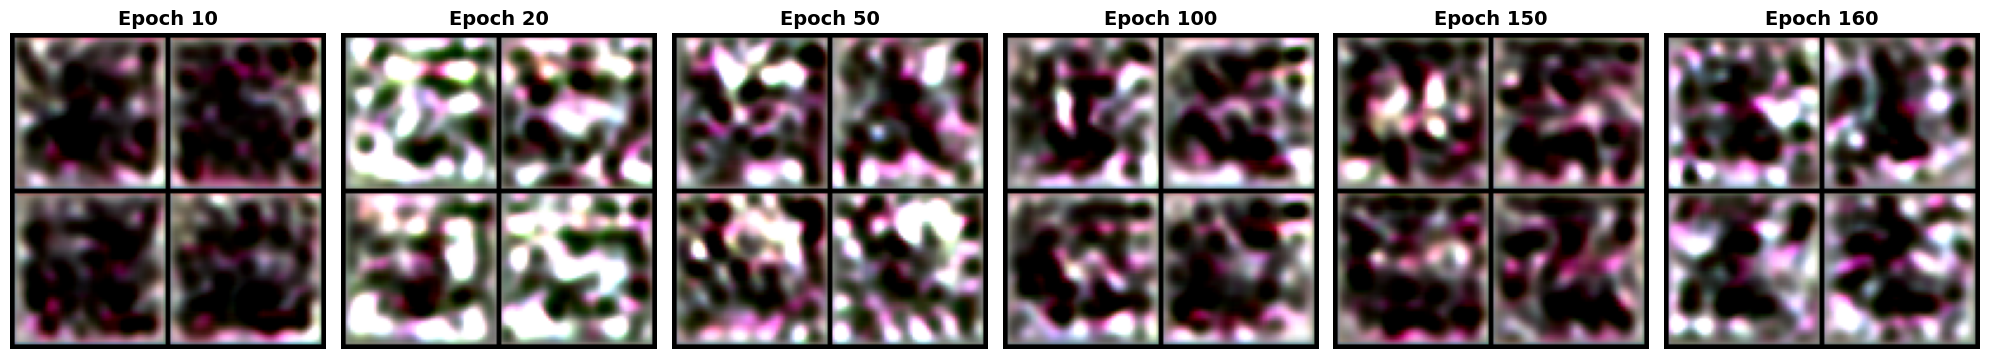

✓ Saved training progression

QUICK PREVIEW - 16 samples of first type
Generating Bug Pokemon...


✓ Saved to quick_preview.png


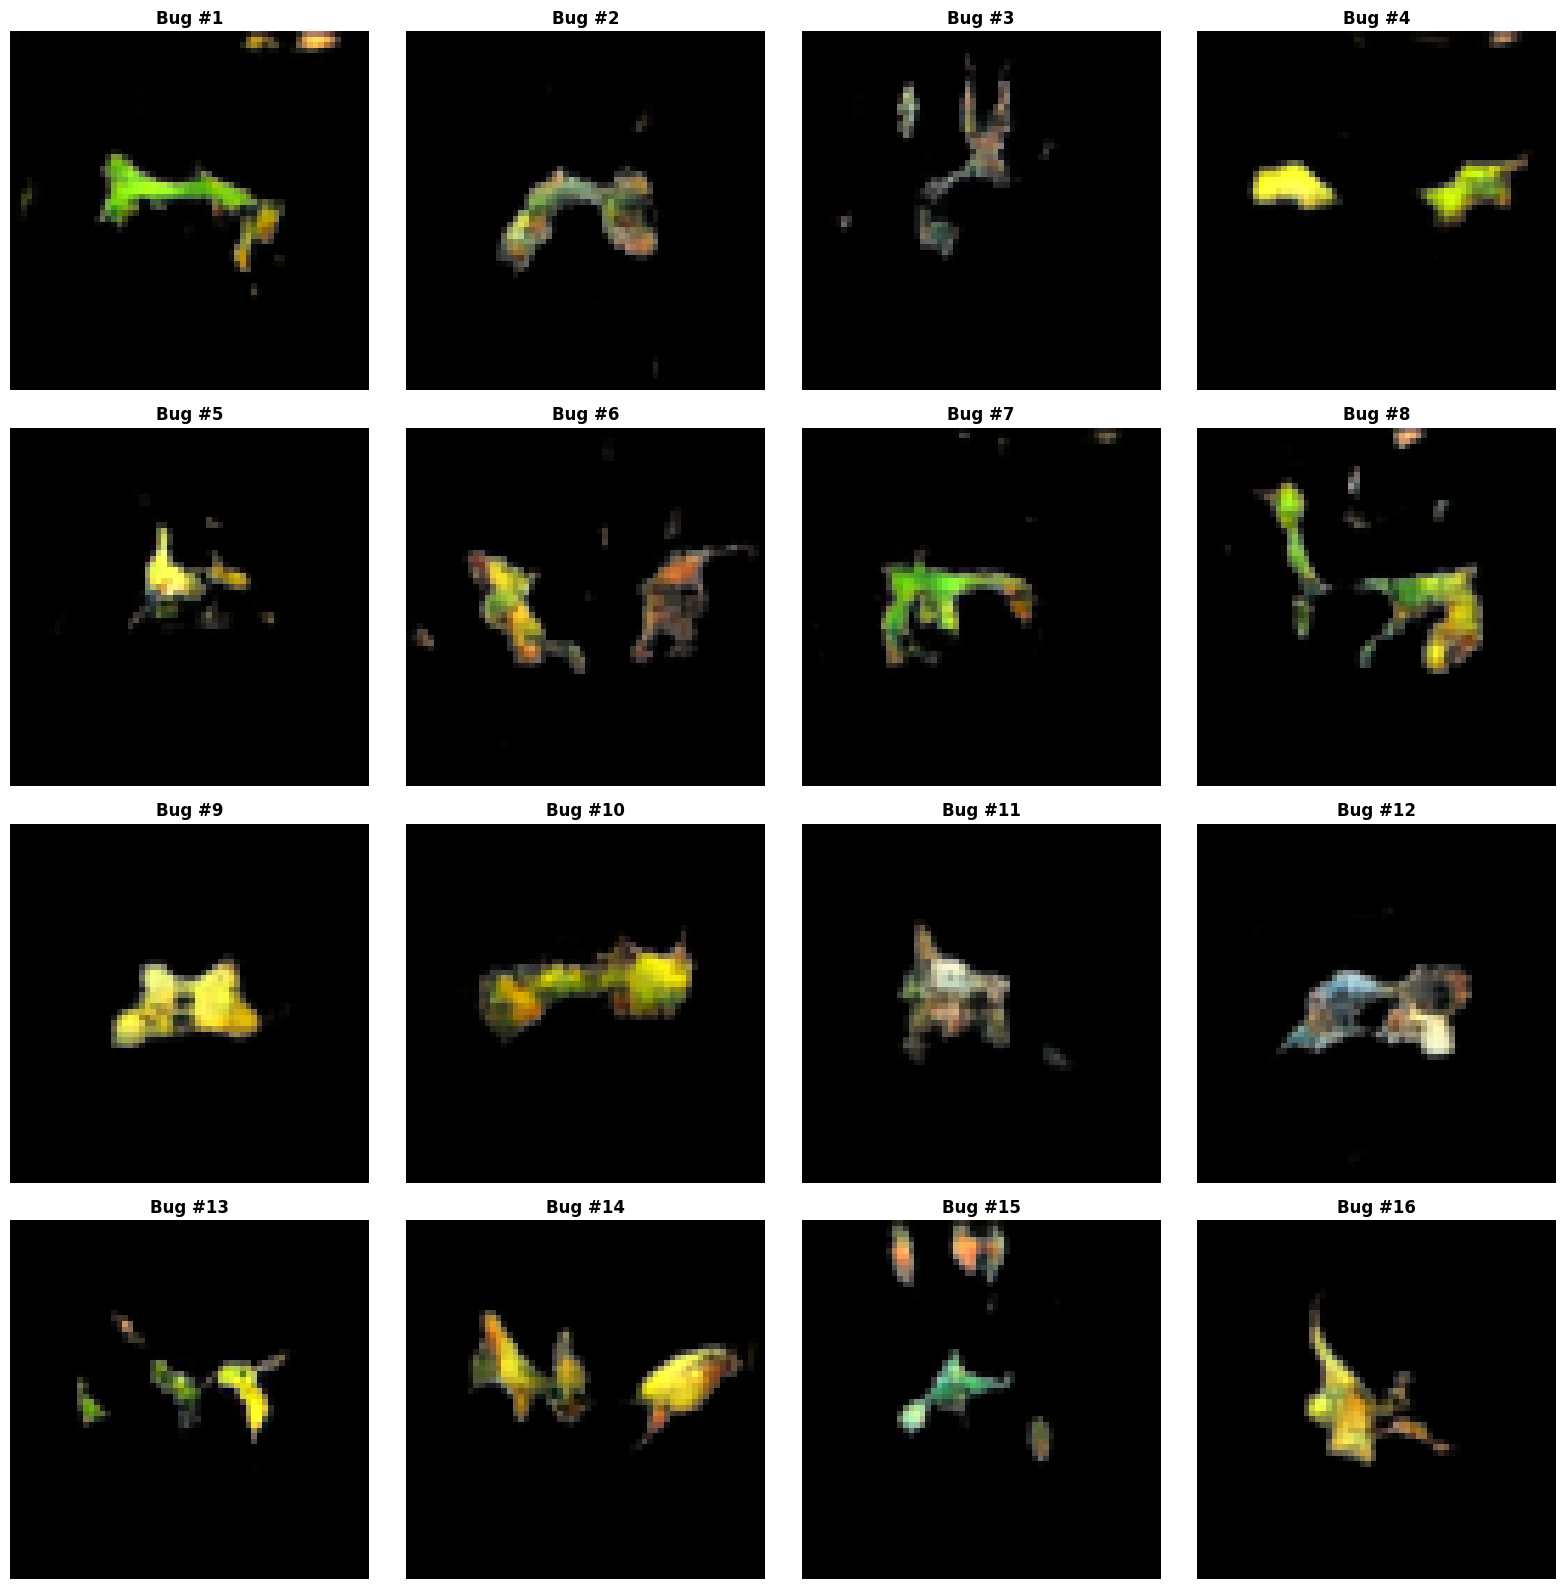


GUIDANCE SCALE COMPARISON

Comparing guidance scales for type: Bug
Generating with guidance=3.0...


Generating with guidance=5.0...


Generating with guidance=7.5...


Generating with guidance=10.0...


Generating with guidance=15.0...


✓ Saved to guidance_comparison.png


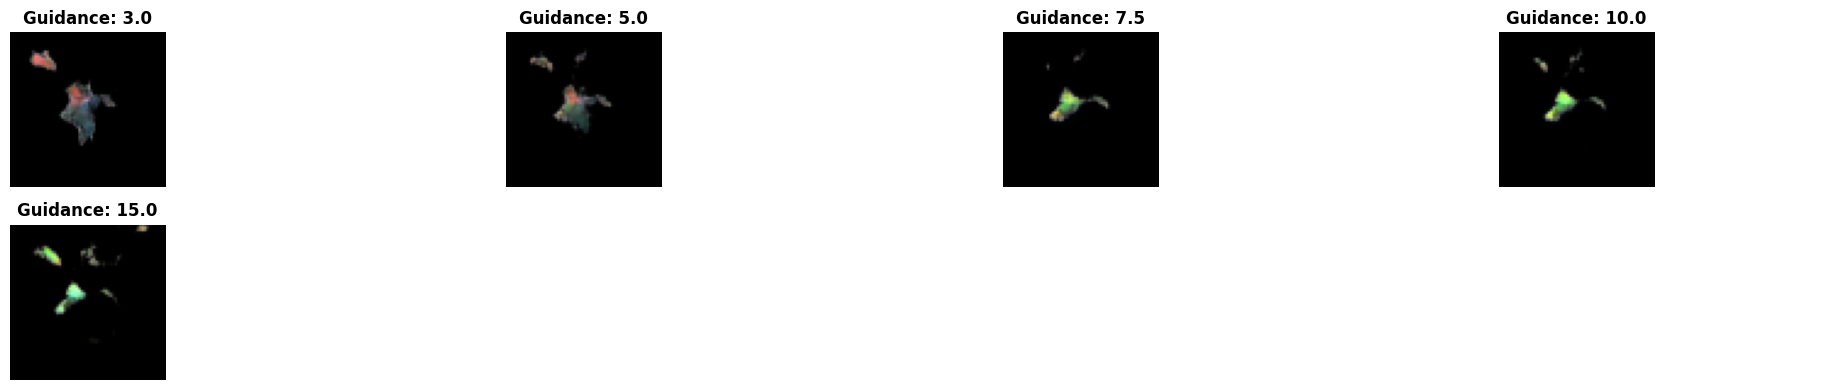


ALL POKEMON TYPES

Generating 2 Pokemon for each of 18 types...
Generating Bug Pokemon...


Generating Dark Pokemon...


Generating Dragon Pokemon...


Generating Electric Pokemon...


Generating Fairy Pokemon...


Generating Fighting Pokemon...


Generating Fire Pokemon...


Generating Flying Pokemon...


Generating Ghost Pokemon...


Generating Grass Pokemon...


Generating Ground Pokemon...


Generating Ice Pokemon...


Generating Normal Pokemon...


Generating Poison Pokemon...


Generating Psychic Pokemon...


Generating Rock Pokemon...


Generating Steel Pokemon...


Generating Water Pokemon...


✓ Saved to all_types_generated.png


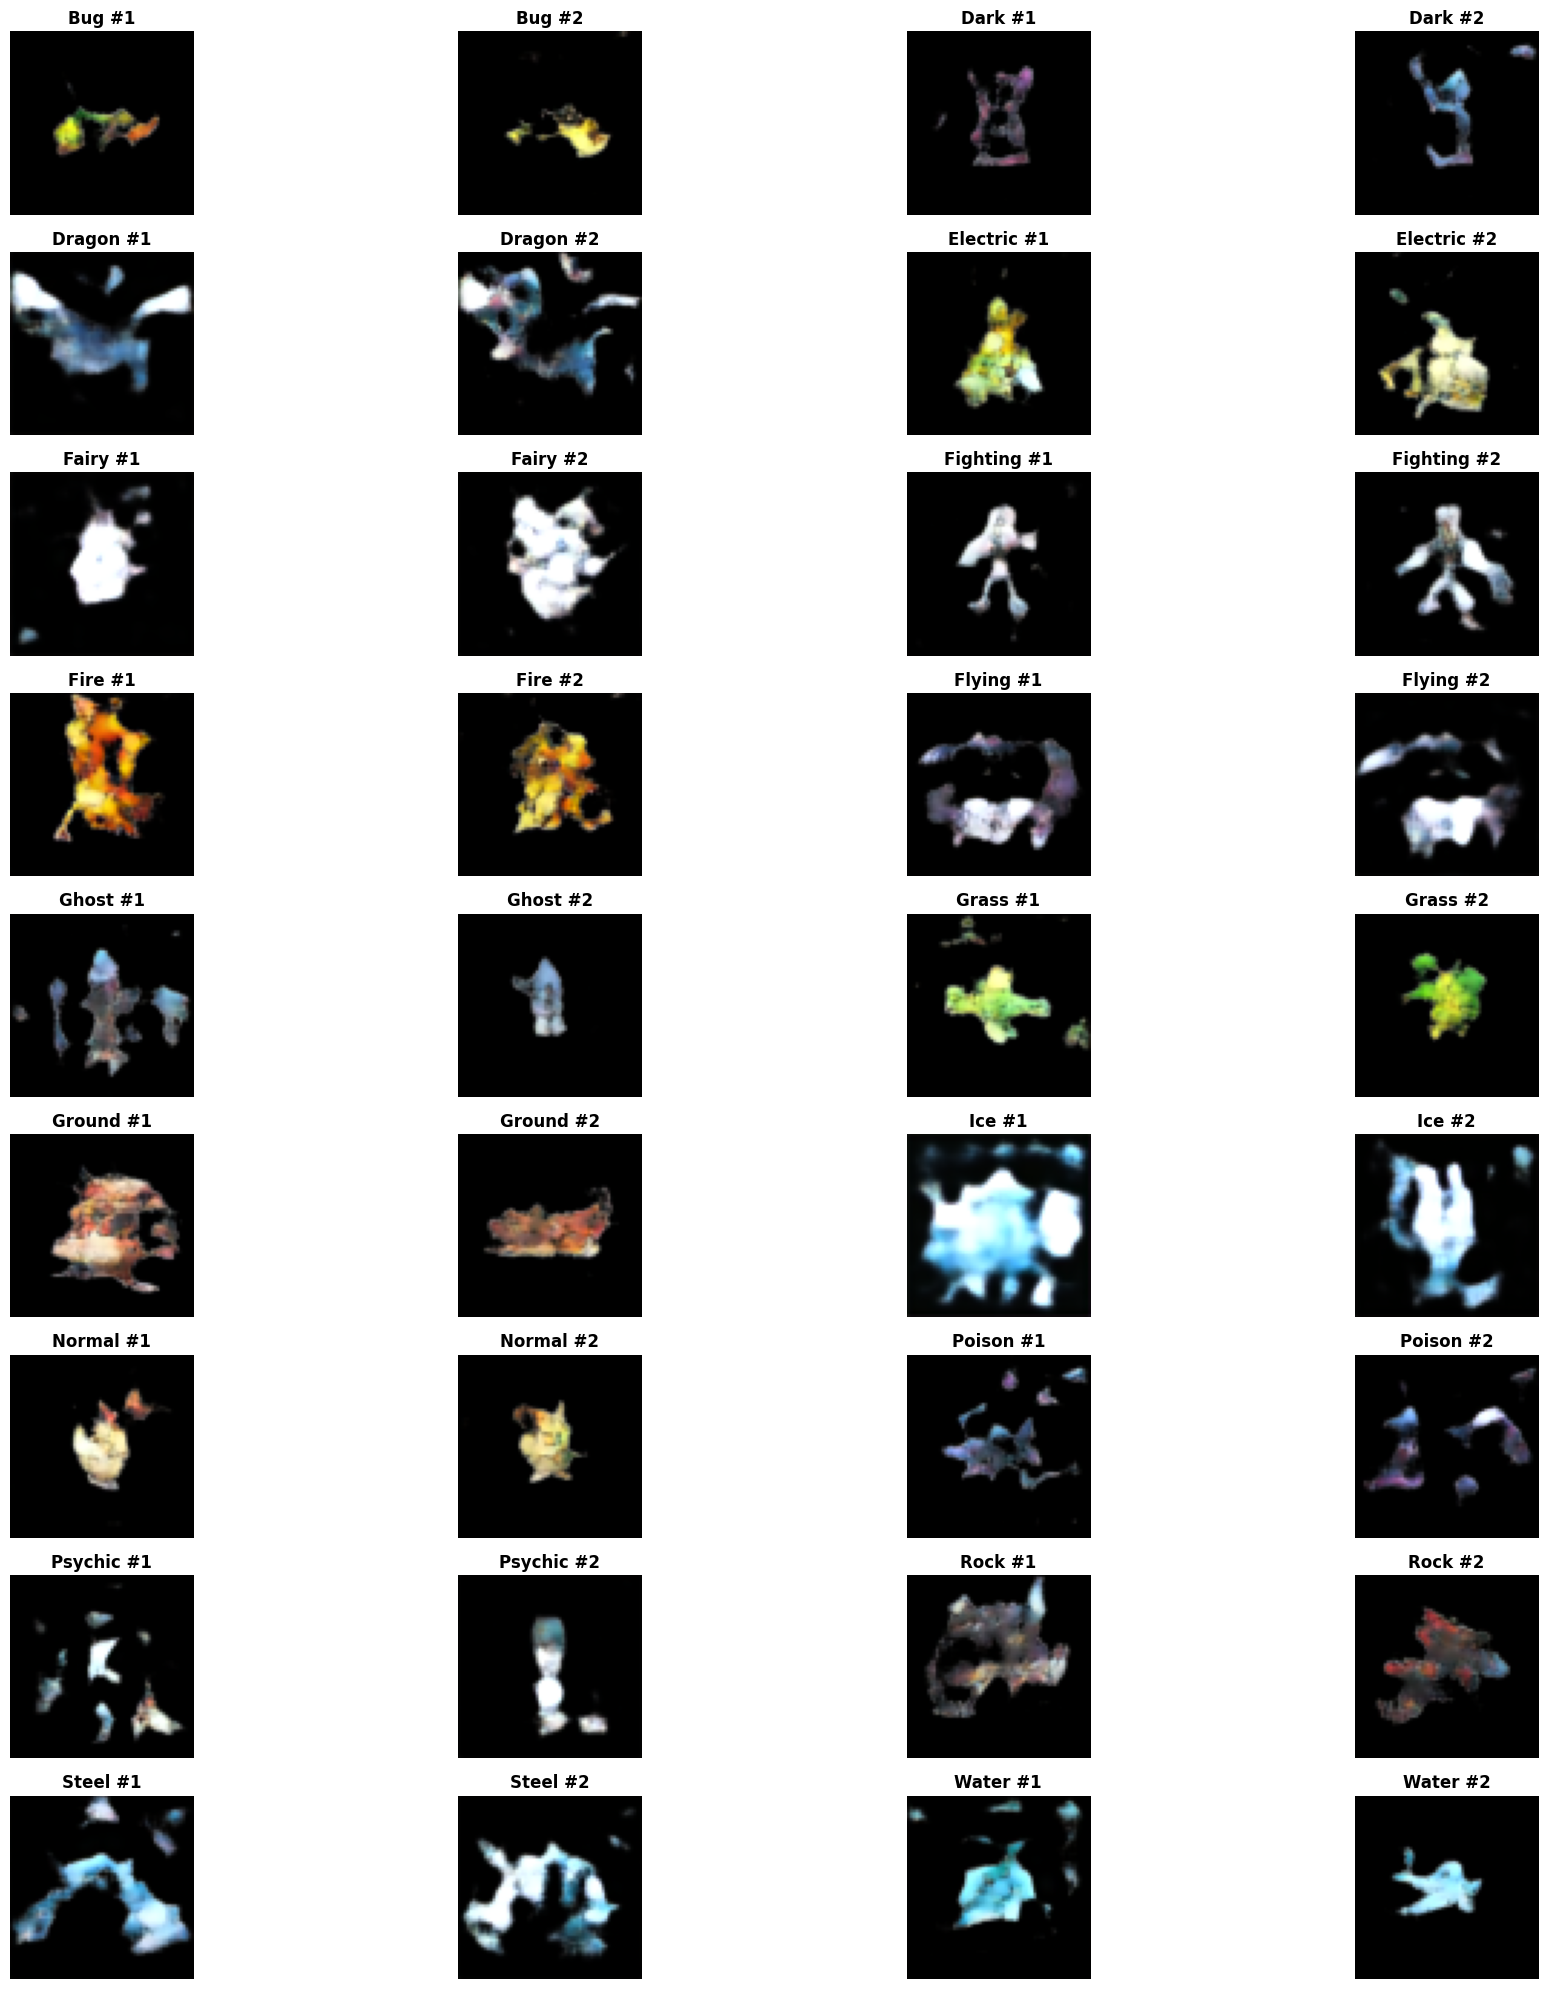


HIGH QUALITY GENERATION (200 steps)

Generating 8 high-quality Bug Pokemon...


✓ Saved to high_quality_Bug.png


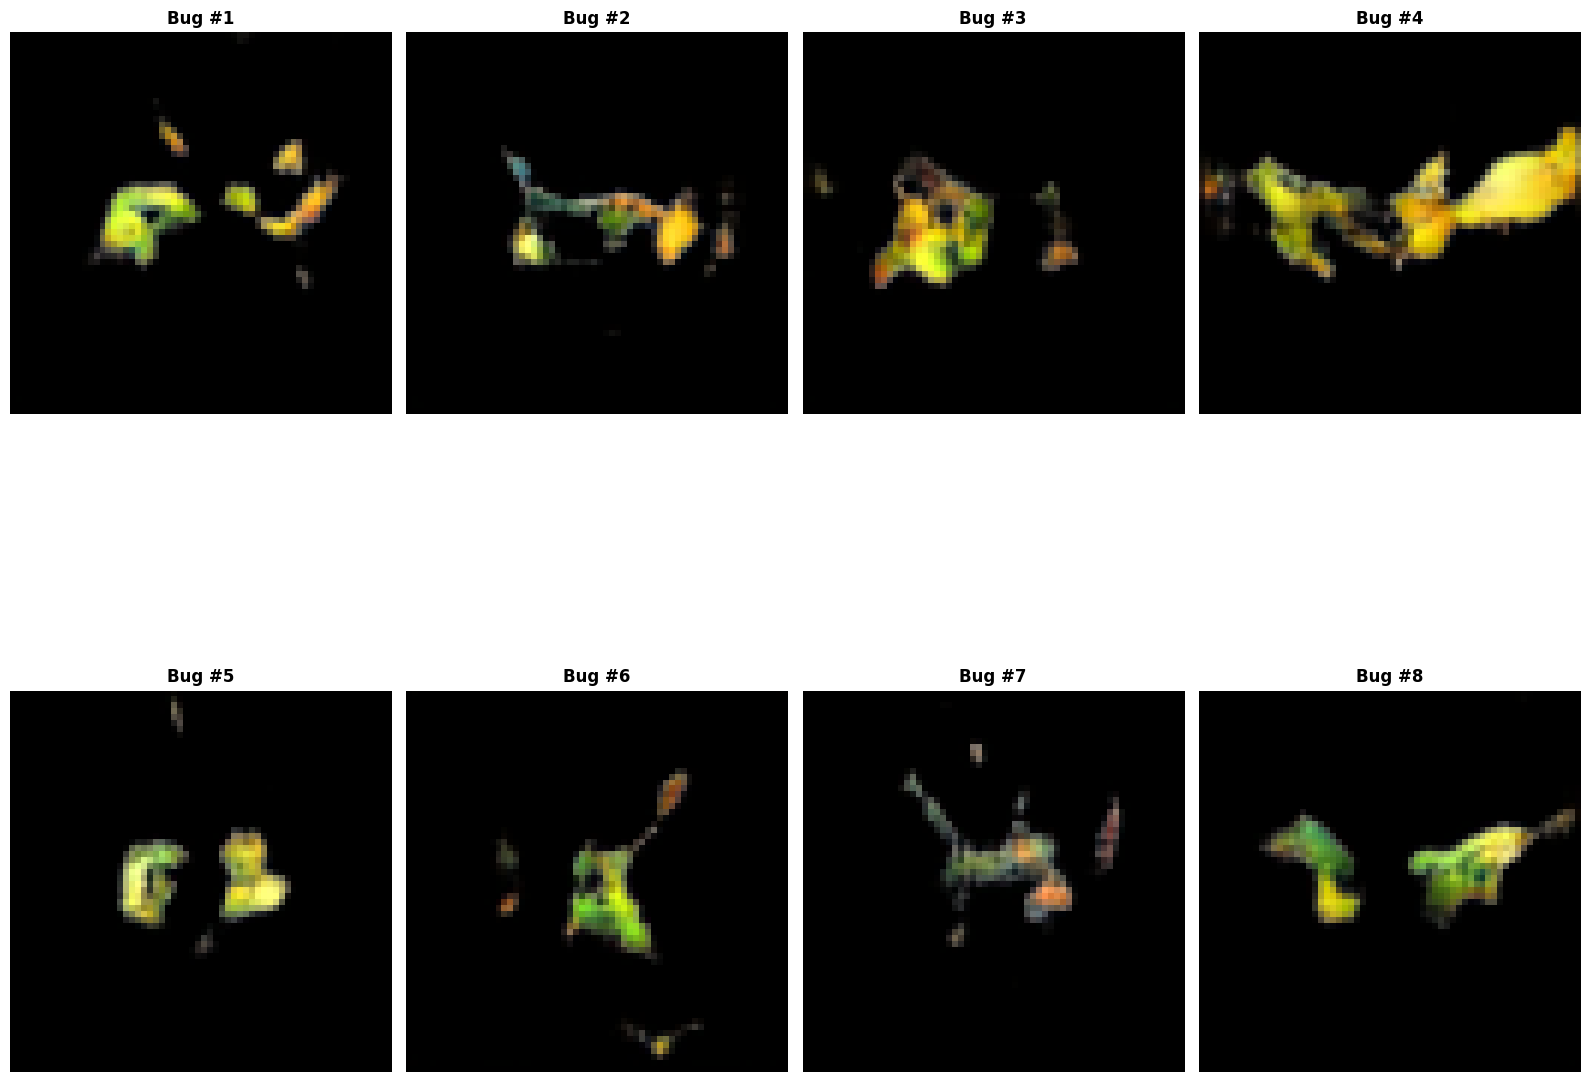


✓ ALL GENERATIONS COMPLETE!

Saved images:
  - quick_preview.png (16 samples)
  - guidance_comparison.png (different guidance scales)
  - all_types_generated.png (all Pokemon types)
  - high_quality_*.png (high quality samples)
  - training_progression.png (training evolution)


In [56]:
print("="*80)
print("POKEMON GENERATION SHOWCASE")
print("="*80)

# 1. Show training progression
show_training_progression()

# 2. Generate samples for first type (Fire, Water, or whatever is index 0)
print("\n" + "="*80)
print("QUICK PREVIEW - 16 samples of first type")
print("="*80)
type_0_name = dataset.idx_to_type.get(0, "Type 0")
print(f"Generating {type_0_name} Pokemon...")

quick_samples = generate_pokemon(
    unet, vae, scheduler,
    class_label=0,
    num_samples=16,
    guidance_scale=7.5,
    num_steps=100
)
titles = [f"{type_0_name} #{i+1}" for i in range(16)]
show_images(quick_samples, titles, figsize=(16, 16), save_path='quick_preview.png')

# 3. Compare guidance scales
print("\n" + "="*80)
print("GUIDANCE SCALE COMPARISON")
print("="*80)
compare_guidance_scales(class_label=0, scales=[3.0, 5.0, 7.5, 10.0, 15.0])

# 4. Generate one sample of each type
print("\n" + "="*80)
print("ALL POKEMON TYPES")
print("="*80)
all_type_samples = generate_all_types(samples_per_type=2, guidance_scale=7.5)

# 5. Generate high quality samples
print("\n" + "="*80)
print("HIGH QUALITY GENERATION (200 steps)")
print("="*80)
hq_samples = generate_high_quality(
    class_label=0, 
    num_samples=8,
    guidance_scale=7.5
)

print("\n" + "="*80)
print("✓ ALL GENERATIONS COMPLETE!")
print("="*80)
print("\nSaved images:")
print("  - quick_preview.png (16 samples)")
print("  - guidance_comparison.png (different guidance scales)")
print("  - all_types_generated.png (all Pokemon types)")
print("  - high_quality_*.png (high quality samples)")
print("  - training_progression.png (training evolution)")



In [46]:
# ============================================================================
# 8. INTERACTIVE GENERATION
# ============================================================================

print("\n" + "="*80)
print("INTERACTIVE GENERATION")
print("="*80)
print("\nAvailable Pokemon types:")
for idx, type_name in dataset.idx_to_type.items():
    print(f"  {idx}: {type_name}")

print("\nTo generate specific Pokemon, use:")
print("  samples = generate_pokemon(unet, vae, scheduler, class_label=TYPE_INDEX)")
print("  show_images(samples)")
print("\nExample:")
print("  # Generate 8 Fire-type Pokemon")
print("  fire_samples = generate_pokemon(unet, vae, scheduler, class_label=0, num_samples=8)")
print("  show_images(fire_samples)")


INTERACTIVE GENERATION

Available Pokemon types:
  0: Bug
  1: Dark
  2: Dragon
  3: Electric
  4: Fairy
  5: Fighting
  6: Fire
  7: Flying
  8: Ghost
  9: Grass
  10: Ground
  11: Ice
  12: Normal
  13: Poison
  14: Psychic
  15: Rock
  16: Steel
  17: Water

To generate specific Pokemon, use:
  samples = generate_pokemon(unet, vae, scheduler, class_label=TYPE_INDEX)
  show_images(samples)

Example:
  # Generate 8 Fire-type Pokemon
  fire_samples = generate_pokemon(unet, vae, scheduler, class_label=0, num_samples=8)
  show_images(fire_samples)
